In [514]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [516]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [518]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [521]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [10]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [525]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [401]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [403]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [473]:
start_date

datetime.date(2022, 4, 1)

In [475]:
start_date - pd.Timedelta(days=warmup_days)

datetime.date(2021, 6, 5)

In [477]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [479]:
end_date

datetime.date(2025, 12, 4)

In [481]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [483]:
end_date_temp = pd.Timestamp('2025-07-31').date()

In [485]:
type(end_date_temp)

datetime.date

## Original Prod Config with Core L1 Coins

In [36]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [38]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3317590416631553,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'calmar_ratio': 2.560309328537423,
 'annualized_std_dev': 0.4247262948243901,
 'max_drawdown': -0.12957771858475892,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13717693836978131,
 't_statistic': 2.798163113836065,
 'p_value': 0.005237657951494762,
 'trade_count': 139.0}

<Axes: title={'center': '5 Coin Strategy Target Notional'}, xlabel='date'>

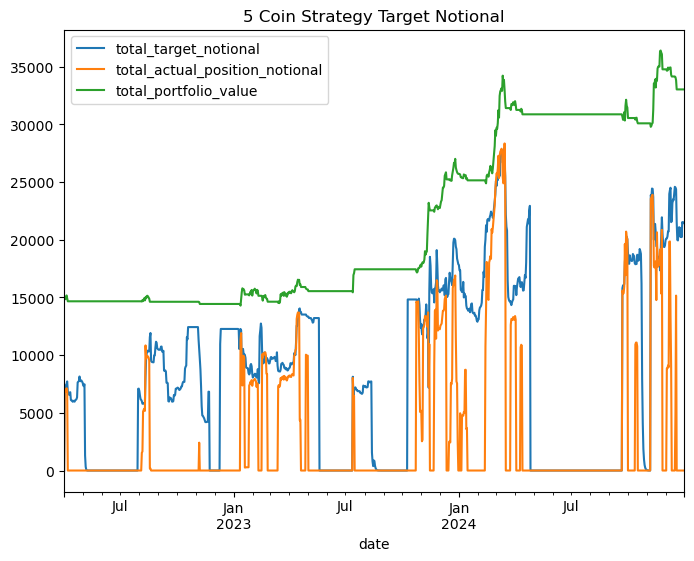

In [39]:
df_final_prod_config[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

<Axes: xlabel='date'>

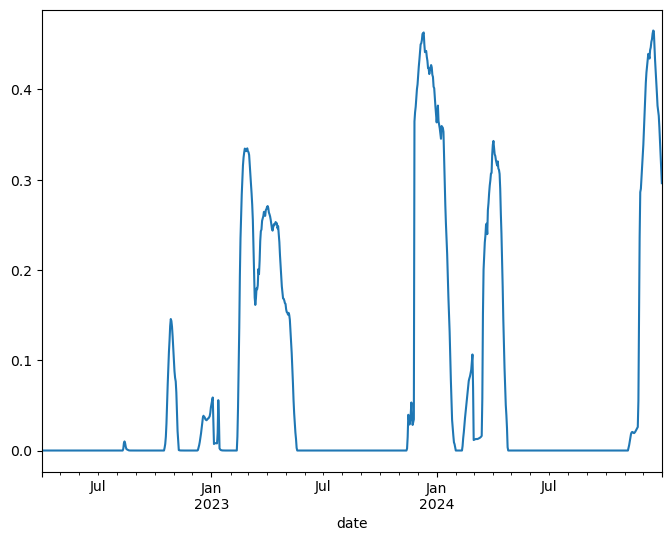

In [40]:
df_final_prod_config['BTC-USD_final_signal'].plot(figsize=(8,6))

<Axes: xlabel='date'>

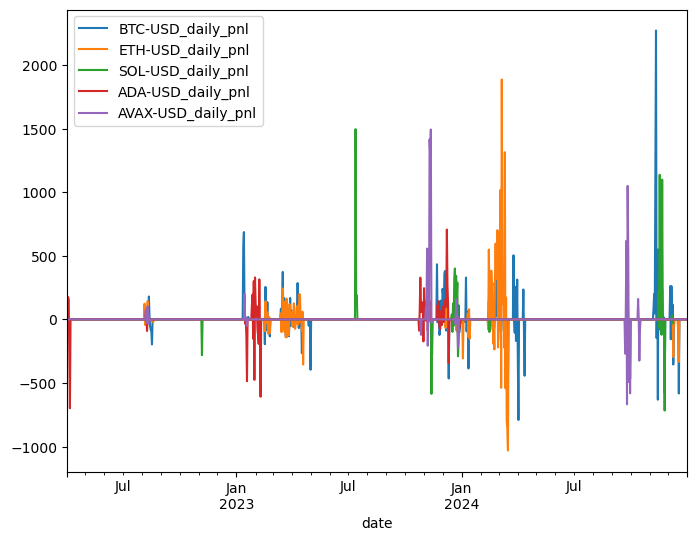

In [41]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config[daily_pnl_cols].plot(figsize=(8,6))

In [42]:
final_weighted_additive_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_weighted_additive_signal_cols]

BTC-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.387492   
2023-10-02                               -0.369007   
2023-10-03                               -0.357815   
2023-10-04                               -0.348035   
2023-10-05                               -0.334373   
2023-10-06                               -0.323921   
2023-10-07                               -0.307568   
2023-10-08                               -0.292081   
2023-10-09                               -0.278553   
2023-10-10                               -0.270417   
2023-10-11                               -0.264304   
2023-10-12                               -0.264557   
2023-10-13                               -0.264751   
2023-10-14                               -0.263127   
2023-10-15                               -0.262527   
2023-10-16                               -0.257254   
2023-10-17                               -0.220524   
2023-10-18                               -0.213887   
2023-10-19                               -0.205134   
2023-10-20                               -0.187995   
2023-10-21                               -0.150239   
2023-10-22                               -0.114617   
2023-10-23                               -0.082271   
2023-10-24                               -0.027345   
2023-10-25                                0.023922   
2023-10-26                                0.088202   
2023-10-27                                0.145623   
2023-10-28                                0.194981   
2023-10-29                                0.240422   
2023-10-30                                0.285559   
2023-10-31                                0.321538   

            ETH-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.410644   
2023-10-02                               -0.390485   
2023-10-03                               -0.384545   
2023-10-04                               -0.379194   
2023-10-05                               -0.375332   
2023-10-06                               -0.379320   
2023-10-07                               -0.372291   
2023-10-08                               -0.368592   
2023-10-09                               -0.365033   
2023-10-10                               -0.375864   
2023-10-11                               -0.386200   
2023-10-12                               -0.393505   
2023-10-13                               -0.403567   
2023-10-14                               -0.406463   
2023-10-15                               -0.408181   
2023-10-16                               -0.408529   
2023-10-17                               -0.393713   
2023-10-18                               -0.395086   
2023-10-19                               -0.396039   
2023-10-20                               -0.394475   
2023-10-21                               -0.379734   
2023-10-22                               -0.362051   
2023-10-23                               -0.338162   
2023-10-24                               -0.286137   
2023-10-25                               -0.243550   
2023-10-26                               -0.212857   
2023-10-27                               -0.175338   
2023-10-28                               -0.143806   
2023-10-29                               -0.112520   
2023-10-30                               -0.076431   
2023-10-31                               -0.037489   

            SOL-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.145097   
2023-10-02                               -0.094254   
2023-10-03                               -0.052047   
2023-10-04                               -0.009342   
2023-10-05                                0.024455   
2023-10-06                                0.050193   
2023-10-07    

In [43]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_signal_cols]

BTC-USD_final_signal  ETH-USD_final_signal  SOL-USD_final_signal  \
date                                                                           
2023-10-01          0.000000e+00                   0.0          0.000000e+00   
2023-10-02          0.000000e+00                   0.0          0.000000e+00   
2023-10-03          0.000000e+00                   0.0          0.000000e+00   
2023-10-04          0.000000e+00                   0.0          0.000000e+00   
2023-10-05          0.000000e+00                   0.0          4.322411e-31   
2023-10-06          0.000000e+00                   0.0          4.435910e-31   
2023-10-07          0.000000e+00                   0.0          3.591226e-31   
2023-10-08          0.000000e+00                   0.0          2.385976e-31   
2023-10-09          0.000000e+00                   0.0          1.447284e-31   
2023-10-10          0.000000e+00                   0.0          7.633809e-32   
2023-10-11          0.000000e+00                   0.0          3.985097e-32   
2023-10-12          0.000000e+00                   0.0          2.084842e-32   
2023-10-13          0.000000e+00                   0.0          1.011882e-32   
2023-10-14          0.000000e+00                   0.0          5.129430e-33   
2023-10-15          0.000000e+00                   0.0          2.614530e-33   
2023-10-16          0.000000e+00                   0.0          2.289222e-33   
2023-10-17          0.000000e+00                   0.0          3.572946e-33   
2023-10-18          0.000000e+00                   0.0          4.168131e-33   
2023-10-19          0.000000e+00                   0.0          2.274496e-33   
2023-10-20          0.000000e+00                   0.0          1.269994e-33   
2023-10-21          0.000000e+00                   0.0          7.160339e-34   
2023-10-22          0.000000e+00                   0.0          4.052762e-34   
2023-10-23          0.000000e+00                   0.0          2.213790e-34   
2023-10-24          0.000000e+00                   0.0          1.226823e-34   
2023-10-25          1.173228e-06                   0.0          3.454231e-35   
2023-10-26          2.162852e-06                   0.0          3.673565e-36   
2023-10-27          1.785455e-06                   0.0          1.810660e-36   
2023-10-28          1.195310e-06                   0.0          9.288108e-37   
2023-10-29          7.369405e-07                   0.0          4.729122e-37   
2023-10-30          4.376462e-07                   0.0          2.420684e-37   
2023-10-31          2.463942e-07                   0.0          3.577713e-37   

            ADA-USD_final_signal  AVAX-USD_final_signal  
date                                                     
2023-10-01              0.000000               0.000000  
2023-10-02              0.000000               0.000000  
2023-10-03              0.000000               0.000000  
2023-10-04              0.000000               0.000000  
2023-10-05              0.000000               0.000000  
2023-10-06              0.000000               0.000000  
2023-10-07              0.000000               0.000000  
2023-10-08              0.000000               0.000000  
2023-10-09              0.000000               0.000000  
2023-10-10              0.002474               0.000000  
2023-10-11              0.007888               0.000000  
2023-10-12              0.013616               0.000000  
2023-10-13              0.016761               0.000000  
2023-10-14              0.019950               0.000000  
2023-10-15              0.026248               0.000000  
2023-10-16              0.033279               0.000000  
2023-10-17              0.048231               0.000000  
2023-10-18              0.052950               0.000000  
2023-10-19              0.048838               0.000000  
2023-10-20              0.054688               0.000000  
2023-10-21              0.070172               0.000000  
2023-10-22              0.096522     

In [44]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## L1 Coin Performance Research

### L1 Coins Run 2

In [48]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list = ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD']
df_final_l1_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_run_2 = df_final_l1_run_2[df_final_l1_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_run_2 = perf.calculate_asset_level_returns(df_final_l1_run_2, end_date_test, l1_ticker_list)

portfolio_perf_metrics_l1_run_2 = calculate_risk_and_performance_metrics(df_final_l1_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_run_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
DOT-USD
ATOM-USD
LTC-USD
ALGO-USD
XLM-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.03674368046743215,
 'annualized_sharpe_ratio': -0.00010409304664330481,
 'calmar_ratio': 0.2063826341973543,
 'annualized_std_dev': 0.38838302001126124,
 'max_drawdown': -0.17803668709982567,
 'max_drawdown_duration': Timedelta('388 days 00:00:00'),
 'hit_rate': 0.073558648111332,
 't_statistic': 0.503573641983973,
 'p_value': 0.6146713753586656,
 'trade_count': 95.0}

<Axes: title={'center': '5 Coin Strategy Target Notional'}, xlabel='date'>

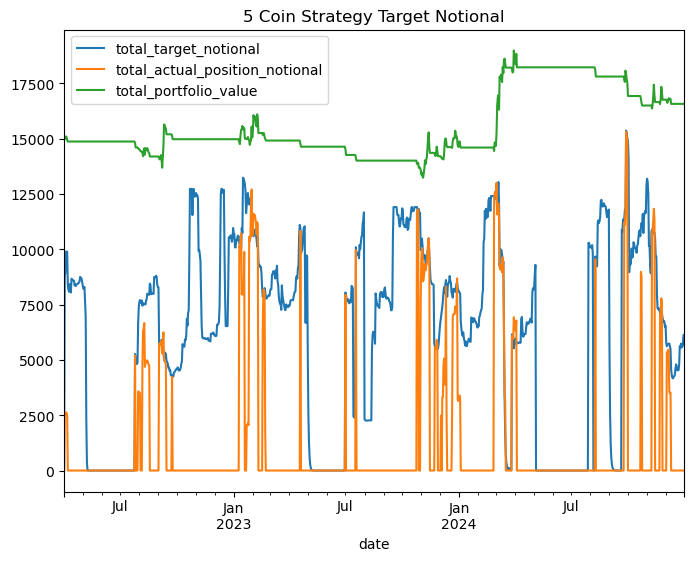

In [49]:
df_final_l1_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

<Axes: xlabel='date'>

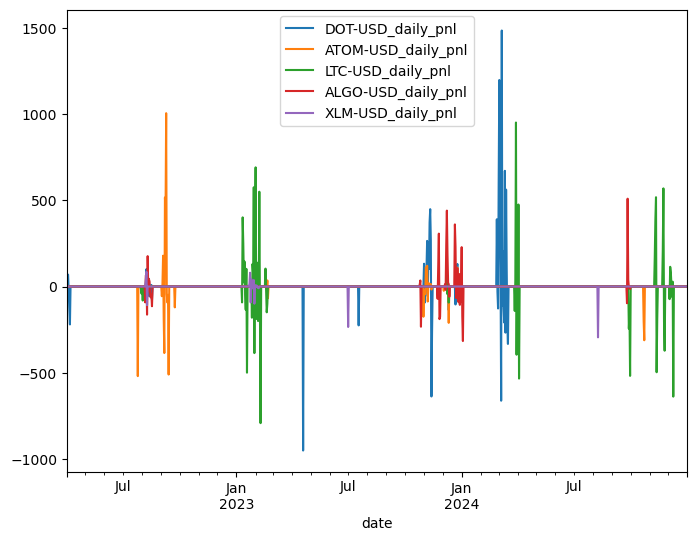

In [50]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list]
df_final_l1_run_2[daily_pnl_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

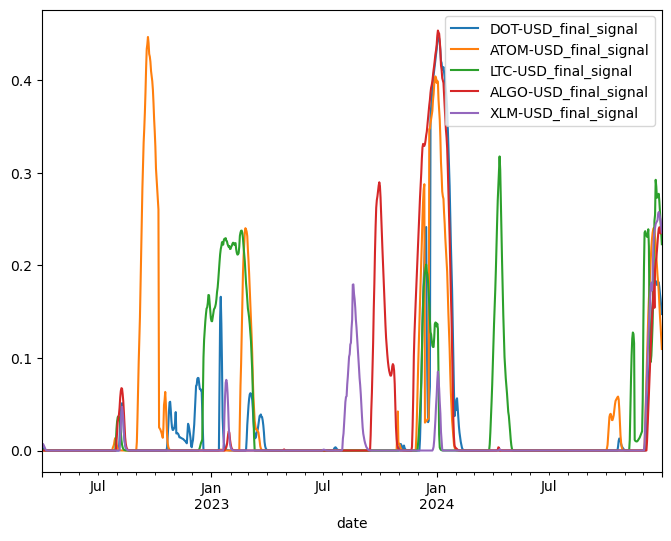

In [51]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list]
df_final_l1_run_2[final_signal_cols].plot(figsize=(8,6))

## L1 Alt Coins Performance Research

In [53]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_alt_ticker_list = ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD']
df_final_l1_alt_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_alt_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_alt_run_1 = df_final_l1_alt_run_1[df_final_l1_alt_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_alt_run_1 = perf.calculate_asset_level_returns(df_final_l1_alt_run_1, end_date_test, l1_alt_ticker_list)

portfolio_perf_metrics_l1_alt_run_1 = calculate_risk_and_performance_metrics(df_final_l1_alt_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                             strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_alt_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.29982672485875517,
 'annualized_sharpe_ratio': 1.0571489502659441,
 'calmar_ratio': 2.77421161922569,
 'annualized_std_dev': 0.7275517266101227,
 'max_drawdown': -0.10807637124035972,
 'max_drawdown_duration': Timedelta('246 days 00:00:00'),
 'hit_rate': 0.0775347912524851,
 't_statistic': 2.117381657848802,
 'p_value': 0.034472578644124,
 'trade_count': 93.0}

<Axes: xlabel='date'>

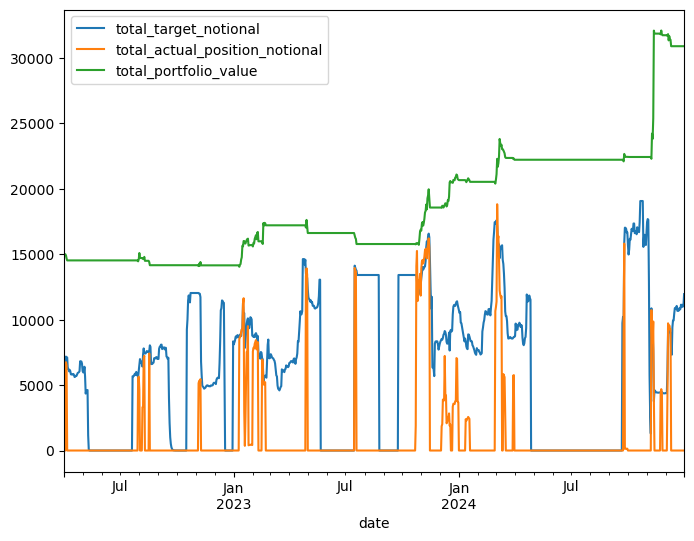

In [54]:
df_final_l1_alt_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

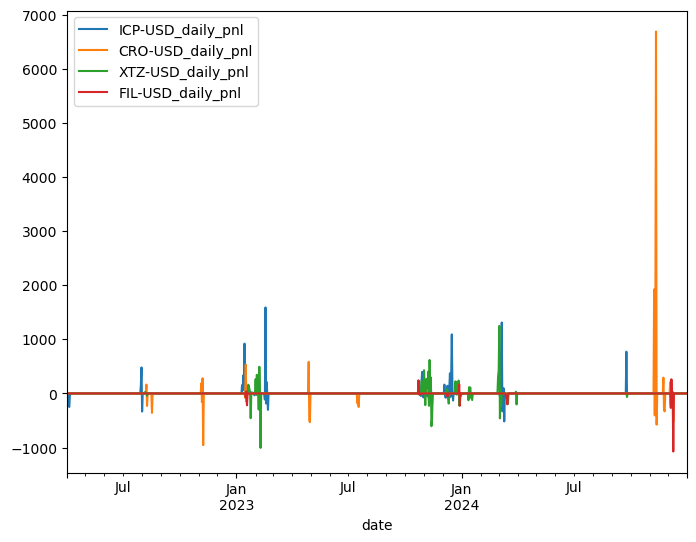

In [55]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[daily_pnl_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

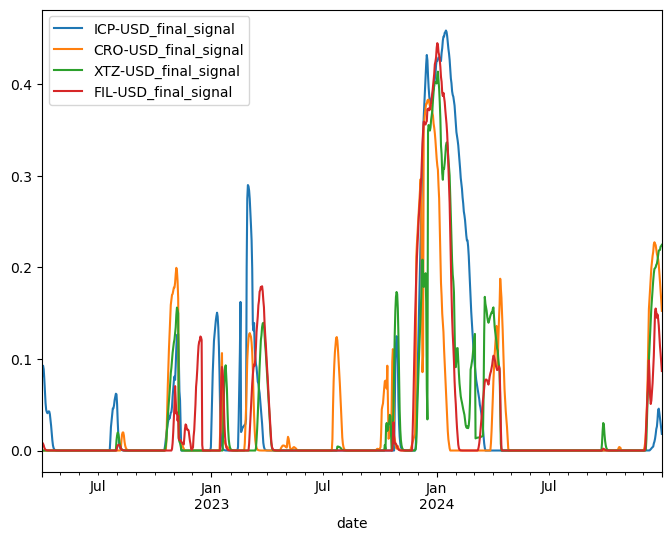

In [56]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[final_signal_cols].plot(figsize=(8,6))

## L2 Coins Performance Research

In [ ]:
L1_ALT_TICKERS += [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
# That gives you 14; you can optionally keep one more from "Other" or AI/infra
# to make it exactly 15 if you want a full grid.


In [297]:
missing_l1_ticker_list = [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
missing_l1_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l1_ticker_list)

Checking data for SEI-USD: 2016-01-01 00:00:00
Data available from: 2023-08-15
First available date for SEI-USD: 2023-08-15
Checking data for TIA-USD: 2016-01-01 00:00:00
Data available from: 2023-11-01
First available date for TIA-USD: 2023-11-01
Checking data for KAVA-USD: 2016-01-01 00:00:00
Data available from: 2023-01-19
First available date for KAVA-USD: 2023-01-19
Checking data for ROSE-USD: 2016-01-01 00:00:00


2025-11-25 21:23:24 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2022-04-26
First available date for ROSE-USD: 2022-04-26
Checking data for CELO-USD: 2016-01-01 00:00:00
HTTPError encountered for CELO-USD. Skipping further checks.
No data available within the date range for CELO-USD.
Checking data for HNT-USD: 2016-01-01 00:00:00


2025-11-25 21:23:33 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2023-07-12
First available date for HNT-USD: 2023-07-12
Checking data for MOBILE-USD: 2016-01-01 00:00:00
HTTPError encountered for MOBILE-USD. Skipping further checks.
No data available within the date range for MOBILE-USD.
Checking data for RNDR-USD: 2016-01-01 00:00:00
Data available from: 2022-02-03
First available date for RNDR-USD: 2022-02-03


In [299]:
missing_l1_ticker_start_date_dict

{'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'CELO-USD': None,
 'HNT-USD': '2023-07-12',
 'MOBILE-USD': None,
 'RNDR-USD': '2022-02-03'}

In [105]:
missing_l2_ticker_list = ['ZK-USD','MNT-USD','MANTA-USD','LRC-USD','ZORA-USD','POL-USD','METIS-USD','STX-USD']
missing_l2_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l2_ticker_list)

Checking data for ZK-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2024-09-25
First available date for ZK-USD: 2024-09-25
Checking data for MNT-USD: 2016-01-01 00:00:00
HTTPError encountered for MNT-USD. Skipping further checks.
No data available within the date range for MNT-USD.
Checking data for MANTA-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


HTTPError encountered for MANTA-USD. Skipping further checks.
No data available within the date range for MANTA-USD.
Checking data for LRC-USD: 2016-01-01 00:00:00
Data available from: 2020-09-15
First available date for LRC-USD: 2020-09-15
Checking data for ZORA-USD: 2016-01-01 00:00:00
Data available from: 2025-04-24
First available date for ZORA-USD: 2025-04-24
Checking data for POL-USD: 2016-01-01 00:00:00
Data available from: 2024-09-04
First available date for POL-USD: 2024-09-04
Checking data for METIS-USD: 2016-01-01 00:00:00
Data available from: 2022-06-28
First available date for METIS-USD: 2022-06-28
Checking data for STX-USD: 2016-01-01 00:00:00
Data available from: 2022-01-20
First available date for STX-USD: 2022-01-20


In [107]:
missing_l2_ticker_start_date_dict

{'ZK-USD': '2024-09-25',
 'MNT-USD': None,
 'MANTA-USD': None,
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'POL-USD': '2024-09-04',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'}

### L2 Coins First Ticker List

In [58]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l2_ticker_list = ['SKL-USD','IMX-USD','LRC-USD','STX-USD']
df_final_l2_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l2_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l2_run_1 = df_final_l2_run_1[df_final_l2_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l2_run_1 = perf.calculate_asset_level_returns(df_final_l2_run_1, end_date_test, l2_ticker_list)

portfolio_perf_metrics_l2_run_1 = calculate_risk_and_performance_metrics(df_final_l2_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l2_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.21731440150665549,
 'annualized_sharpe_ratio': 0.9714601169122059,
 'calmar_ratio': 2.825807413853198,
 'annualized_std_dev': 0.39862159192765223,
 'max_drawdown': -0.07690347206299214,
 'max_drawdown_duration': Timedelta('263 days 00:00:00'),
 'hit_rate': 0.09045725646123261,
 't_statistic': 2.1002046785664215,
 'p_value': 0.035959585314616196,
 'trade_count': 86.0}

<Axes: xlabel='date'>

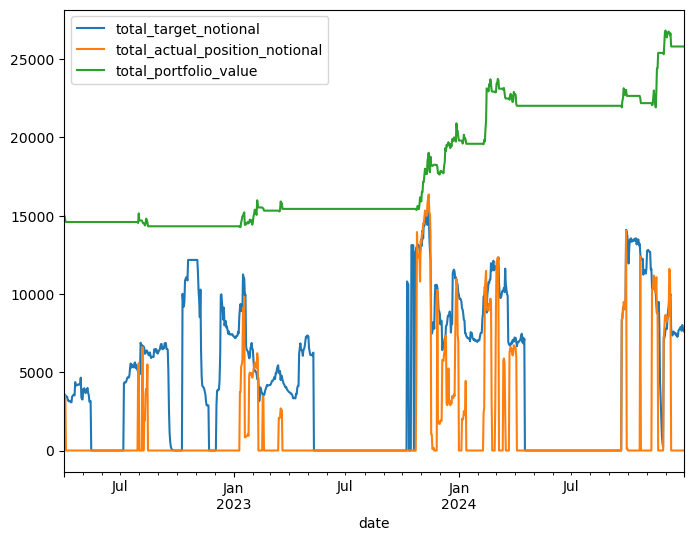

In [59]:
df_final_l2_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

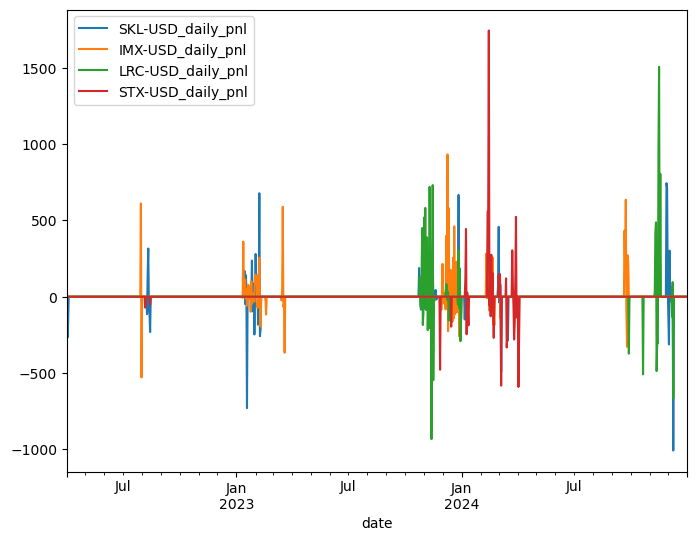

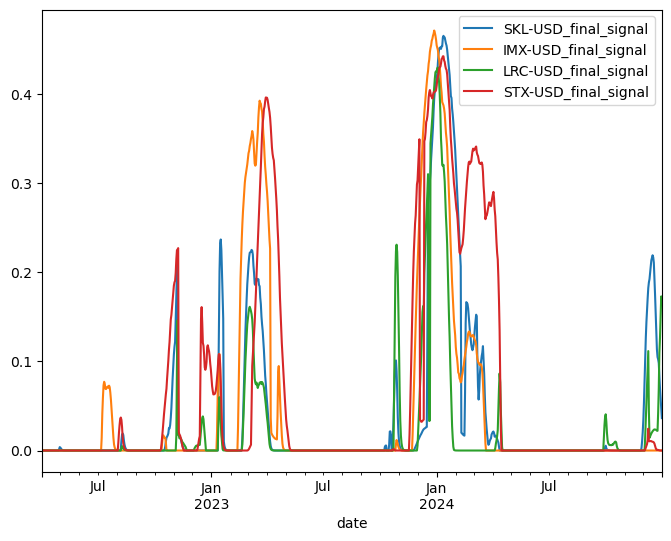

In [60]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l2_ticker_list]
df_final_l2_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in l2_ticker_list]
df_final_l2_run_1[final_signal_cols].plot(figsize=(8,6))

## AI Coins Performance Research

In [62]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
ai_ticker_list = ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD']
df_final_ai_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ai_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_ai_run_1 = df_final_ai_run_1[df_final_ai_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_ai_run_1 = perf.calculate_asset_level_returns(df_final_ai_run_1, end_date_test, ai_ticker_list)

portfolio_perf_metrics_ai_run_1 = calculate_risk_and_performance_metrics(df_final_ai_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_ai_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.4268033329122023,
 'annualized_sharpe_ratio': 0.7025007091712941,
 'calmar_ratio': 2.0574684360055193,
 'annualized_std_dev': 2.203989120081168,
 'max_drawdown': -0.20744101121707675,
 'max_drawdown_duration': Timedelta('367 days 00:00:00'),
 'hit_rate': 0.06560636182902585,
 't_statistic': 1.3000643027956844,
 'p_value': 0.19387700877675926,
 'trade_count': 84.0}

<Axes: xlabel='date'>

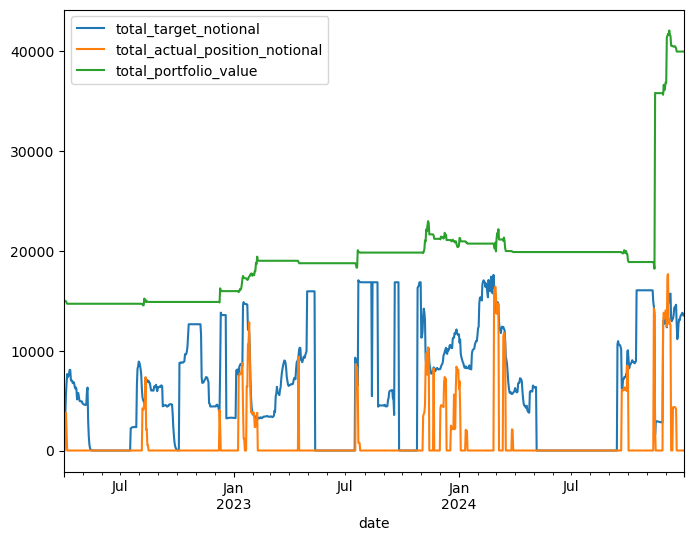

In [63]:
df_final_ai_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

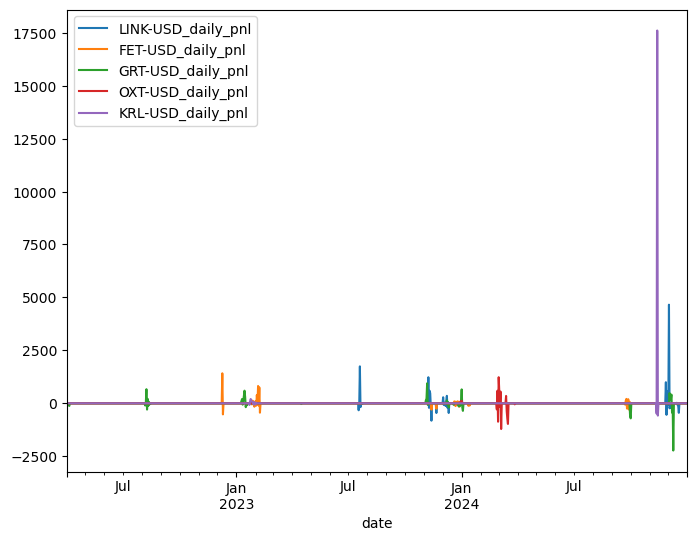

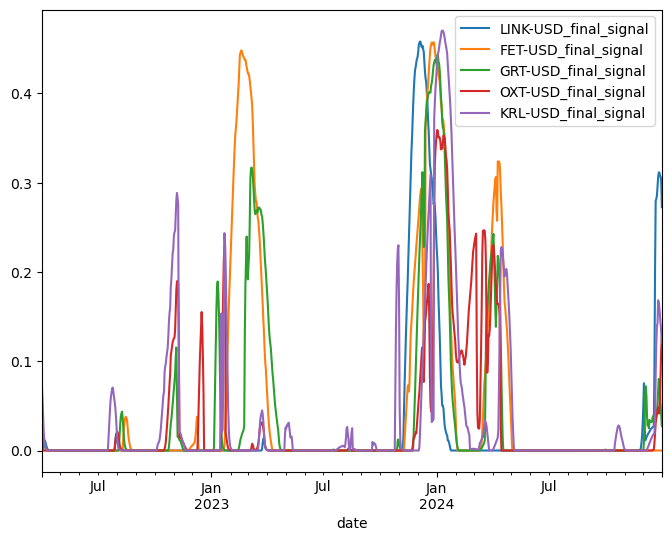

In [64]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ai_ticker_list]
df_final_ai_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in ai_ticker_list]
df_final_ai_run_1[final_signal_cols].plot(figsize=(8,6))

## Defi Coins Performance Research

### Defi First Ticker Test

In [67]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list = ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD']
df_final_defi_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_1 = df_final_defi_run_1[df_final_defi_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_1 = perf.calculate_asset_level_returns(df_final_defi_run_1, end_date_test, defi_ticker_list)

portfolio_perf_metrics_defi_run_1 = calculate_risk_and_performance_metrics(df_final_defi_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
UNI-USD
AAVE-USD
AMP-USD
COMP-USD
MKR-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.105842090379769,
 'annualized_sharpe_ratio': 0.35791522654686875,
 'calmar_ratio': 0.5473468018027549,
 'annualized_std_dev': 0.541911801709621,
 'max_drawdown': -0.1933729950210084,
 'max_drawdown_duration': Timedelta('421 days 00:00:00'),
 'hit_rate': 0.10039761431411531,
 't_statistic': 1.0089449254715865,
 'p_value': 0.3132438978924317,
 'trade_count': 109.0}

<Axes: xlabel='date'>

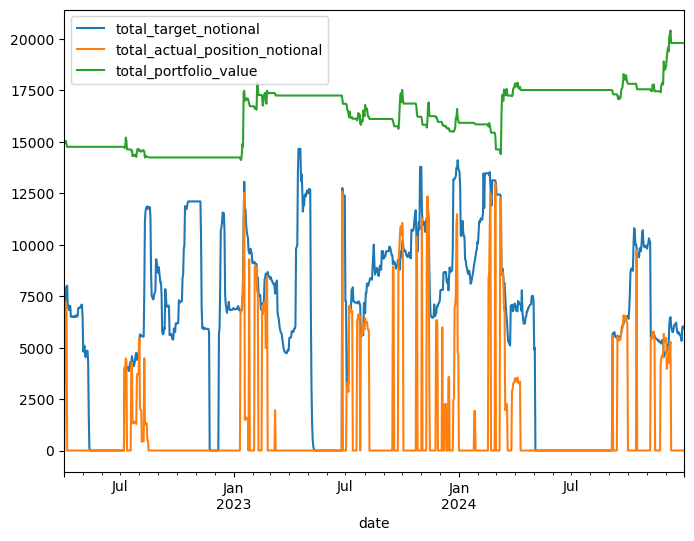

In [68]:
df_final_defi_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

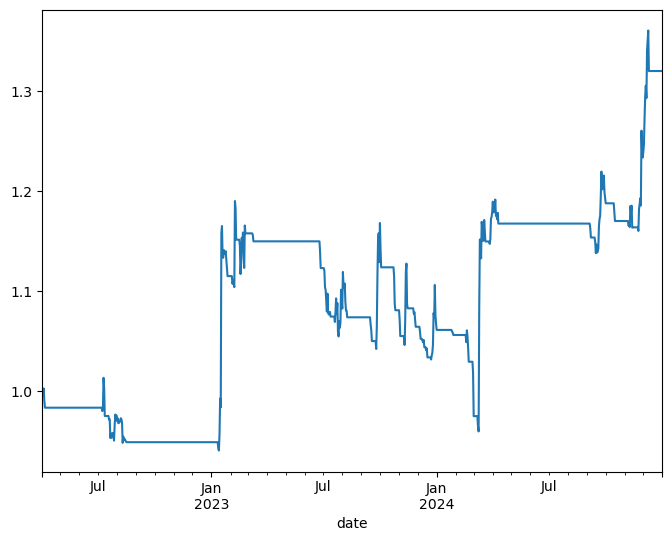

In [69]:
df_final_defi_run_1['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

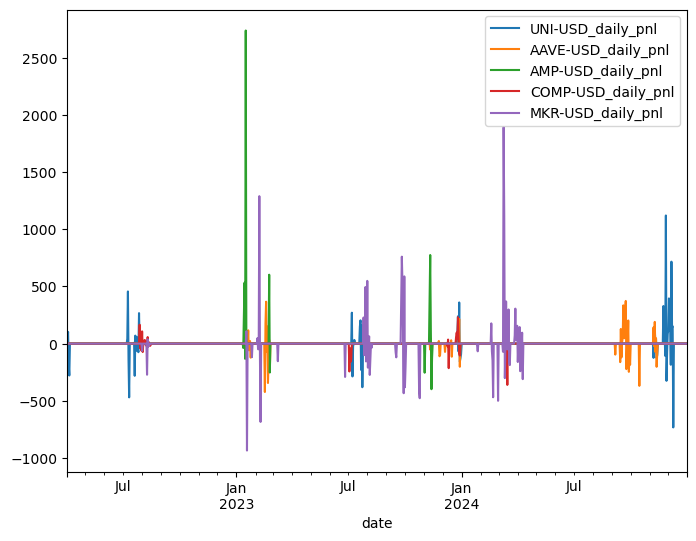

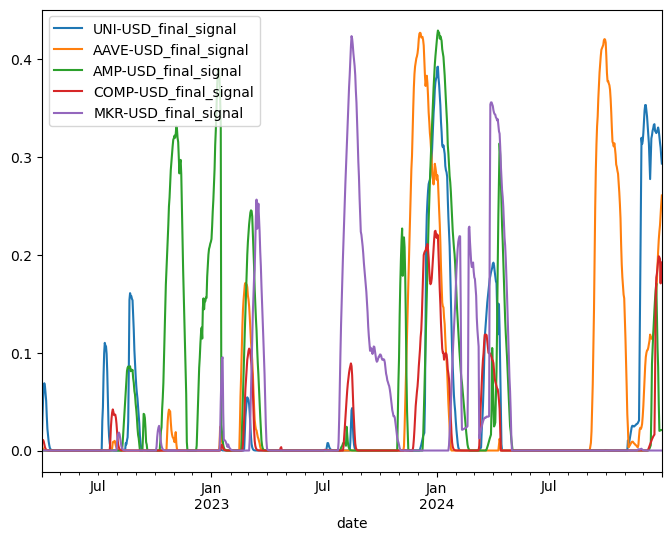

In [70]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list]
df_final_defi_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list]
df_final_defi_run_1[final_signal_cols].plot(figsize=(8,6))

### Defi Second Ticker List

In [ ]:
coinbase_start_date_by_ticker_dict = {
    ## L1 Major Coins
    'BTC-USD': '2016-01-01',  ## Core
    'ETH-USD': '2016-06-01',  ## Core
    'SOL-USD': '2021-06-01',  ## Core
    'ADA-USD': '2021-03-01',  ## Core
    'AVAX-USD': '2021-09-01', ## Core
    'DOT-USD': '2021-06-01',  ## L1 Major Run 2
    'ATOM-USD': '2020-01-01', ## L1 Major Run 2
    'LTC-USD': '2016-09-01',  ## L1 Major Run 2
    'XRP-USD': '2023-06-01',
    'ALGO-USD': '2019-08-01', ## L1 Major Run 2
    'XLM-USD': '2019-02-01',  ## L1 Major Run 2

    ## L1 Alt Coins
    'TON-USD': '2025-11-18',
    'NEAR-USD': '2022-09-01',
    'ICP-USD': '2021-05-10',  ## L1 Alt Run 1
    'HBAR-USD': '2022-10-13',
    'SUI-USD': '2023-05-18',
    'CRO-USD': '2021-11-01',  ## L1 Alt Run 1
    'APT-USD': '2022-10-19',
    'XTZ-USD': '2019-08-06',  ## L1 Alt Run 1
    'EGLD-USD': '2022-12-07',
    'FIL-USD': '2020-12-09',  ## L1 Alt Run 1
    'SEI-USD': '2023-08-15',
    'TIA-USD': '2023-11-01',
    'KAVA-USD': '2023-01-19',
    'ROSE-USD': '2022-04-26',

    ## L2 Coins
    'MATIC-USD': '2021-02-01', ## L2 Run 1
    'SKL-USD': '2021-02-01',   ## L2 Run 1
    'OP-USD': '2022-06-01',
    'ARB-USD': '2023-03-23',
    'POL-USD': '2024-09-04',
    'IMX-USD': '2021-12-09',   ## L2 Run 1
    'STRK-USD': '2024-02-21',
    'BLAST-USD': '2024-06-26',
    'ZK-USD': '2024-09-25',
    'LRC-USD': '2020-09-15',   ## L2 Run 1
    'ZORA-USD': '2025-04-24',
    'METIS-USD': '2022-06-28',
    'STX-USD': '2022-01-20',   ## L2 Run 1

    ## Meme Coins
    'DOGE-USD': '2021-06-01',
    'SHIB-USD': '2021-08-01',

    ## AI / Data / Infra Coins
    'LINK-USD': '2019-06-01',  ## AI Run 1
    'FET-USD': '2021-07-01',   ## AI Run 1
    'GRT-USD': '2020-12-01',   ## AI Run 1
    'RNDR-USD': '2022-02-03',
    'OXT-USD': '2019-12-01',   ## AI Run 1
    'AIOZ-USD': '2022-02-01',
    'MOBILE-USD': '2024-02-01',
    'HNT-USD': '2023-06-01',
    'DIA-USD': '2022-01-25',
    'KRL-USD': '2021-10-01',   ## AI Run 1
    'ZRO-USD': '2024-06-01',

    ## Stable Coins
    'USDT-USD': '2021-05-04',
    'DAI-USD': '2020-04-01',
    'USD1-USD': '2025-08-21',
    'PAX-USD': '2021-07-27',

    ## Defi Coins
    'UNI-USD': '2020-09-01',   ## Defi Run 1
    'AAVE-USD': '2020-12-01',  ## Defi Run 1
    'AMP-USD': '2021-05-01',   ## Defi Run 1
    'COMP-USD': '2020-06-23',  ## Defi Run 1
    'LDO-USD': '2022-11-17',
    'MKR-USD': '2020-06-09',   ## Defi Run 1
    'SNX-USD': '2020-12-15',   ## Defi Run 2
    'INJ-USD': '2022-09-20',
    'SUSHI-USD': '2021-03-11', ## Defi Run 2
    'CRV-USD': '2021-03-25',   ## Defi Run 2
    'BAL-USD': '2020-10-06',   ## Defi Run 2
    '1INCH-USD': '2021-04-09', ## Defi Run 2
    'RPL-USD': '2022-12-08',   
    'RSR-USD': '2025-04-22',
    'ONDO-USD': '2024-01-22',
    'ETHFI-USD': '2025-02-06',

    ## Other Coins
    'MANA-USD': '2021-04-01',
    'REQ-USD': '2021-07-01',
    'HONEY-USD': '2024-01-01'
}

In [79]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list_2 = ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD']
df_final_defi_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_2 = df_final_defi_run_2[df_final_defi_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_2 = perf.calculate_asset_level_returns(df_final_defi_run_2, end_date_test, defi_ticker_list_2)

portfolio_perf_metrics_defi_run_2 = calculate_risk_and_performance_metrics(df_final_defi_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SNX-USD
SUSHI-USD
CRV-USD
BAL-USD
1INCH-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.01181962144359261,
 'annualized_sharpe_ratio': -0.1820463568477738,
 'calmar_ratio': 0.08516058666000371,
 'annualized_std_dev': 0.3935929935515842,
 'max_drawdown': -0.1387921561740929,
 'max_drawdown_duration': Timedelta('668 days 00:00:00'),
 'hit_rate': 0.08449304174950298,
 't_statistic': 0.2522756024022899,
 'p_value': 0.8008796280739587,
 'trade_count': 103.0}

<Axes: xlabel='date'>

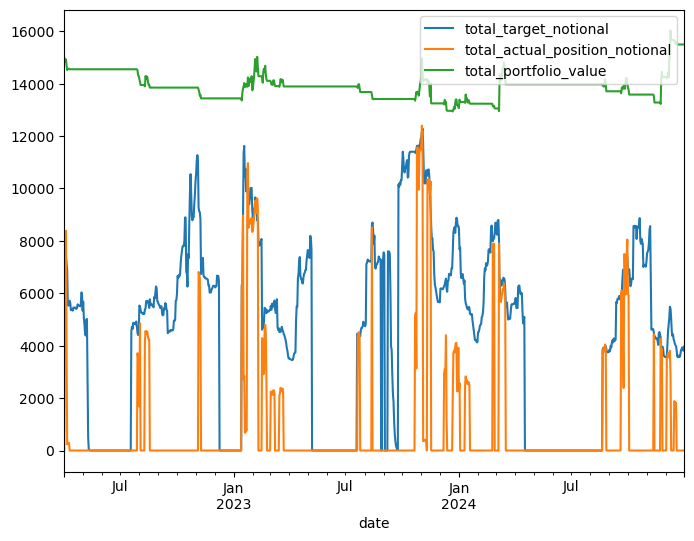

In [80]:
df_final_defi_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

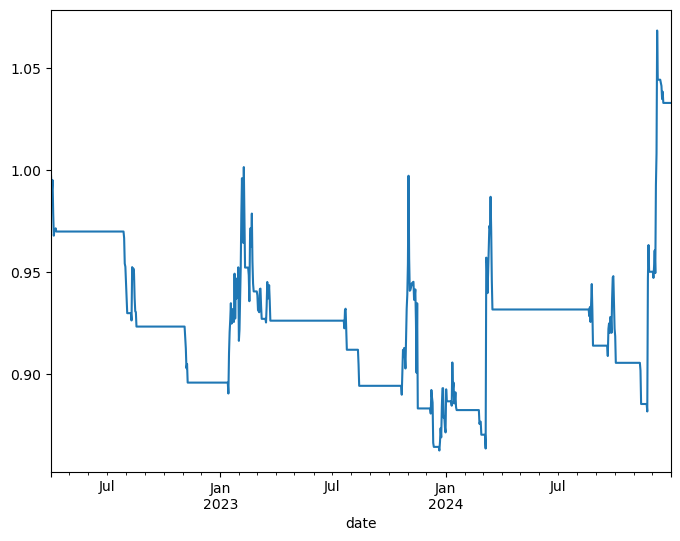

In [81]:
df_final_defi_run_2['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

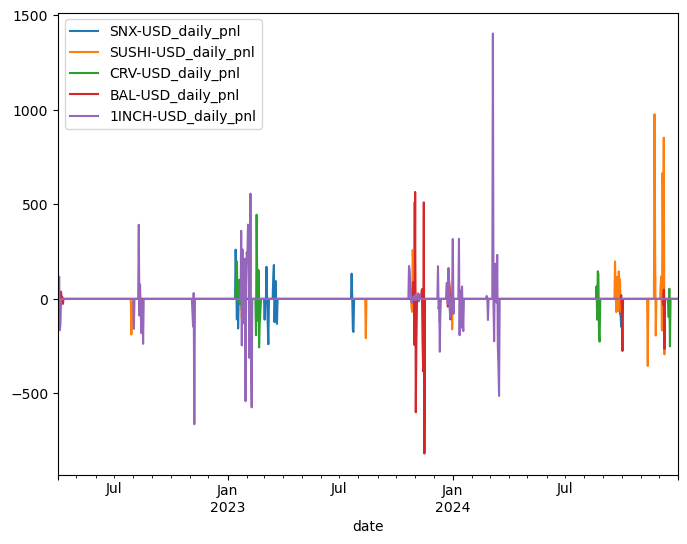

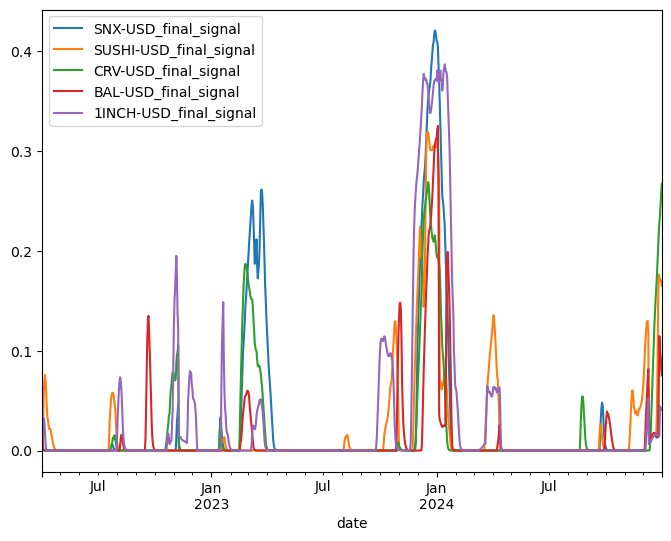

In [82]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list_2]
df_final_defi_run_2[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list_2]
df_final_defi_run_2[final_signal_cols].plot(figsize=(8,6))

## Cluster Level Portfolio Analysis

In [85]:
ANN_DAYS = 365
ASSET_RET_SUFFIX = "_daily_pct_returns"  # if you need asset-level stuff later

# 1. Put all your sleeve DFs in a dict
sleeves = {
    "core_L1_run1": df_final_prod_config,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      df_final_l1_run_2,
    "L1_alt_run1":  df_final_l1_alt_run_1,
    "L2_run1":      df_final_l2_run_1,
    "AI_run1":      df_final_ai_run_1,
    "DeFi_run1":    df_final_defi_run_1,
    "DeFi_run2":    df_final_defi_run_2
}

# 2. Build DataFrames of daily portfolio returns and position counts per sleeve
sleeve_ret = pd.concat(
    {name: df["portfolio_daily_pct_returns"] for name, df in sleeves.items()},
    axis=1
).dropna(how="all")
sleeve_ret.columns = sleeve_ret.columns.get_level_values(0)

sleeve_count = pd.concat(
    {name: df["count_of_positions"] for name, df in sleeves.items()},
    axis=1
).reindex(index=sleeve_ret.index)  # align with returns
sleeve_count.columns = sleeve_count.columns.get_level_values(0)

# 3. Correlation matrix between sleeves (unchanged)
sleeve_corr = sleeve_ret.corr()

# 4. Function to compute combined sleeve portfolio with arbitrary weights
def combine_sleeves(sleeve_ret, sleeve_count, weights):
    """
    sleeve_ret:   DataFrame [date x sleeve_name] of daily portfolio returns by sleeve
    sleeve_count: DataFrame [date x sleeve_name] of count_of_positions by sleeve
    weights:      dict {sleeve_name: weight} (will be normalized)
    """
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()

    # Combined returns: weighted sum of sleeve returns
    combined_ret = (sleeve_ret[w.index] * w).sum(axis=1)

    # Combined "active day" indicator: any sleeve has positions
    # You can keep it as a count if you want, but for your vol filter
    # only != 0 matters.
    combined_count = (sleeve_count[w.index] != 0).any(axis=1).astype(int)

    return combined_ret, combined_count

def summarize_strategy(daily_ret, trade_count, ann_days=ANN_DAYS):
    """
    daily_ret:   pd.Series of portfolio_daily_pct_returns
    trade_count: pd.Series of count_of_positions (same index as daily_ret)
    """

    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": daily_ret,
            "count_of_positions": trade_count,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # no TC adjustment for this combined series
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
        annual_trading_days=ann_days,
    )

    return {
        "annualized_return":       perf_metrics["annualized_return"],
        "annualized_std_dev":      perf_metrics["annualized_std_dev"],
        "annualized_sharpe_ratio": perf_metrics["annualized_sharpe_ratio"],
        "max_drawdown":            perf_metrics["max_drawdown"],
    }


In [86]:
## Sleeve Stats
sleeve_stats = {}
for name, df in sleeves.items():
    stats = summarize_strategy(
        daily_ret=df["portfolio_daily_pct_returns"],
        trade_count=df["count_of_positions"],
    )
    sleeve_stats[name] = stats

pd.DataFrame(sleeve_stats).T


annualized_return  annualized_std_dev  annualized_sharpe_ratio  \
core_L1_run1           0.331759            0.424726                 1.413442   
L1_run2                0.036744            0.388383                -0.000104   
L1_alt_run1            0.299827            0.727552                 1.057149   
L2_run1                0.217314            0.398622                 0.971460   
AI_run1                0.426803            2.203989                 0.702501   
DeFi_run1              0.105842            0.541912                 0.357915   
DeFi_run2              0.011820            0.393593                -0.182046   

              max_drawdown  
core_L1_run1     -0.129578  
L1_run2          -0.178037  
L1_alt_run1      -0.108076  
L2_run1          -0.076903  
AI_run1          -0.207441  
DeFi_run1        -0.193373  
DeFi_run2        -0.138792

In [87]:
sleeve_ret.head()

core_L1_run1   L1_run2  L1_alt_run1   L2_run1   AI_run1  \
date                                                                  
2022-04-01      0.000000  0.000000     0.000000  0.000000  0.000000   
2022-04-02     -0.005886 -0.002146     0.000000 -0.003039  0.000000   
2022-04-03     -0.003868  0.004092     0.000000 -0.017926 -0.001674   
2022-04-04      0.011847  0.004603    -0.005787 -0.006794 -0.002039   
2022-04-05      0.010064 -0.002329    -0.015382  0.000000 -0.009659   

            DeFi_run1  DeFi_run2  
date                              
2022-04-01   0.000000   0.000000  
2022-04-02  -0.004624  -0.005773  
2022-04-03   0.001870  -0.004063  
2022-04-04   0.005407   0.004913  
2022-04-05  -0.012087  -0.016136

<Axes: xlabel='date'>

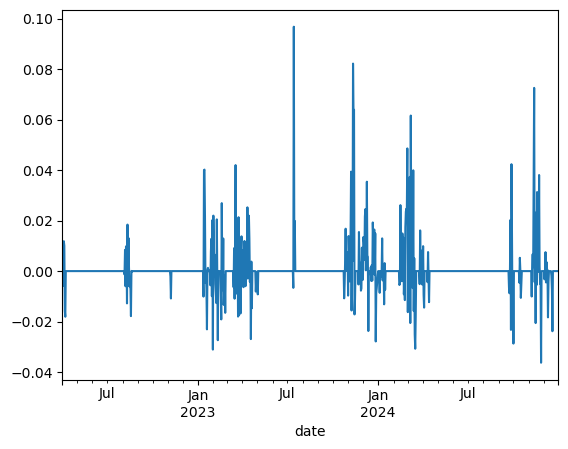

In [88]:
sleeve_ret['core_L1_run1'].plot()

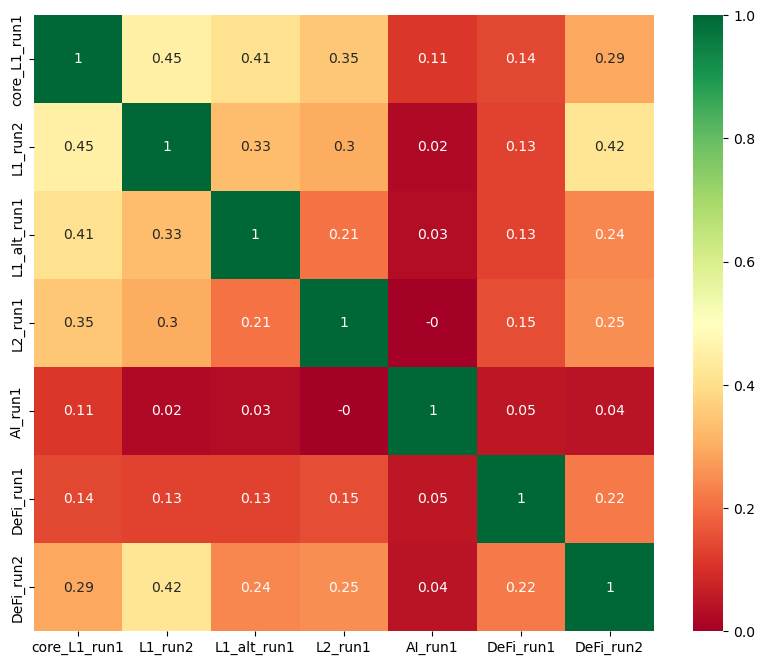

In [89]:
import seaborn as sns
plt.figure(figsize=(10, 8))
_ = sns.heatmap(sleeve_corr.round(decimals=2), annot=True, cmap='RdYlGn')
plt.show()

### Combined Portfolio Sample Performance

In [91]:
def portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Return (annualized_return, annualized_std_dev, annualized_sharpe_ratio)
    computed using *the same logic* as summarize_strategy /
    calculate_risk_and_performance_metrics.
    """
    sleeve_weights = np.array(sleeve_weights)

    # Daily portfolio return series
    port_daily_ret = (sleeve_returns[live_sleeves] @ sleeve_weights).rename("portfolio_daily_pct_returns")

    # Dummy trade-count series: Sharpe/stddev don't use it when
    # include_transaction_costs_and_fees=False, so 1 is fine.
    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": port_daily_ret,
            "count_of_positions": 1,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        annual_rf=annual_rf,
        annual_trading_days=ann_days,
        include_transaction_costs_and_fees=False,  # match your summarize_strategy usage
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
    )

    return (
        perf_metrics["annualized_return"],
        perf_metrics["annualized_std_dev"],
        perf_metrics["annualized_sharpe_ratio"],
    )

def neg_sharpe(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    return -portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)[2]  # index 2 = annualized_sharpe_ratio

In [92]:
## Core Config Performance
core_df = df_final_prod_config

core_stats = summarize_strategy(
    daily_ret=core_df["portfolio_daily_pct_returns"],
    trade_count=core_df["count_of_positions"],
)
core_stats
# should match portfolio_perf_metrics_prod_config_test for the core run


{'annualized_return': 0.3317590416631553,
 'annualized_std_dev': 0.4247262948243901,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'max_drawdown': -0.12957771858475892}

In [93]:
sleeve_weights = {
    "core_L1_run1": 0.50,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      0.00,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.20,
    "AI_run1":      0.10,
    "DeFi_run1":    0.00,
    "DeFi_run2":    0.00
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, sleeve_weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.33210068906466184,
 'annualized_std_dev': 0.2643242816795903,
 'annualized_sharpe_ratio': 1.6709973021824138,
 'max_drawdown': -0.08889379789892132}

In [94]:
## Combined Portfolio Sample - Equal Weight
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [0.25, 0.25, 0.25, 0.25]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

(0.35168508096736595, 0.19013872669613052, 1.415612517623156)

In [95]:
## Portfolio with No Diversification, just the Core Coin Config
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [1.0, 0.0, 0.0, 0.0]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

(0.3317590416631553, 0.17937067325031214, 1.4134421786840479)

### Optimizer to Calculate the Weights for Each Sleeve to get Best Performance

In [97]:
from scipy.optimize import minimize

# -------------------------------------------------------------------
# SciPy optimization with different core upper bounds
# -------------------------------------------------------------------

# Example: sleeves you’re including in the optimization
# live_sleeves order must match the columns of `sleeve_returns`
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]  # adjust to your keys
n_sleeves = len(live_sleeves)

# Name of the core sleeve and its index
CORE_NAME = "core_L1_run1"                         # adjust if different
core_idx = live_sleeves.index(CORE_NAME)

# Common constraints:
# 1) Sum of weights == 1
# 2) Core weight >= 0.40
constraints = [
    {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
    {"type": "ineq", "fun": lambda w, idx=core_idx: w[idx] - 0.40},
]

def make_initial_guess(core_idx, n, core_min=0.40):
    """
    Simple feasible starting point:
    - core at core_min
    - remaining capital equally split across non-core sleeves
    """
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min
    return w0

def make_bounds(core_idx, core_max, other_max=0.5):
    """
    Build bounds list for minimize:
    - core in [0, core_max] but with separate constraint enforcing >= 0.40
    - others in [0, other_max]
    """
    bnds = []
    for i in range(n_sleeves):
        if i == core_idx:
            bnds.append((0.0, core_max))
        else:
            bnds.append((0.0, other_max))
    return bnds

def run_optimization_for_core_max(core_max, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Run max-Sharpe optimization for a given core upper bound.
    """
    n_sleeves = len(live_sleeves)
    w0 = make_initial_guess(core_idx, n_sleeves, core_min=0.40)
    bounds = make_bounds(core_idx, core_max=core_max, other_max=0.5)

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    ann_ret, ann_vol, ann_sharpe = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    return pd.Series(w_opt, index=live_sleeves, name=f"weights_core_max_{core_max}"), (ann_ret, ann_vol, ann_sharpe), res

# -------------------------------------------------------------------
# Run the three requested scenarios
# -------------------------------------------------------------------

# sleeve_returns should be a DataFrame with columns = live_sleeves
# e.g. df_sleeve_rets with daily sleeve portfolio returns
# sleeve_returns = df_sleeve_rets   # whatever you named it

weights_050, stats_050, res_050 = run_optimization_for_core_max(core_max=0.50, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_100, stats_100, res_100 = run_optimization_for_core_max(core_max=1.00, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_080, stats_080, res_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

live_sleeves = ['core_L1_run1', 'L1_run2', 'L1_alt_run1', 'L2_run1', 'AI_run1', 'DeFi_run1', 'DeFi_run2']
n_sleeves = len(live_sleeves)
weights_all_080, stats_all_080, res_all_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

def fmt_weights(w):
    # Works for dicts, pandas Series, or any mapping-like object
    return {k: f"{float(v):.2%}" for k, v in w.items()}

def fmt_stats(s):
    # Expecting (ann_ret, ann_vol, ann_sharpe)
    ann_ret, ann_vol, ann_sharpe = s
    return (f"{float(ann_ret):.3%}", f"{float(ann_vol):.3%}", f"{float(ann_sharpe):.3f}")

print("=== Core max 0.50 ===")
print(fmt_weights(weights_050))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_050))

print("\n=== Core max 1.00 ===")
print(fmt_weights(weights_100))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_100))

print("\n=== Core max 0.80 ===")
print(fmt_weights(weights_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_080))

print("\n=== Core max 0.80 with all sleeves ===")
print(fmt_weights(weights_all_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_all_080))

=== Core max 0.50 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 1.00 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 0.80 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 0.80 with all sleeves ===
{'core_L1_run1': '43.55%', 'L1_run2': '0.00%', 'L1_alt_run1': '20.05%', 'L2_run1': '26.48%', 'AI_run1': '7.92%', 'DeFi_run1': '2.01%', 'DeFi_run2': '0.00%'}
ann_ret, ann_vol, ann_sharpe: ('31.618%', '14.003%', '1.683')


## Optimizing the Portfolio In Sample and Testing Optimized Weights Out of Sample

In [100]:
# --- 1) Build sleeve return matrix (one column per sleeve) ---

sleeve_ret_dict = {
    "core_L1_run1": df_final_prod_config["portfolio_daily_pct_returns"],
    "L1_run2":      df_final_l1_run_2["portfolio_daily_pct_returns"],
    "L1_alt_run1":  df_final_l1_alt_run_1["portfolio_daily_pct_returns"],
    "L2_run1":      df_final_l2_run_1["portfolio_daily_pct_returns"],
    "AI_run1":      df_final_ai_run_1["portfolio_daily_pct_returns"],
    "DeFi_run1":    df_final_defi_run_1["portfolio_daily_pct_returns"],
    "DeFi_run2":    df_final_defi_run_2["portfolio_daily_pct_returns"],
}

df_sleeve_rets = pd.concat(sleeve_ret_dict, axis=1).sort_index()

# restrict to your main analysis period
df_sleeve_rets = df_sleeve_rets.loc["2022-04-01":"2024-12-31"]

In [101]:
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"
core_idx = live_sleeves.index(core_name)


In [102]:
from scipy.optimize import minimize
import numpy as np

def optimize_weights(
    sleeve_returns,
    live_sleeves,
    core_name="core_L1_run1",
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
    ann_days=ANN_DAYS,
    annual_rf=0.05,
):
    """
    Max-Sharpe weights for given sleeve_returns (e.g. train period).
    """
    live_sleeves = list(live_sleeves)
    n = len(live_sleeves)
    core_idx = live_sleeves.index(core_name)

    # constraints: sum w = 1, core >= core_min
    constraints = [
        {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w, idx=core_idx, cmin=core_min: w[idx] - cmin},
    ]

    # bounds: core in [0, core_max], others in [0, other_max]
    bounds = []
    for i in range(n):
        if i == core_idx:
            bounds.append((0.0, core_max))
        else:
            bounds.append((0.0, other_max))

    # initial guess: core at core_min, others equal share of the rest
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    train_stats = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    w_opt_series = pd.Series(w_opt, index=live_sleeves, name="opt_weights")
    return w_opt_series, train_stats, res


In [103]:
# define train / test periods
train_1_start, train_1_end = "2022-04-01", "2023-12-31"
test_1_start,  test_1_end  = "2024-01-01", "2024-12-31"

train_1 = df_sleeve_rets.loc[train_1_start:train_1_end, live_sleeves].dropna()
test_1  = df_sleeve_rets.loc[test_1_start:test_1_end, live_sleeves].dropna()

w_opt_1, train_stats_1, _ = optimize_weights(
    train_1,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_1 = portfolio_stats(w_opt_1.values, test_1, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("=== Train 2022-04-01 to 2023-12-31 ===")
print("Optimal weights:\n", w_opt_1)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_1)
print("\nApply same weights to 2024:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_1)


=== Train 2022-04-01 to 2023-12-31 ===
Optimal weights:
 core_L1_run1    0.580469
L1_alt_run1     0.121162
L2_run1         0.069736
AI_run1         0.228633
Name: opt_weights, dtype: float64
Train stats (ann_ret, ann_vol, ann_sharpe): (0.29373144552428165, 0.12985803814367072, 1.6719148021667465)

Apply same weights to 2024:
Test stats  (ann_ret, ann_vol, ann_sharpe): (0.5173171019051925, 0.272276774436241, 1.475711057146028)


In [104]:
train_2_start, train_2_end = "2023-01-01", "2024-12-31"
test_2_start,  test_2_end  = "2022-04-01", "2022-12-31"  # partial 2022

train_2 = df_sleeve_rets.loc[train_2_start:train_2_end, live_sleeves].dropna()
test_2  = df_sleeve_rets.loc[test_2_start:test_2_end, live_sleeves].dropna()

w_opt_2, train_stats_2, _ = optimize_weights(
    train_2,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_2 = portfolio_stats(w_opt_2.values, test_2, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("\n=== Train 2023-01-01 to 2024-12-31 ===")
print("Optimal weights:\n", w_opt_2)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_2)
print("\nApply same weights to 2022 slice:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_2)



=== Train 2023-01-01 to 2024-12-31 ===
Optimal weights:
 core_L1_run1    0.415478
L1_alt_run1     0.211610
L2_run1         0.305894
AI_run1         0.067018
Name: opt_weights, dtype: float64
Train stats (ann_ret, ann_vol, ann_sharpe): (0.48202897330128924, 0.16077286376055583, 2.223392899849844)

Apply same weights to 2022 slice:
Test stats  (ann_ret, ann_vol, ann_sharpe): (-0.047806308684952614, 0.040411908513482746, -2.3993696863167395)


In [105]:
full = df_sleeve_rets.loc["2022-04-01":"2024-12-31", live_sleeves].dropna()

# (1) Equal-weight 25/25/25/25
w_eq = np.full(len(live_sleeves), 1.0 / len(live_sleeves))
stats_eq = portfolio_stats(w_eq, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (2) Rule-of-thumb 50/20/20/10 (core, L1_alt, L2, AI)
w_rule = np.array([0.50, 0.20, 0.20, 0.10])
stats_rule = portfolio_stats(w_rule, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (3) Optimizer weights from full-sample run (the ones you already have)
w_opt_full = np.array([0.442794, 0.204997, 0.271550, 0.080659])
stats_opt_full = portfolio_stats(w_opt_full, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("Equal-weight stats       :", stats_eq)
print("50/20/20/10 rule stats   :", stats_rule)
print("Optimized full stats     :", stats_opt_full)


Equal-weight stats       : (0.35168508096736595, 0.19013872669613052, 1.415612517623156)
50/20/20/10 rule stats   : (0.33210068906466095, 0.14892683394785938, 1.6709973021824132)
Optimized full stats     : (0.3200941040612162, 0.1420131316220806, 1.6819528279414697)


In [106]:
# No core floor (core_min=0), others capped at 0.7
w_no_core_floor, stats_no_core_floor, _ = optimize_weights(
    full,
    live_sleeves,
    core_name=core_name,
    core_min=0.0,
    core_max=1.0,
    other_max=0.70,
)

print("\n=== No core floor, others <= 0.70 ===")
print("Weights:\n", w_no_core_floor)
print("Stats (ann_ret, ann_vol, ann_sharpe):", stats_no_core_floor)



=== No core floor, others <= 0.70 ===
Weights:
 core_L1_run1    0.443007
L1_alt_run1     0.204999
L2_run1         0.271392
AI_run1         0.080602
Name: opt_weights, dtype: float64
Stats (ann_ret, ann_vol, ann_sharpe): (0.32009986698812676, 0.14201599096973105, 1.6819527932021543)


### Rolling Weight Optimization

In [108]:
# We’ll use the same live_sleeves and optimizer
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"

# Full sleeve return matrix (already restricted to 2022-04-01..2024-12-31)
rets_all = df_sleeve_rets[live_sleeves].dropna()

lookback_days = 365
rebal_dates = pd.date_range("2022-04-01", "2024-12-31", freq="M")  # month-end

weights_history = []
perf_history = []

for reb_date in rebal_dates:
    if reb_date <= rets_all.index[0] + pd.Timedelta(days=lookback_days):
        continue  # not enough history yet

    train_end = reb_date
    train_start = train_end - pd.Timedelta(days=lookback_days)

    train = rets_all.loc[train_start:train_end]

    if len(train) < 200:  # safety guard
        continue

    # Optimize on trailing year
    w_opt, train_stats, _ = optimize_weights(
        sleeve_returns=train,
        live_sleeves=live_sleeves,
        core_name=core_name,
        core_min=0.40,
        core_max=1.00,
        other_max=0.50,
        ann_days=ANN_DAYS,
        annual_rf=0.05,
    )

    # Apply weights to the *next* month as a simple walk-forward test
    test_start = reb_date + pd.Timedelta(days=1)
    # end of next month or data end, whichever earlier
    test_end = min(
        (reb_date + pd.offsets.MonthEnd(1)).to_pydatetime(),
        rets_all.index[-1].to_pydatetime(),
    )
    test = rets_all.loc[test_start:test_end]

    if len(test) == 0:
        continue

    test_stats = portfolio_stats(w_opt.values, test, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

    weights_history.append(
        {"date": reb_date, **{s: w_opt[s] for s in live_sleeves}}
    )
    perf_history.append(
        {
            "date": reb_date,
            "train_ann_ret":  train_stats[0],
            "train_ann_vol":  train_stats[1],
            "train_sharpe":   train_stats[2],
            "test_ann_ret":   test_stats[0],
            "test_ann_vol":   test_stats[1],
            "test_sharpe":    test_stats[2],
        }
    )

weights_df = pd.DataFrame(weights_history).set_index("date")
perf_df = pd.DataFrame(perf_history).set_index("date")


<Axes: xlabel='date'>

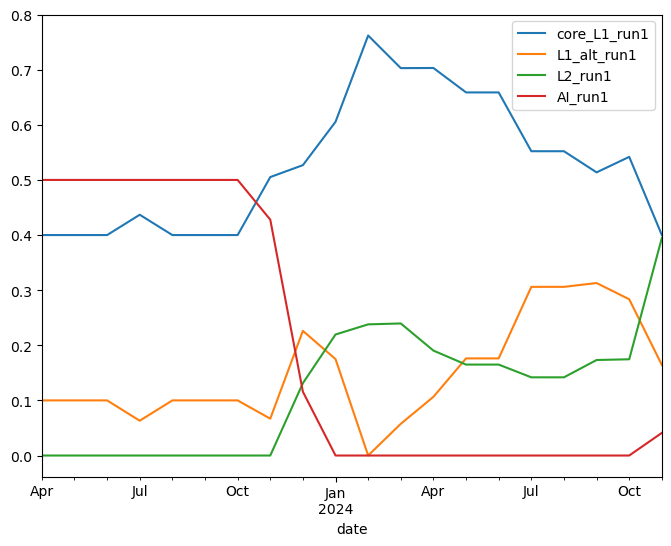

In [109]:
weights_df.plot(figsize=(8,6))

In [110]:
weights_df

core_L1_run1   L1_alt_run1       L2_run1       AI_run1
date                                                              
2023-04-30      0.400000  1.000000e-01  2.220446e-16  5.000000e-01
2023-05-31      0.400000  1.000000e-01  3.885781e-16  5.000000e-01
2023-06-30      0.400000  1.000000e-01  3.885781e-16  5.000000e-01
2023-07-31      0.436857  6.314296e-02  0.000000e+00  5.000000e-01
2023-08-31      0.400000  1.000000e-01  0.000000e+00  5.000000e-01
2023-09-30      0.400000  1.000000e-01  2.505320e-17  5.000000e-01
2023-10-31      0.400000  1.000000e-01  0.000000e+00  5.000000e-01
2023-11-30      0.505197  6.684754e-02  0.000000e+00  4.279553e-01
2023-12-31      0.526850  2.261692e-01  1.312901e-01  1.156911e-01
2024-01-31      0.605489  1.749074e-01  2.196036e-01  2.974780e-18
2024-02-29      0.762028  1.981379e-17  2.379717e-01  3.757356e-17
2024-03-31      0.702868  5.753428e-02  2.395974e-01  0.000000e+00
2024-04-30      0.703125  1.065075e-01  1.903673e-01  1.835256e-16
2024-05-31      0.658797  1.762137e-01  1.649894e-01  0.000000e+00
2024-06-30      0.658797  1.762138e-01  1.649891e-01  3.363206e-17
2024-07-31      0.552095  3.060284e-01  1.418762e-01  1.143981e-15
2024-08-31      0.552096  3.060280e-01  1.418763e-01  0.000000e+00
2024-09-30      0.513742  3.129561e-01  1.733017e-01  1.506526e-15
2024-10-31      0.541870  2.835086e-01  1.746214e-01  2.741371e-16
2024-11-30      0.400000  1.643260e-01  3.945978e-01  4.107623e-02

In [111]:
perf_df

train_ann_ret  train_ann_vol  train_sharpe  test_ann_ret  \
date                                                                   
2023-04-30       0.184561       0.105948      1.190600     -0.076207   
2023-05-31       0.176635       0.106085      1.125878      0.000000   
2023-06-30       0.176635       0.106085      1.125878      1.296572   
2023-07-31       0.266800       0.124976      1.563789      0.000000   
2023-08-31       0.258989       0.116928      1.610269      0.000000   
2023-09-30       0.258989       0.116928      1.610269      0.206975   
2023-10-31       0.279210       0.117422      1.739762      4.728255   
2023-11-30       0.503800       0.155289      2.390662      0.830761   
2023-12-31       0.599283       0.163816      2.650750     -0.155372   
2024-01-31       0.495785       0.166750      2.205064      4.187839   
2024-02-29       0.883391       0.185783      3.238350      0.905804   
2024-03-31       0.863087       0.186870      3.162720     -0.277039   
2024-04-30       0.779032       0.182869      2.975020      0.000000   
2024-05-31       0.763262       0.175716      3.038298      0.000000   
2024-06-30       0.763262       0.175716      3.038298      0.000000   
2024-07-31       0.608980       0.153228      2.862499      0.000000   
2024-08-31       0.608980       0.153228      2.862499      0.241938   
2024-09-30       0.625297       0.155033      2.896220     -0.266876   
2024-10-31       0.531518       0.156838      2.485220     12.658762   
2024-11-30       0.591204       0.157546      2.717325     -0.336717   

            test_ann_vol  test_sharpe  
date                                   
2023-04-30      0.016115    -7.938436  
2023-05-31      0.000000         -inf  
2023-06-30      0.215816     3.732504  
2023-07-31      0.000000         -inf  
2023-08-31      0.000000         -inf  
2023-09-30      0.039637     3.535364  
2023-10-31      0.328848     5.328623  
2023-11-30      0.176297     3.241407  
2023-12-31      0.061128    -3.530367  
2024-01-31      0.193405     8.371221  
2024-02-29      0.296216     2.156322  
2024-03-31      0.076692    -4.826950  
2024-04-30      0.000000         -inf  
2024-05-31      0.000000         -inf  
2024-06-30      0.000000         -inf  
2024-07-31      0.000000         -inf  
2024-08-31      0.139063     1.274490  
2024-09-30      0.056036    -6.381096  
2024-10-31      0.461309     5.792310  
2024-11-30      0.091863    -4.952856

## Running the Portfolio with the Most Optimal Weights

In [113]:
import pandas as pd
import numpy as np

# ---- Inputs ----

crypto_portfolio_ticker_dict = {
    'core_L1_run1': ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves you actually want in the live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000  # across all sleeves

start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# ---- Helper to run one sleeve ----

def run_sleeve_backtest(
    sleeve_name,
    ticker_list,
    sleeve_initial_capital,
    start_date_test,
    end_date_test,
):
    """
    Runs your production config for a given sleeve and returns the full df
    (with asset-level returns already computed).
    """

    df = fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut off warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- Run all live sleeves ----

sleeve_dfs = {}

for sleeve_name, weight in sleeve_weights_live.items():
    ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=ticker_list,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
    )
    sleeve_dfs[sleeve_name] = df_sleeve


Running core_L1_run1 with capital 6,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Running L1_alt_run1 with capital 3,000.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Running L2_run1 with capital 3,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Running AI_run1 with capital 1,

In [114]:
# ---- Build combined portfolio from sleeves (capital-consistent) ----

value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    # you may need to adjust these column names to match your actual df
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series, axis=1).sort_index()
df_pos   = pd.concat(pos_series, axis=1).sort_index()

# P&L_i,t = V_{i,t-1} * r_{i,t}
df_pnl = df_value.shift(1) * df_rets

# Total portfolio value and P&L
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

# Combined daily return: P&L_t / V_{t-1}
combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)

combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)

# Rebuild combined portfolio value from returns for sanity check
total_initial_capital = 15000.0  # sum of sleeves' starting caps
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

# Now compute performance metrics for the combined portfolio
combined_perf_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)

combined_perf_metrics


{'annualized_return': 0.30877078188377194,
 'annualized_sharpe_ratio': 1.6403619129119422,
 'calmar_ratio': 3.3498620118108637,
 'annualized_std_dev': 0.28029575158531067,
 'max_drawdown': -0.0921741793527958,
 'max_drawdown_duration': Timedelta('287 days 00:00:00'),
 'hit_rate': 0.16600397614314116,
 't_statistic': 3.3009912694334202,
 'p_value': 0.000997333940087211,
 'trade_count': 402.0}

In [115]:
df_combined.head()

portfolio_daily_pct_returns  count_of_positions  \
date                                                          
2022-04-01                     0.000000                 0.0   
2022-04-02                    -0.003408                 2.0   
2022-04-03                    -0.006387                 1.0   
2022-04-04                     0.002278                 3.0   
2022-04-05                     0.000521                 1.0   

            total_portfolio_value  strategy_cumulative_return  equity_curve  \
date                                                                          
2022-04-01           15000.000000                    0.000000      1.000000   
2022-04-02           14948.872855                   -0.003408      0.996592   
2022-04-03           14853.387522                   -0.009774      0.990226   
2022-04-04           14887.221123                   -0.007519      0.992481   
2022-04-05           14894.976139                   -0.007002      0.992998   

            equity_curve_cum_max  drawdown  drawdown_pct        End  Start  \
date                                                                         
2022-04-01                   1.0  0.000000      0.000000 2022-04-01      1   
2022-04-02                   1.0 -0.003408     -0.003408 2022-04-02      1   
2022-04-03                   1.0 -0.009774     -0.009774 2022-04-03      1   
2022-04-04                   1.0 -0.007519     -0.007519 2022-04-04      1   
2022-04-05                   1.0 -0.007002     -0.007002 2022-04-05      1   

           equity_curve_DDDuration  profitable_trade  
date                                                  
2022-04-01                287 days             False  
2022-04-02                287 days             False  
2022-04-03                287 days             False  
2022-04-04                287 days              True  
2022-04-05                287 days              True

<Axes: xlabel='date'>

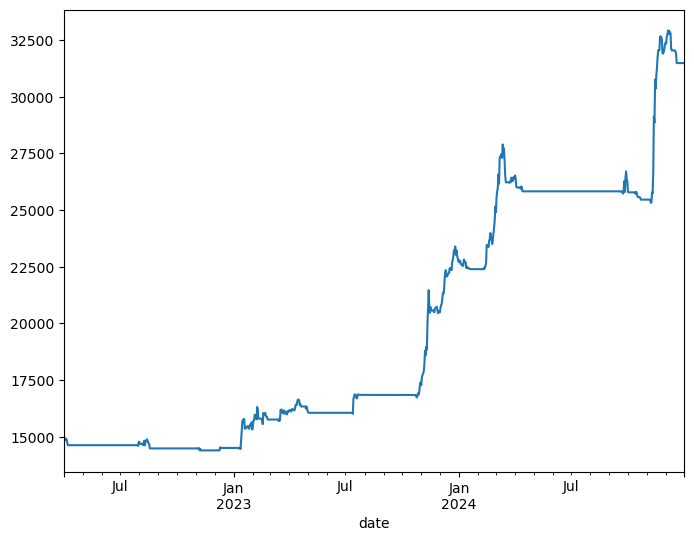

In [116]:
df_combined['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

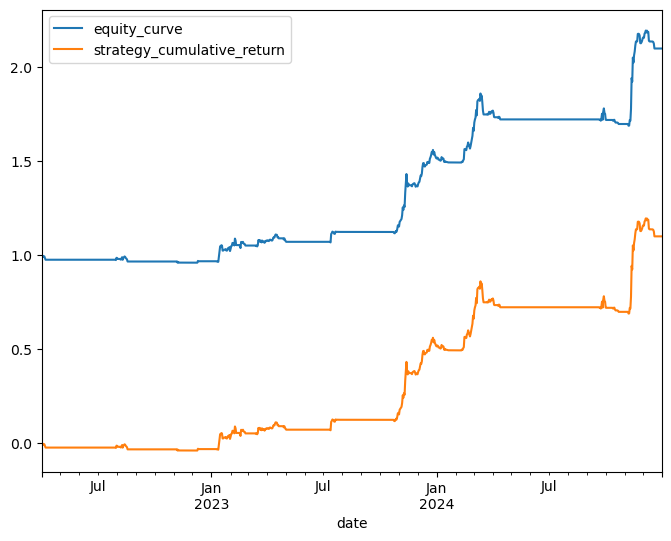

In [117]:
df_combined[['equity_curve','strategy_cumulative_return']].plot(figsize=(8,6))

## Testing Different Volatility Targets

In [119]:
sleeve_weights_live

{'core_L1_run1': 0.45, 'L1_alt_run1': 0.2, 'L2_run1': 0.25, 'AI_run1': 0.1}

In [120]:
total_initial_capital

15000.0

In [121]:
target_vol_grid = [0.30, 0.45, 0.60, 0.75, 0.90]

results = {}

for tv in target_vol_grid:
    print(f"\n=== Running with annualized_target_volatility = {tv} ===")
    annualized_target_volatility = tv  # update global config param used inside run_sleeve_backtest

    # ---- 1) Re-run all sleeves at this target vol ----
    sleeve_dfs = {}

    for sleeve_name, weight in sleeve_weights_live.items():
        ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
        sleeve_capital = total_initial_capital * weight
        df_sleeve = run_sleeve_backtest(
            sleeve_name=sleeve_name,
            ticker_list=ticker_list,
            sleeve_initial_capital=sleeve_capital,
            start_date_test=start_date_test,
            end_date_test=end_date_test,
        )
        sleeve_dfs[sleeve_name] = df_sleeve

    # ---- 2) Build combined portfolio using P&L / total value ----

    # Collect per-sleeve value, returns, positions
    value_series = {}
    ret_series   = {}
    pos_series   = {}

    for sleeve_name, df in sleeve_dfs.items():
        value_series[sleeve_name] = df["total_portfolio_value"]
        ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
        pos_series[sleeve_name]   = df["count_of_positions"]

    df_value = pd.concat(value_series, axis=1).sort_index()
    df_rets  = pd.concat(ret_series,   axis=1).sort_index()
    df_pos   = pd.concat(pos_series,   axis=1).sort_index()

    # Sleeve-level P&L: PnL_i,t = V_{i,t-1} * r_{i,t}
    df_pnl = df_value.shift(1) * df_rets

    # Aggregate to portfolio level
    total_value = df_value.sum(axis=1)       # V_t = sum_i V_{i,t}
    total_pnl   = df_pnl.sum(axis=1)        # PnL_t = sum_i PnL_{i,t}

    # Combined daily return: r_t = PnL_t / V_{t-1}
    combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)

    # Total count of positions across sleeves (for your metrics function)
    combined_positions = df_pos.sum(axis=1)

    df_combined = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": combined_daily_ret,
            "count_of_positions": combined_positions,
        }
    )

    # Rebuild combined portfolio value path from combined returns (sanity check)
    df_combined["total_portfolio_value"] = (
        total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
    )

    # ---- 3) Compute performance metrics for this target vol ----
    metrics = perf.calculate_risk_and_performance_metrics(
        df_combined,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    results[tv] = metrics

results



=== Running with annualized_target_volatility = 0.3 ===
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting A

{0.3: {'annualized_return': 0.2141908552168923,
  'annualized_sharpe_ratio': 1.5599423777021546,
  'calmar_ratio': 3.7452843775437166,
  'annualized_std_dev': 0.19497735841210556,
  'max_drawdown': -0.05718947711985648,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.15904572564612326,
  't_statistic': 3.432926679000225,
  'p_value': 0.0006214502392806078,
  'trade_count': 311.0},
 0.45: {'annualized_return': 0.30877078188377194,
  'annualized_sharpe_ratio': 1.6403619129119422,
  'calmar_ratio': 3.3498620118108637,
  'annualized_std_dev': 0.28029575158531067,
  'max_drawdown': -0.0921741793527958,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.3009912694334202,
  'p_value': 0.000997333940087211,
  'trade_count': 402.0},
 0.6: {'annualized_return': 0.37313383470232253,
  'annualized_sharpe_ratio': 1.6744086525780029,
  'calmar_ratio': 3.1317645650009096,
  'annualized_std_dev': 0.327385517187060

In [190]:
sleeve_dfs.keys()

dict_keys(['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1'])

In [188]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


{'annualized_return': 0.4353136828632598,
 'annualized_sharpe_ratio': 1.4196210250282826,
 'calmar_ratio': 2.6510873379365556,
 'annualized_std_dev': 0.5287594302415308,
 'max_drawdown': -0.16420193957173865,
 'max_drawdown_duration': Timedelta('284 days 00:00:00'),
 'hit_rate': 0.13817097415506957,
 't_statistic': 2.6943516428035665,
 'p_value': 0.007170154187187536,
 'trade_count': 166.0}

In [192]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


{'annualized_return': 0.48577822036864404,
 'annualized_sharpe_ratio': 1.1629681834513577,
 'calmar_ratio': 4.250687409648138,
 'annualized_std_dev': 1.088335543709115,
 'max_drawdown': -0.11428227332502337,
 'max_drawdown_duration': Timedelta('246 days 00:00:00'),
 'hit_rate': 0.08349900596421471,
 't_statistic': 2.166735309575042,
 'p_value': 0.030489439712285887,
 'trade_count': 108.0}

In [194]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


{'annualized_return': 0.33499314089470267,
 'annualized_sharpe_ratio': 1.029412132573316,
 'calmar_ratio': 1.8693493386539295,
 'annualized_std_dev': 0.6764204234292978,
 'max_drawdown': -0.17920307027038757,
 'max_drawdown_duration': Timedelta('269 days 00:00:00'),
 'hit_rate': 0.10139165009940358,
 't_statistic': 2.012501042501486,
 'p_value': 0.04443352077852961,
 'trade_count': 107.0}

In [196]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


{'annualized_return': 0.6494608924525409,
 'annualized_sharpe_ratio': 0.8638265568355409,
 'calmar_ratio': 1.917952279423808,
 'annualized_std_dev': 2.3756391157420613,
 'max_drawdown': -0.33862202903591127,
 'max_drawdown_duration': Timedelta('367 days 00:00:00'),
 'hit_rate': 0.07157057654075547,
 't_statistic': 1.546470710765282,
 'p_value': 0.12230574620288176,
 'trade_count': 110.0}

In [122]:
results

{0.3: {'annualized_return': 0.2141908552168923,
  'annualized_sharpe_ratio': 1.5599423777021546,
  'calmar_ratio': 3.7452843775437166,
  'annualized_std_dev': 0.19497735841210556,
  'max_drawdown': -0.05718947711985648,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.15904572564612326,
  't_statistic': 3.432926679000225,
  'p_value': 0.0006214502392806078,
  'trade_count': 311.0},
 0.45: {'annualized_return': 0.30877078188377194,
  'annualized_sharpe_ratio': 1.6403619129119422,
  'calmar_ratio': 3.3498620118108637,
  'annualized_std_dev': 0.28029575158531067,
  'max_drawdown': -0.0921741793527958,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.3009912694334202,
  'p_value': 0.000997333940087211,
  'trade_count': 402.0},
 0.6: {'annualized_return': 0.37313383470232253,
  'annualized_sharpe_ratio': 1.6744086525780029,
  'calmar_ratio': 3.1317645650009096,
  'annualized_std_dev': 0.327385517187060

In [176]:
df_combined.head()

portfolio_daily_pct_returns  count_of_positions  \
date                                                          
2022-04-01                     0.000000                 0.0   
2022-04-02                    -0.006540                 3.0   
2022-04-03                    -0.011440                 1.0   
2022-04-04                     0.003827                 4.0   
2022-04-05                     0.000476                 1.0   

            total_portfolio_value  strategy_cumulative_return  equity_curve  \
date                                                                          
2022-04-01           15000.000000                    0.000000      1.000000   
2022-04-02           14901.893795                   -0.006540      0.993460   
2022-04-03           14731.423416                   -0.017905      0.982095   
2022-04-04           14787.800461                   -0.014147      0.985853   
2022-04-05           14794.839871                   -0.013677      0.986323   

            equity_curve_cum_max  drawdown  drawdown_pct        End  Start  \
date                                                                         
2022-04-01                   1.0  0.000000      0.000000 2022-04-01      1   
2022-04-02                   1.0 -0.006540     -0.006540 2022-04-02      1   
2022-04-03                   1.0 -0.017905     -0.017905 2022-04-03      1   
2022-04-04                   1.0 -0.014147     -0.014147 2022-04-04      1   
2022-04-05                   1.0 -0.013677     -0.013677 2022-04-05      1   

           equity_curve_DDDuration  profitable_trade  
date                                                  
2022-04-01                287 days             False  
2022-04-02                287 days             False  
2022-04-03                287 days             False  
2022-04-04                287 days              True  
2022-04-05                287 days              True

In [186]:
perf.calculate_annualized_std_dev(df_combined, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',annual_trading_days=365, include_transaction_costs_and_fees=False)

0.3691497702331249

<Axes: xlabel='date'>

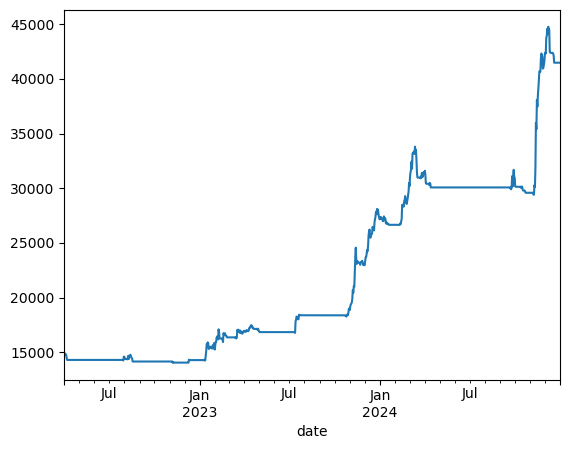

In [198]:
df_combined['total_portfolio_value'].plot()

<Axes: xlabel='date'>

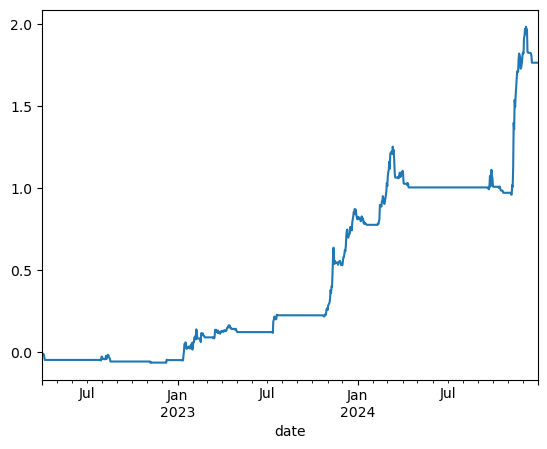

In [202]:
df_combined['strategy_cumulative_return'].plot()

## Choosing a Vol Target of 0.75, run backtests for different time periods to verify performance

In [205]:
import numpy as np
import pandas as pd

# --- 1) Fix target vol and run the four sleeves ---

annualized_target_volatility = 0.75  # base case

sleeve_dfs = {}
for sleeve_name, weight in sleeve_weights_live.items():
    ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Running {sleeve_name} at target vol {annualized_target_volatility}, capital={sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=ticker_list,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
    )
    sleeve_dfs[sleeve_name] = df_sleeve

# --- 2) Build capital-consistent combined portfolio (P&L / total value) ---

value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

# Sleeve P&L_i,t = V_{i,t-1} * r_{i,t}
df_pnl = df_value.shift(1) * df_rets

# Aggregate
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

# Combined daily return
combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)

# Rebuild combined portfolio value for sanity
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

# --- 3) Full-period performance (base case, TC=0.001) ---

base_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # same convention as earlier
    transaction_cost_est=transaction_cost_est,  # e.g. 0.001
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)

base_metrics


Running core_L1_run1 at target vol 0.75, capital=6,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Running L1_alt_run1 at target vol 0.75, capital=3,000.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Running L2_run1 at target vol 0.75, capital=3,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio 

{'annualized_return': 0.42006820538371215,
 'annualized_sharpe_ratio': 1.718503945866282,
 'calmar_ratio': 3.2384422987565626,
 'annualized_std_dev': 0.35003674214508546,
 'max_drawdown': -0.1297130430716651,
 'max_drawdown_duration': Timedelta('287 days 00:00:00'),
 'hit_rate': 0.16600397614314116,
 't_statistic': 3.2895499013729212,
 'p_value': 0.0010383247620364274,
 'trade_count': 473.0}

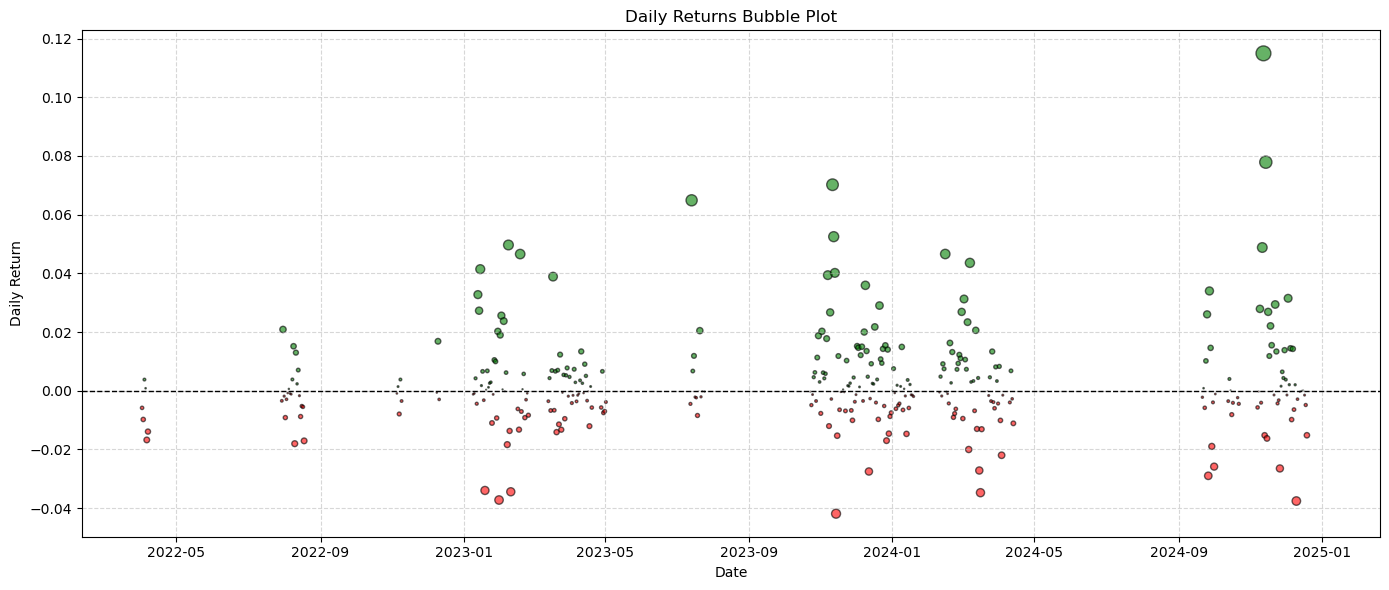

In [237]:
perf.plot_daily_returns_bubble(df_combined, return_col='portfolio_daily_pct_returns')

## Strategy Performance Broken down by Year

In [239]:
## Performance Per Year at a Target Volatility of 0.75
yearly_results = {}

for year in [2022, 2023, 2024]:
    df_year = df_combined.loc[str(year)]
    if df_year.empty:
        continue

    metrics_year = perf.calculate_risk_and_performance_metrics(
        df_year,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # or True if you want net-of-TC
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    yearly_results[year] = metrics_year

yearly_results


{2022: {'annualized_return': -0.06415566106244786,
  'annualized_sharpe_ratio': -1.86654764242518,
  'calmar_ratio': -1.038877127304708,
  'annualized_std_dev': 0.1515854962387466,
  'max_drawdown': -0.061754811398047726,
  'max_drawdown_duration': Timedelta('274 days 00:00:00'),
  'hit_rate': 0.04363636363636364,
  't_statistic': -0.9221748870910091,
  'p_value': 0.3572486430060857,
  'trade_count': 57.0},
 2023: {'annualized_return': 0.8515680584826792,
  'annualized_sharpe_ratio': 2.777432974568123,
  'calmar_ratio': 12.90039657374889,
  'annualized_std_dev': 0.3319850065532436,
  'max_drawdown': -0.0660109984692673,
  'max_drawdown_duration': Timedelta('97 days 00:00:00'),
  'hit_rate': 0.2465753424657534,
  't_statistic': 3.0071703885592855,
  'p_value': 0.0028201317071704286,
  'trade_count': 230.0},
 2024: {'annualized_return': 0.4909743316062021,
  'annualized_sharpe_ratio': 1.7319010420241328,
  'calmar_ratio': 3.785080667138042,
  'annualized_std_dev': 0.4073423084743028,
  '

In [241]:
import numpy as np

# Rolling windows in trading days
win_3m = 63   # ~ 3 months
win_6m = 126  # ~ 6 months

ret    = df_combined["portfolio_daily_pct_returns"]
trades = df_combined["count_of_positions"]

def rolling_sharpe_like_perf(
    returns,
    trades,
    window,
    annual_trading_days=annual_trading_days,  # e.g. 365
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
):
    """
    Rolling annualized Sharpe computed the same way as
    calculate_sharpe_ratio in strategy_performance.py.
    """
    # daily risk-free
    daily_rf = (1.0 + annual_rf) ** (1.0 / annual_trading_days) - 1.0

    # daily cost (if enabled)
    if include_transaction_costs_and_fees:
        # use the same fee estimate function from your perf module
        avg_fee_per_trade = perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        daily_cost = np.abs(trades) * (transaction_cost_est + avg_fee_per_trade)
    else:
        daily_cost = 0.0

    # excess return series (ret - cost - rf)
    excess = returns - daily_cost - daily_rf

    # rolling function: mean/std of excess, then annualize
    def sharpe_from_window(x):
        mu = x.mean()
        sd = x.std()
        if sd == 0 or np.isnan(sd):
            return np.nan
        daily_sharpe = mu / sd
        return daily_sharpe * np.sqrt(annual_trading_days)

    return excess.rolling(window).apply(sharpe_from_window, raw=False)

# 3M and 6M rolling Sharpe (no costs, to match how you usually call summarize_strategy)
df_combined["rolling_3m_ann_sharpe"] = rolling_sharpe_like_perf(
    returns=ret,
    trades=trades,
    window=win_3m,
    annual_trading_days=annual_trading_days,
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,   # set True if you want cost-adjusted Sharpe
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
)

df_combined["rolling_6m_ann_sharpe"] = rolling_sharpe_like_perf(
    returns=ret,
    trades=trades,
    window=win_6m,
    annual_trading_days=annual_trading_days,
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
)

# Rolling realized vol (unchanged, same math as your annualized_std_dev)
roll_std_3m = ret.rolling(win_3m).std(ddof=1)
roll_std_6m = ret.rolling(win_6m).std(ddof=1)

df_combined["rolling_3m_ann_vol"] = roll_std_3m * np.sqrt(annual_trading_days)
df_combined["rolling_6m_ann_vol"] = roll_std_6m * np.sqrt(annual_trading_days)

# Rolling average positions (unchanged)
df_combined["rolling_3m_avg_positions"] = trades.rolling(win_3m).mean()
df_combined["rolling_6m_avg_positions"] = trades.rolling(win_6m).mean()


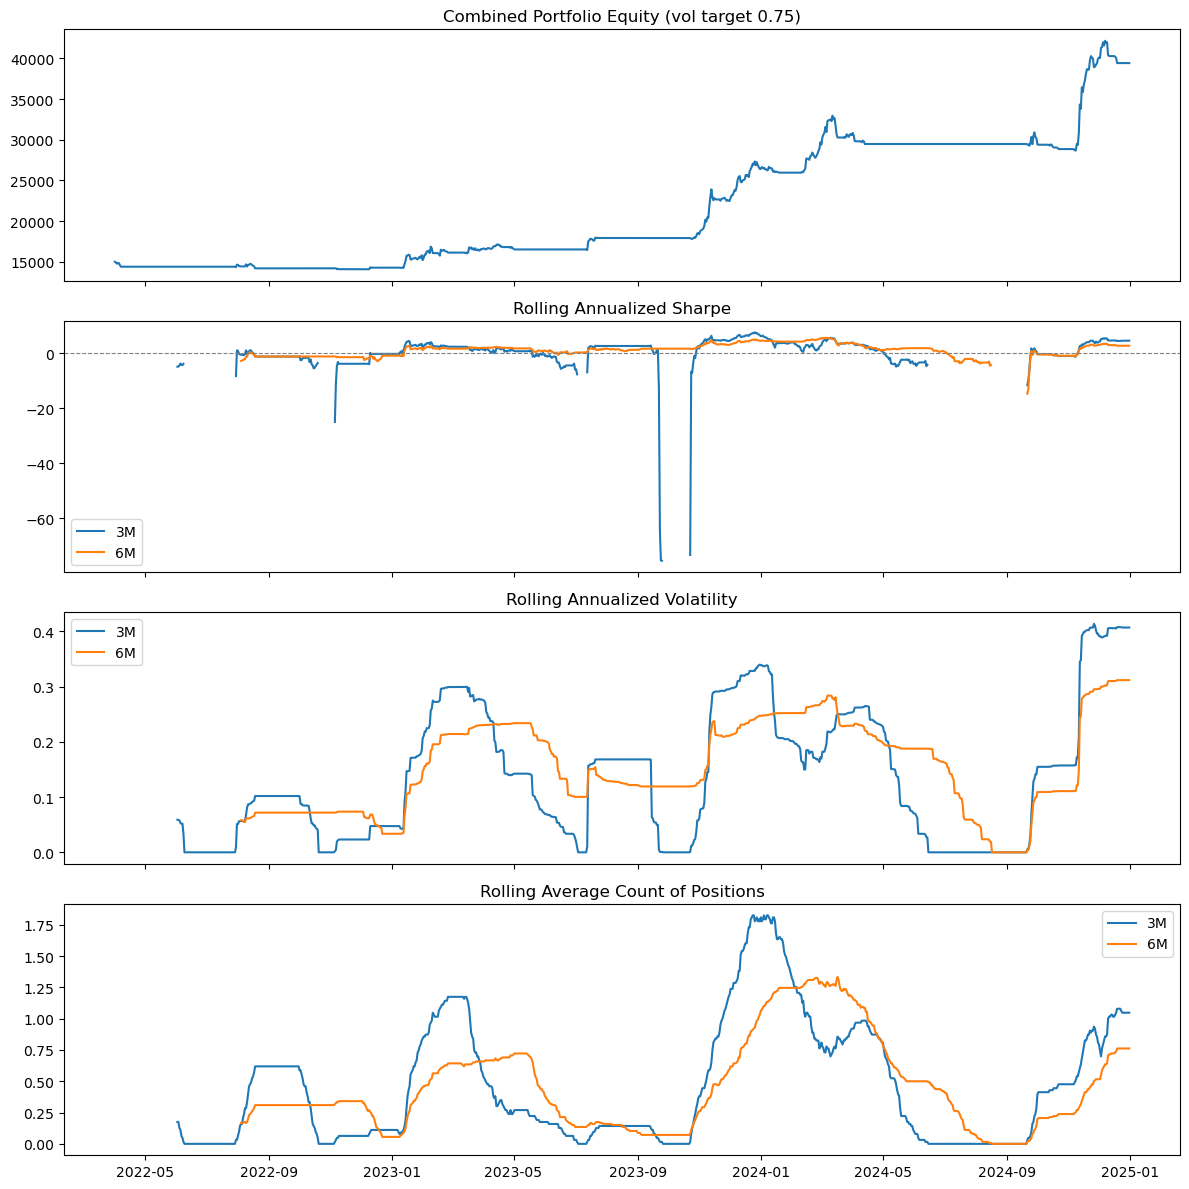

In [261]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Equity curve
axes[0].plot(df_combined.index, df_combined["total_portfolio_value"])
axes[0].set_title("Combined Portfolio Equity (vol target 0.75)")

# Rolling Sharpe
axes[1].plot(df_combined.index, df_combined["rolling_3m_ann_sharpe"], label="3M")
axes[1].plot(df_combined.index, df_combined["rolling_6m_ann_sharpe"], label="6M")
axes[1].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[1].set_title("Rolling Annualized Sharpe")
axes[1].legend()

# Rolling vol
axes[2].plot(df_combined.index, df_combined["rolling_3m_ann_vol"], label="3M")
axes[2].plot(df_combined.index, df_combined["rolling_6m_ann_vol"], label="6M")
axes[2].set_title("Rolling Annualized Volatility")
axes[2].legend()

# Rolling avg positions
axes[3].plot(df_combined.index, df_combined["rolling_3m_avg_positions"], label="3M")
axes[3].plot(df_combined.index, df_combined["rolling_6m_avg_positions"], label="6M")
axes[3].set_title("Rolling Average Count of Positions")
axes[3].legend()

plt.tight_layout()
plt.show()

In [243]:
df_combined.head()

portfolio_daily_pct_returns  count_of_positions  \
date                                                          
2022-04-01                     0.000000                 0.0   
2022-04-02                    -0.005818                 3.0   
2022-04-03                    -0.009768                 1.0   
2022-04-04                     0.003816                 3.0   
2022-04-05                     0.000863                 1.0   

            total_portfolio_value  strategy_cumulative_return  equity_curve  \
date                                                                          
2022-04-01           15000.000000                    0.000000      1.000000   
2022-04-02           14912.722719                   -0.005818      0.994182   
2022-04-03           14767.055440                   -0.015530      0.984470   
2022-04-04           14823.413009                   -0.011772      0.988228   
2022-04-05           14836.199899                   -0.010920      0.989080   

            equity_curve_cum_max  drawdown  drawdown_pct        End  Start  \
date                                                                         
2022-04-01                   1.0  0.000000      0.000000 2022-04-01      1   
2022-04-02                   1.0 -0.005818     -0.005818 2022-04-02      1   
2022-04-03                   1.0 -0.015530     -0.015530 2022-04-03      1   
2022-04-04                   1.0 -0.011772     -0.011772 2022-04-04      1   
2022-04-05                   1.0 -0.010920     -0.010920 2022-04-05      1   

           equity_curve_DDDuration  profitable_trade  color      size  \
date                                                                    
2022-04-01                287 days             False  green  0.000000   
2022-04-02                287 days             False    red  5.818485   
2022-04-03                287 days             False    red  9.767987   
2022-04-04                287 days              True  green  3.816439   
2022-04-05                287 days              True  green  0.862614   

            rolling_3m_ann_sharpe  rolling_6m_ann_sharpe  rolling_3m_ann_vol  \
date                                                                           
2022-04-01                    NaN                    NaN                 NaN   
2022-04-02                    NaN                    NaN                 NaN   
2022-04-03                    NaN                    NaN                 NaN   
2022-04-04                    NaN                    NaN                 NaN   
2022-04-05                    NaN                    NaN                 NaN   

            rolling_6m_ann_vol  rolling_3m_avg_positions  \
date                                                       
2022-04-01                 NaN                       NaN   
2022-04-02                 NaN                       NaN   
2022-04-03                 NaN                       NaN   
2022-04-04                 NaN                       NaN   
2022-04-05                 NaN                       NaN   

            rolling_6m_avg_positions  
date                                  
2022-04-01                       NaN  
2022-04-02                       NaN  
2022-04-03                       NaN  
2022-04-04                       NaN  
2022-04-05                       NaN

<Axes: xlabel='date'>

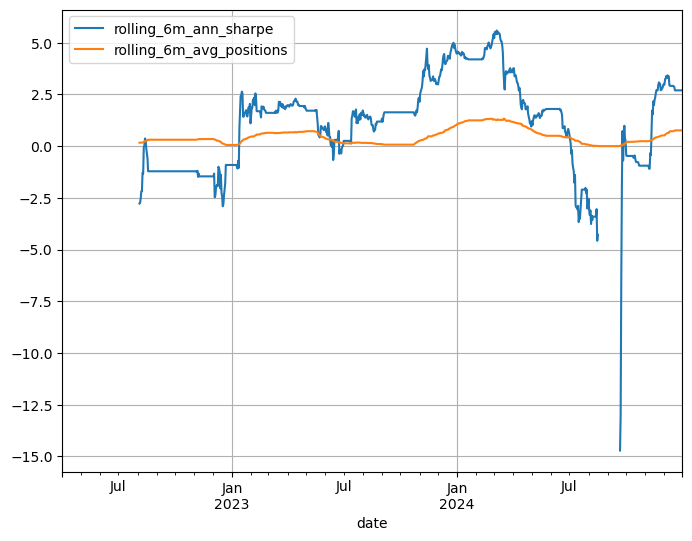

In [255]:
df_combined[['rolling_6m_ann_sharpe','rolling_6m_avg_positions']].plot(figsize=(8,6), grid=True)

<Axes: xlabel='date'>

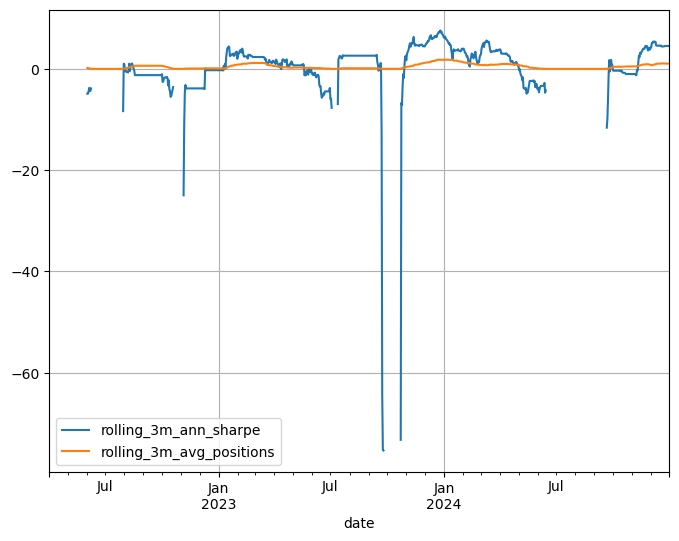

In [257]:
df_combined[['rolling_3m_ann_sharpe','rolling_3m_avg_positions']].plot(figsize=(8,6), grid=True)

## Transaction Cost Simulation

In [272]:
import pandas as pd
import numpy as np

# ---- Inputs ----

crypto_portfolio_ticker_dict = {
    'core_L1_run1': ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves you actually want in the live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000  # across all sleeves

start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# Fix target vol for this experiment
annualized_target_volatility = 0.75


def run_sleeve_backtest_with_t_cost_param(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Runs your production config for a given sleeve and a given transaction_cost_est,
    returns the full df with asset-level returns.
    """

    # choose correct function for core vs alt sleeves
    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,   # <<-- vary this
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut off warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


In [267]:
tc_grid = [0.0, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.007, 0.01]  # 0–30 bps per trade

tc_results = {}

for tc in tc_grid:
    print(f"\n=== Running combined portfolio with transaction_cost_est = {tc} ===")

    # ---- Run all live sleeves at this TC ----
    sleeve_dfs = {}
    for sleeve_name, weight in sleeve_weights_live.items():
        ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
        sleeve_capital = total_initial_capital * weight
        print(f"  Sleeve {sleeve_name}: capital={sleeve_capital:,.2f}")
        df_sleeve = run_sleeve_backtest_with_t_cost_param(
            sleeve_name=sleeve_name,
            ticker_list=ticker_list,
            sleeve_initial_capital=sleeve_capital,
            start_date_test=start_date_test,
            end_date_test=end_date_test,
            transaction_cost_est=tc,
        )
        sleeve_dfs[sleeve_name] = df_sleeve

    # ---- Capital-consistent combined portfolio (P&L / total value) ----
    value_series = {}
    ret_series   = {}
    pos_series   = {}

    for sleeve_name, df in sleeve_dfs.items():
        value_series[sleeve_name] = df["total_portfolio_value"]
        ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
        pos_series[sleeve_name]   = df["count_of_positions"]

    df_value = pd.concat(value_series, axis=1).sort_index()
    df_rets  = pd.concat(ret_series,   axis=1).sort_index()
    df_pos   = pd.concat(pos_series,   axis=1).sort_index()

    # Sleeve P&L_i,t = V_{i,t-1} * r_{i,t}
    df_pnl = df_value.shift(1) * df_rets

    # Aggregate to portfolio level
    total_value = df_value.sum(axis=1)
    total_pnl   = df_pnl.sum(axis=1)

    # Combined daily return
    combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
    combined_positions = df_pos.sum(axis=1)

    df_combined = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": combined_daily_ret,
            "count_of_positions": combined_positions,
        }
    )

    # Rebuild combined portfolio value for sanity check
    df_combined["total_portfolio_value"] = (
        total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
    )

    # ---- Compute performance metrics (returns already net of TC in the backtest) ----
    metrics = perf.calculate_risk_and_performance_metrics(
        df_combined,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # costs already modeled in the sleeve P&L
        transaction_cost_est=tc,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    tc_results[tc] = metrics

tc_results



=== Running combined portfolio with transaction_cost_est = 0.0 ===
  Sleeve core_L1_run1: capital=6,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
  Sleeve L1_alt_run1: capital=3,000.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
  Sleeve L2_run1: capital=3,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculat

{0.0: {'annualized_return': 0.43726318453999435,
  'annualized_sharpe_ratio': 1.7863642422206394,
  'calmar_ratio': 3.5261243951862453,
  'annualized_std_dev': 0.3497733797156793,
  'max_drawdown': -0.12400673814484037,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.4030154214606183,
  'p_value': 0.0006927568073273916,
  'trade_count': 473.0},
 0.0005: {'annualized_return': 0.42860484553090306,
  'annualized_sharpe_ratio': 1.7522911329809283,
  'calmar_ratio': 3.3785002302864546,
  'annualized_std_dev': 0.34953768758668474,
  'max_drawdown': -0.12686245858108547,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.346050808284545,
  'p_value': 0.0008500588282888426,
  'trade_count': 473.0},
 0.001: {'annualized_return': 0.42006820538371215,
  'annualized_sharpe_ratio': 1.718503945866282,
  'calmar_ratio': 3.2384422987565626,
  'annualized_std_dev': 0.3500367421

In [268]:
tc_results

{0.0: {'annualized_return': 0.43726318453999435,
  'annualized_sharpe_ratio': 1.7863642422206394,
  'calmar_ratio': 3.5261243951862453,
  'annualized_std_dev': 0.3497733797156793,
  'max_drawdown': -0.12400673814484037,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.4030154214606183,
  'p_value': 0.0006927568073273916,
  'trade_count': 473.0},
 0.0005: {'annualized_return': 0.42860484553090306,
  'annualized_sharpe_ratio': 1.7522911329809283,
  'calmar_ratio': 3.3785002302864546,
  'annualized_std_dev': 0.34953768758668474,
  'max_drawdown': -0.12686245858108547,
  'max_drawdown_duration': Timedelta('287 days 00:00:00'),
  'hit_rate': 0.16600397614314116,
  't_statistic': 3.346050808284545,
  'p_value': 0.0008500588282888426,
  'trade_count': 473.0},
 0.001: {'annualized_return': 0.42006820538371215,
  'annualized_sharpe_ratio': 1.718503945866282,
  'calmar_ratio': 3.2384422987565626,
  'annualized_std_dev': 0.3500367421

## Combined Sleeve Portfolio Performance vs Core Prod Portfolio Performance at Target Vol of 0.75

In [319]:
import pandas as pd
import numpy as np

# ---- Config ----

core_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

crypto_portfolio_ticker_dict = {
    'core_L1_run1': core_ticker_list,
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves in the combined live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# set target vol + TC assumption for this comparison
annualized_target_volatility = 0.75
transaction_cost_est_compare = 0.001   # pick anything from your TC grid


# ---- Helper: run one sleeve (same as before, but TC passed in) ----

def run_sleeve_backtest(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Run backtest for a single sleeve with given initial capital and TC.
    """

    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- 1) Combined sleeve portfolio ----

sleeve_dfs_is = {}
for sleeve_name, weight in sleeve_weights_live.items():
    tickers = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Combined: running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=tickers,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        transaction_cost_est=transaction_cost_est_compare,
    )
    sleeve_dfs_is[sleeve_name] = df_sleeve

# Capital-consistent combination
value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs_is.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

df_pnl   = df_value.shift(1) * df_rets   # PnL_i,t
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

combined_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 2) Core-only prod portfolio at same target vol & TC ----

core_initial_capital = total_initial_capital   # all capital in core sleeve

print(f"\nCore-only: running core_L1_run1 with capital {core_initial_capital:,.2f}")
df_core_only = run_sleeve_backtest(
    sleeve_name="core_L1_run1",
    ticker_list=core_ticker_list,
    sleeve_initial_capital=core_initial_capital,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    transaction_cost_est=transaction_cost_est_compare,
)

core_metrics = perf.calculate_risk_and_performance_metrics(
    df_core_only,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 3) Put metrics into a comparison DataFrame ----

def select_keys(d):
    return {
        "annualized_return": d["annualized_return"],
        "annualized_std_dev": d["annualized_std_dev"],
        "annualized_sharpe_ratio": d["annualized_sharpe_ratio"],
        "max_drawdown": d["max_drawdown"],
        "calmar_ratio": d["calmar_ratio"],
        "trade_count": d["trade_count"],
    }

comparison_df = pd.DataFrame.from_dict(
    {
        "combined_sleeves": select_keys(combined_metrics),
        "core_only":        select_keys(core_metrics),
    },
    orient="index",
)

print("\n=== Combined sleeves vs Core-only (vol target 0.75, TC = "
      f"{transaction_cost_est_compare}) ===")
display(comparison_df)


Combined: running core_L1_run1 with capital 6,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Combined: running L1_alt_run1 with capital 3,000.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Combined: running L2_run1 with capital 3,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
C

annualized_return  annualized_std_dev  \
combined_sleeves           0.420068            0.350037   
core_only                  0.430941            0.525986   

                  annualized_sharpe_ratio  max_drawdown  calmar_ratio  \
combined_sleeves                 1.718504     -0.129713      3.238442   
core_only                        1.415251     -0.163434      2.636784   

                  trade_count  
combined_sleeves        473.0  
core_only               165.0

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

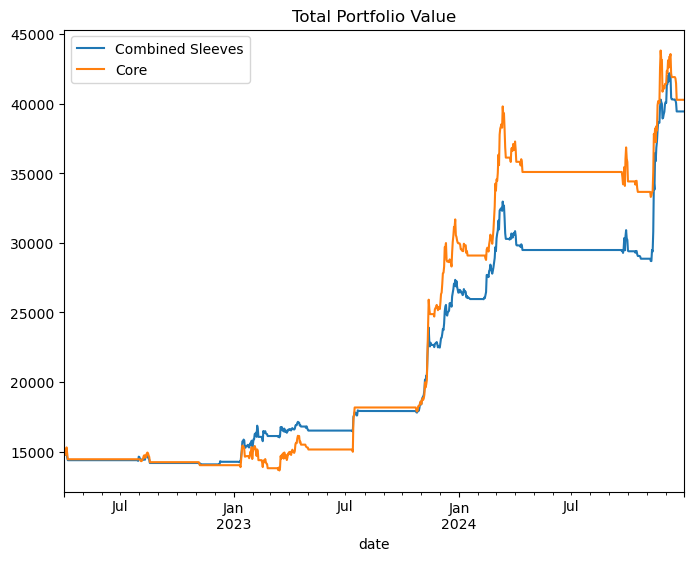

In [320]:
df_combined['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Total Portfolio Value')
df_core_only['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core')

<Axes: title={'center': 'Equity Curve'}, xlabel='date'>

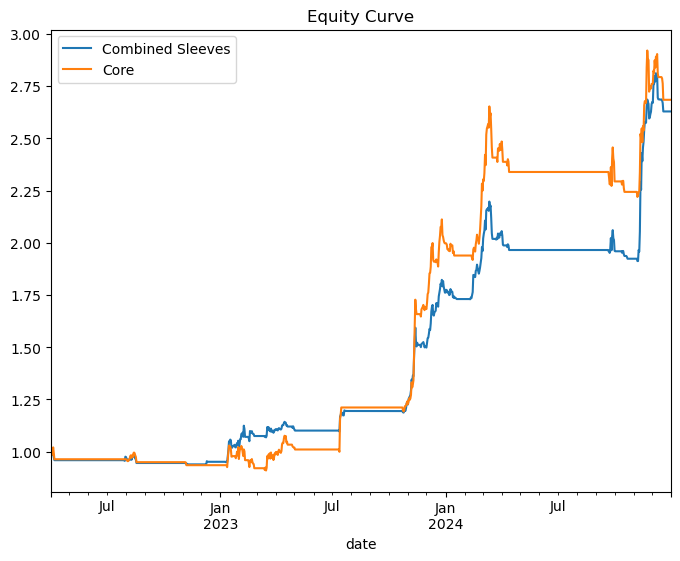

In [321]:
df_combined['equity_curve'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Equity Curve')
df_core_only['equity_curve'].plot(figsize=(8,6), legend=True, label='Core')

In [322]:
print("\n=== In-Sample Performance ===")
print("\n=== Core L1 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

print("\n=== L1 Alt ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== L2 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== AI ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))


=== In-Sample Performance ===

=== Core L1 ===
{'annualized_return': 0.4309408966115129, 'annualized_sharpe_ratio': 1.4152508541453714, 'calmar_ratio': 2.6367843837637492, 'annualized_std_dev': 0.5259862749437194, 'max_drawdown': -0.16343425699312863, 'max_drawdown_duration': Timedelta('284 days 00:00:00'), 'hit_rate': 0.13717693836978131, 't_statistic': 2.6895101885502566, 'p_value': 0.0072742277702042835, 'trade_count': 165.0}

=== L1 Alt ===
{'annualized_return': 0.4271792802250478, 'annualized_sharpe_ratio': 1.1466892736631893, 'calmar_ratio': 3.7534339887352077, 'annualized_std_dev': 0.9588625948130479, 'max_drawdown': -0.11381025522417516, 'max_drawdown_duration': Timedelta('246 days 00:00:00'), 'hit_rate': 0.08349900596421471, 't_statistic': 2.170186950329089, 'p_value': 0.030226321336087842, 'trade_count': 105.0}

=== L2 ===
{'annualized_return': 0.29724159852686216, 'annualized_sharpe_ratio': 0.993129005242181, 'calmar_ratio': 1.8543759119402423, 'annualized_std_dev': 0.57925

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

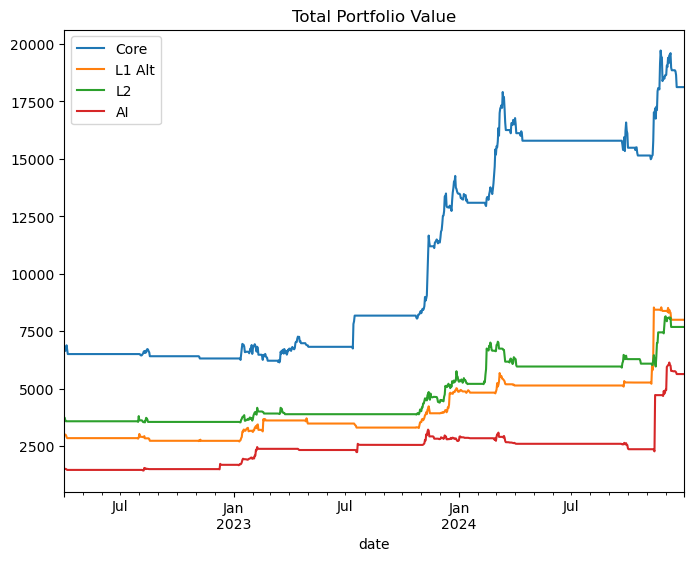

In [323]:
sleeve_dfs_is['core_L1_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core', title='Total Portfolio Value')
sleeve_dfs_is['L1_alt_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs_is['L2_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs_is['AI_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='AI')

<Axes: title={'center': 'Equity Curve'}, xlabel='date'>

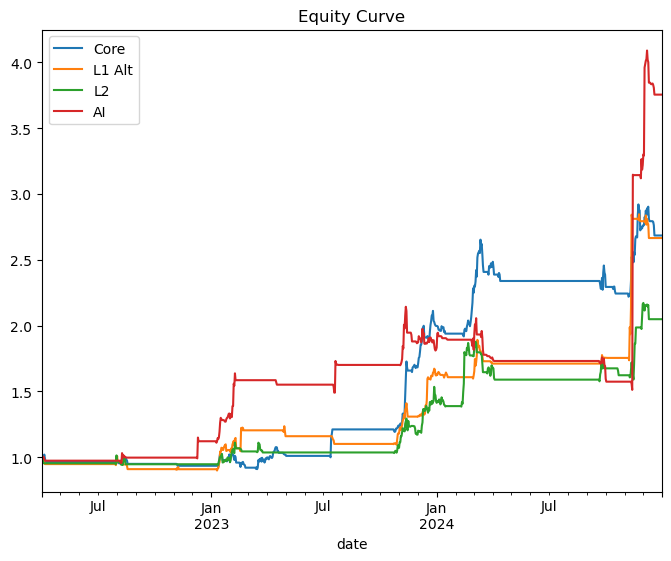

In [324]:
sleeve_dfs_is['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs_is['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs_is['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs_is['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

In [461]:
client = cn.get_coinbase_rest_api_client(portfolio_name=cfg['portfolio']['name'])
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=cfg['portfolio']['name'])
portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client, portfolio_name=cfg['portfolio']['name'])

In [467]:
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=cfg['universe']['tickers'], portfolio_name=cfg['portfolio']['name'])

In [469]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 92912.015,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3075.205,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 141.695,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.43515,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 14.065000000000001,
  'ticker_current_notional': 0.0}}

In [463]:
portfolio_equity

0.0

In [465]:
available_cash

1045.1461

## Out of Sample Performance

In [287]:
import pandas as pd
import numpy as np

# ---- Config ----

core_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

crypto_portfolio_ticker_dict = {
    'core_L1_run1': core_ticker_list,
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves in the combined live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-11-30').date()

# set target vol + TC assumption for this comparison
annualized_target_volatility = 0.75
transaction_cost_est_compare = 0.001   # pick anything from your TC grid


# ---- Helper: run one sleeve (same as before, but TC passed in) ----

def run_sleeve_backtest(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Run backtest for a single sleeve with given initial capital and TC.
    """

    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- 1) Combined sleeve portfolio ----

sleeve_dfs = {}
for sleeve_name, weight in sleeve_weights_live.items():
    tickers = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Combined: running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=tickers,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        transaction_cost_est=transaction_cost_est_compare,
    )
    sleeve_dfs[sleeve_name] = df_sleeve

# Capital-consistent combination
value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

df_pnl   = df_value.shift(1) * df_rets   # PnL_i,t
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined_oos = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)
df_combined_oos["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined_oos["portfolio_daily_pct_returns"]).cumprod()
)

combined_metrics_oos = perf.calculate_risk_and_performance_metrics(
    df_combined_oos,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 2) Core-only prod portfolio at same target vol & TC ----

core_initial_capital = total_initial_capital   # all capital in core sleeve

print(f"\nCore-only: running core_L1_run1 with capital {core_initial_capital:,.2f}")
df_core_only_oos = run_sleeve_backtest(
    sleeve_name="core_L1_run1",
    ticker_list=core_ticker_list,
    sleeve_initial_capital=core_initial_capital,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    transaction_cost_est=transaction_cost_est_compare,
)

core_metrics_oos = perf.calculate_risk_and_performance_metrics(
    df_core_only_oos,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 3) Put metrics into a comparison DataFrame ----

def select_keys(d):
    return {
        "annualized_return": d["annualized_return"],
        "annualized_std_dev": d["annualized_std_dev"],
        "annualized_sharpe_ratio": d["annualized_sharpe_ratio"],
        "max_drawdown": d["max_drawdown"],
        "calmar_ratio": d["calmar_ratio"],
        "trade_count": d["trade_count"],
    }

comparison_df_oos = pd.DataFrame.from_dict(
    {
        "combined_sleeves": select_keys(combined_metrics_oos),
        "core_only":        select_keys(core_metrics_oos),
    },
    orient="index",
)

print("\n=== Combined sleeves vs Core-only (vol target 0.75, TC = "
      f"{transaction_cost_est_compare}) ===")
display(comparison_df_oos)


Combined: running core_L1_run1 with capital 6,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Combined: running L1_alt_run1 with capital 3,000.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Combined: running L2_run1 with capital 3,750.00
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
C

annualized_return  annualized_std_dev  \
combined_sleeves          -0.047809            0.174666   
core_only                 -0.006052            0.224252   

                  annualized_sharpe_ratio  max_drawdown  calmar_ratio  \
combined_sleeves                -1.045433     -0.075877     -0.630091   
core_only                       -0.303487     -0.086667     -0.069830   

                  trade_count  
combined_sleeves         84.0  
core_only                42.0

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

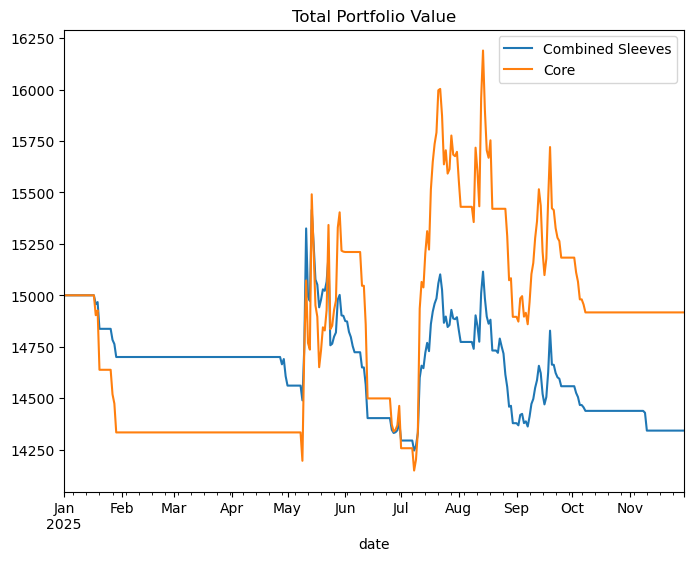

In [315]:
df_combined_oos['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Total Portfolio Value')
df_core_only_oos['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core')

<Axes: title={'center': 'Equity Curve'}, xlabel='date'>

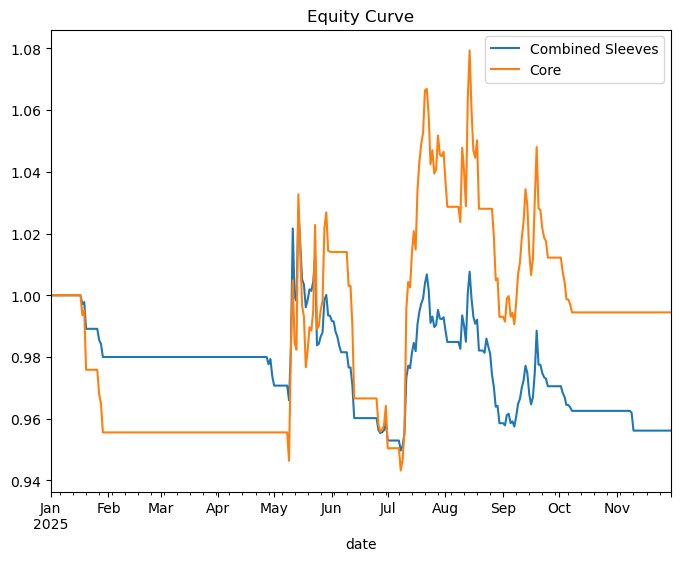

In [317]:
df_combined_oos['equity_curve'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Equity Curve')
df_core_only_oos['equity_curve'].plot(figsize=(8,6), legend=True, label='Core')

In [307]:
print("\n=== Core L1 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

print("\n=== L1 Alt ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== L2 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== AI ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))


=== Core L1 ===
{'annualized_return': -0.006051982824354263, 'annualized_sharpe_ratio': -0.3034871080904756, 'calmar_ratio': -0.06983040265967994, 'annualized_std_dev': 0.22425235397536128, 'max_drawdown': -0.0866668756565638, 'max_drawdown_duration': Timedelta('129 days 00:00:00'), 'hit_rate': 0.1497005988023952, 't_statistic': 0.029287874210097518, 'p_value': 0.976652542437229, 'trade_count': 42.0}

=== L1 Alt ===
{'annualized_return': -0.22720929191745043, 'annualized_sharpe_ratio': -4.1330828045846895, 'calmar_ratio': -1.0814045511223667, 'annualized_std_dev': 0.2335481806691299, 'max_drawdown': -0.21010572933287064, 'max_drawdown_duration': Timedelta('333 days 00:00:00'), 'hit_rate': 0.0, 't_statistic': -3.3184767407045594, 'p_value': 0.0010052309761179224, 'trade_count': 13.0}

=== L2 ===
{'annualized_return': -0.0374339815300766, 'annualized_sharpe_ratio': -0.7379559909961434, 'calmar_ratio': -0.41190152664071905, 'annualized_std_dev': 0.5858140621534508, 'max_drawdown': -0.090

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

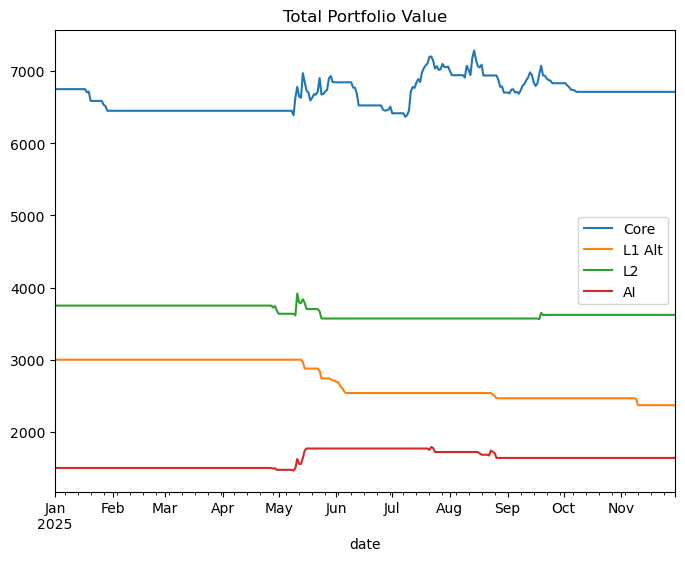

In [311]:
sleeve_dfs['core_L1_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core', title='Total Portfolio Value')
sleeve_dfs['L1_alt_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='AI')

<Axes: title={'center': 'Equity Curve'}, xlabel='date'>

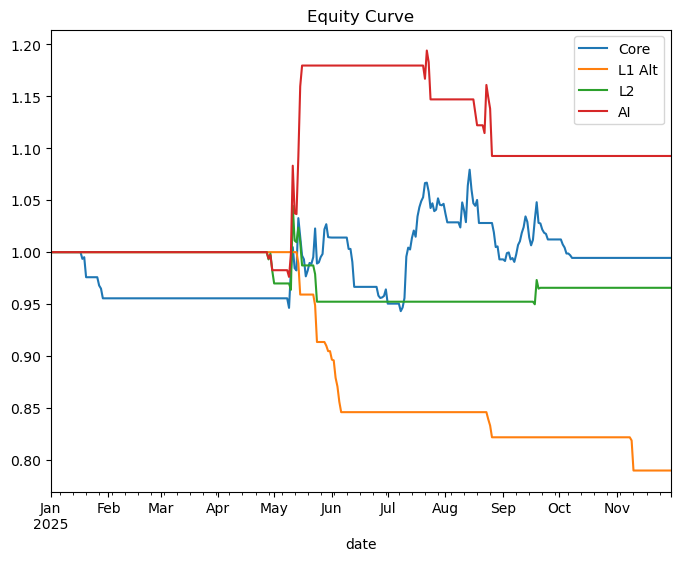

In [313]:
sleeve_dfs['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

In [ ]:
sleeve_dfs['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

In [335]:
crypto_portfolio_ticker_dict

{'core_L1_run1': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD'],
 'L1_run2': ['DOT-USD', 'ATOM-USD', 'LTC-USD', 'ALGO-USD', 'XLM-USD'],
 'L1_alt_run1': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD'],
 'L2_run1': ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD'],
 'AI_run1': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD'],
 'DeFi_run1': ['UNI-USD', 'AAVE-USD', 'AMP-USD', 'COMP-USD', 'MKR-USD'],
 'DeFi_run2': ['SNX-USD', 'SUSHI-USD', 'CRV-USD', 'BAL-USD', '1INCH-USD']}

<Axes: title={'center': 'Daily P&L by Coin'}, xlabel='date'>

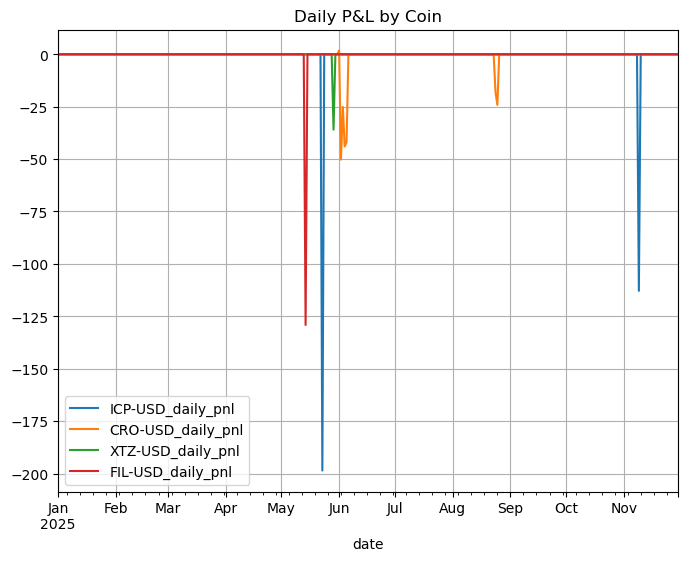

In [375]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in crypto_portfolio_ticker_dict['L1_alt_run1']]
sleeve_dfs['L1_alt_run1'][daily_pnl_cols].plot(figsize=(8,6), title='Daily P&L by Coin', grid=True)

<Axes: title={'center': 'Daily P&L by Coin'}, xlabel='date'>

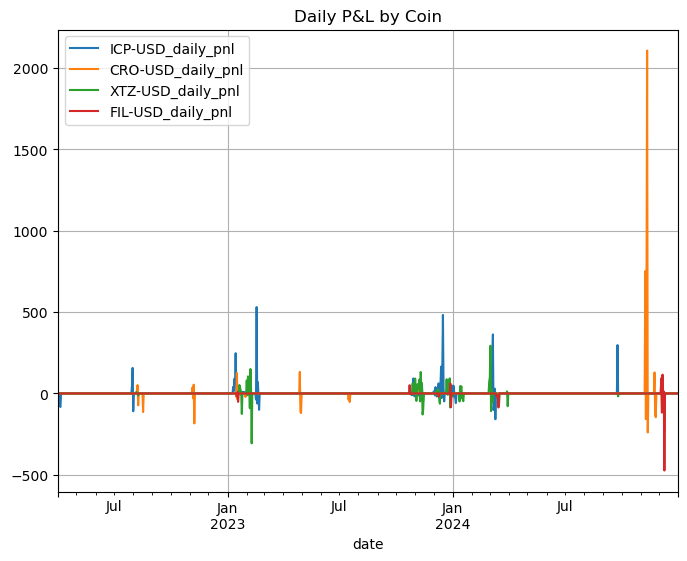

In [377]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in crypto_portfolio_ticker_dict['L1_alt_run1']]
sleeve_dfs_is['L1_alt_run1'][daily_pnl_cols].plot(figsize=(8,6), title='Daily P&L by Coin', grid=True)

In [441]:
sleeve_dfs['L1_alt_run1'][sleeve_dfs['L1_alt_run1'].index >= pd.Timestamp('2025-10-20')].head()

ICP-USD_20_avg_true_range_price  ICP-USD_actual_position_notional  \
date                                                                            
2025-10-20                         0.343258                               0.0   
2025-10-21                         0.331043                               0.0   
2025-10-22                         0.341801                               0.0   
2025-10-23                         0.331915                               0.0   
2025-10-24                         0.310494                               0.0   

            ICP-USD_actual_position_size  ICP-USD_annualized_volatility_30  \
date                                                                         
2025-10-20                           0.0                          1.162480   
2025-10-21                           0.0                          1.175584   
2025-10-22                           0.0                          1.181568   
2025-10-23                           0.0                          1.155997   
2025-10-24                           0.0                          1.160685   

            ICP-USD_close  ICP-USD_cooldown_counter ICP-USD_event  \
date                                                                
2025-10-20          3.190                       0.0   No Position   
2025-10-21          3.045                       0.0   No Position   
2025-10-22          2.979                       0.0   No Position   
2025-10-23          3.044                       0.0   No Position   
2025-10-24          3.148                       0.0   No Position   

            ICP-USD_final_signal  ICP-USD_final_weighted_additive_signal  \
date                                                                       
2025-10-20                   0.0                               -0.423515   
2025-10-21                   0.0                               -0.420077   
2025-10-22                   0.0                               -0.420418   
2025-10-23                   0.0                               -0.422607   
2025-10-24                   0.0                               -0.422019   

            ICP-USD_highest_high_56  ICP-USD_lowest_low_56  \
date                                                         
2025-10-20                    5.351                  2.056   
2025-10-21                    5.163                  2.056   
2025-10-22                    5.163                  2.056   
2025-10-23                    5.163                  2.056   
2025-10-24                    5.163                  2.056   

            ICP-USD_new_position_entry_exit_price  \
date                                                
2025-10-20                                  3.069   
2025-10-21                                  3.190   
2025-10-22                                  3.045   
2025-10-23                                  2.980   
2025-10-24                                  3.045   

            ICP-USD_new_position_notional  ICP-USD_new_position_size  \
date                                                                   
2025-10-20                            0.0                        0.0   
2025-10-21                            0.0                        0.0   
2025-10-22                            0.0                        0.0   
2025-10-23                            0.0                        0.0   
2025-10-24                            0.0                        0.0   

            ICP-USD_open  ICP-USD_open_position_notional  \
date                                                       
2025-10-20         3.069                             0.0   
2025-10-21         3.190                             0.0   
2025-10-22         3.045                             0.0   
2025-10-23         2.980                             0.0   
2025-10-24         3.045                             0.0   

            ICP-USD_open_position_size  ICP-USD_short_sale_proceeds  \
date                                                                  
2025-

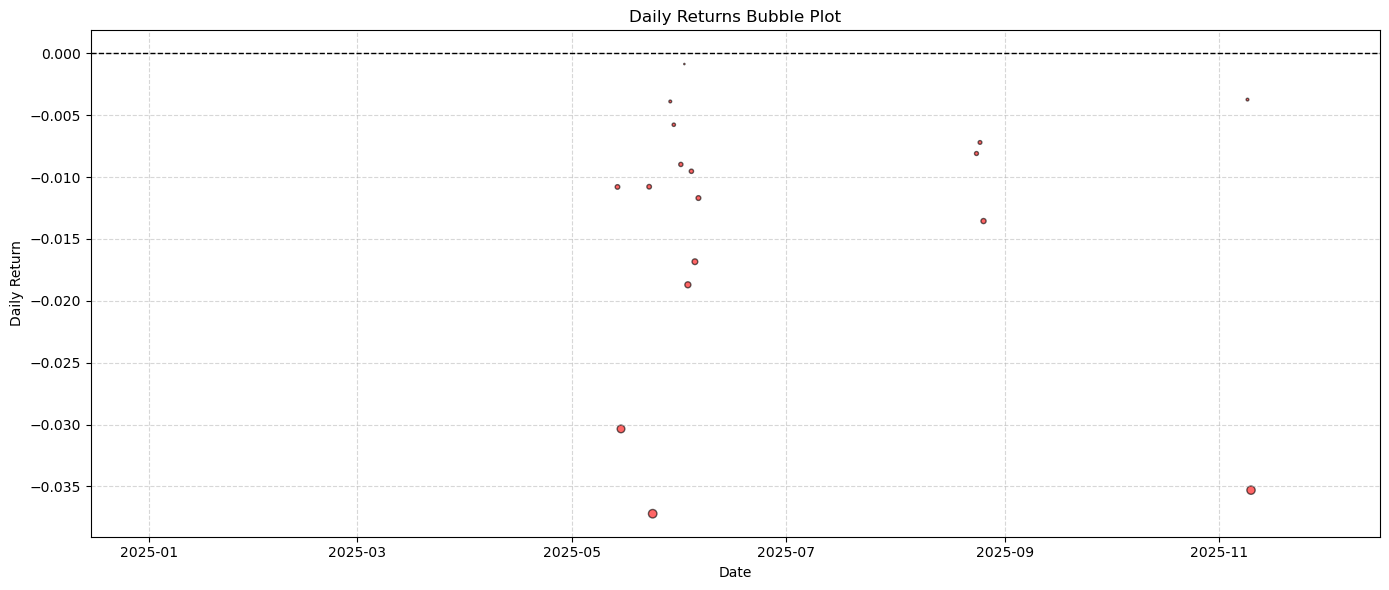

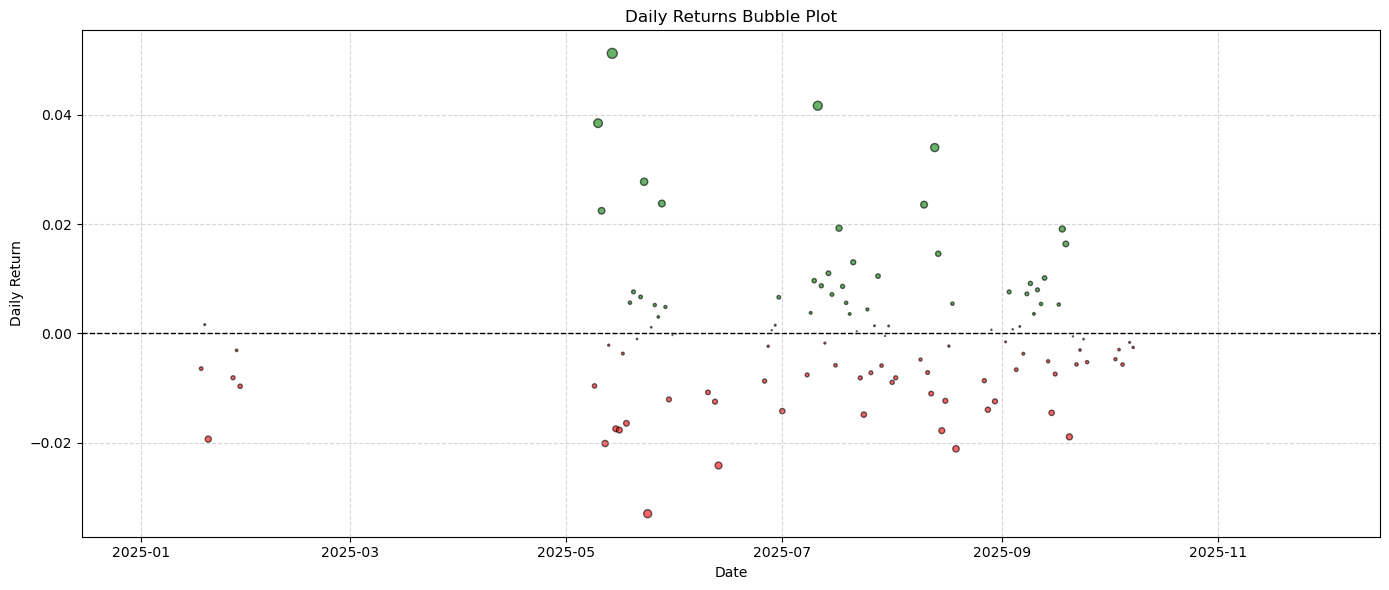

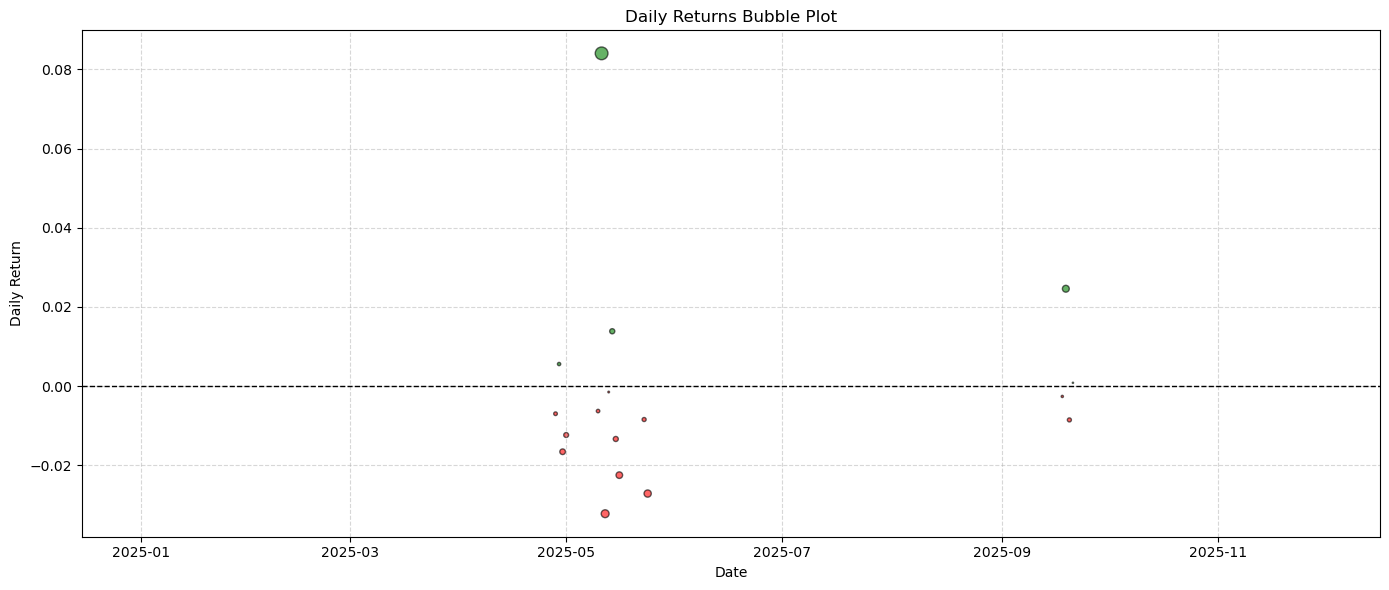

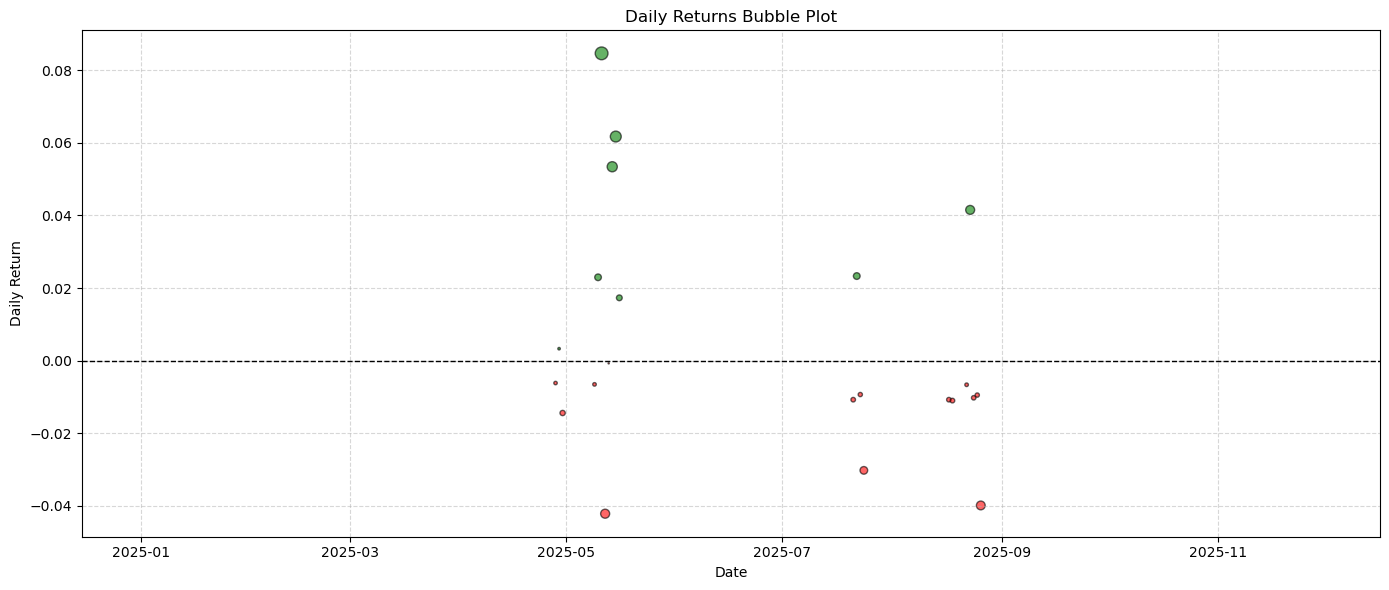

In [447]:
perf.plot_daily_returns_bubble(sleeve_dfs['L1_alt_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['core_L1_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['L2_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['AI_run1'], return_col='portfolio_daily_pct_returns')

## In Sample Backtest using Coins from All Sleeves to Determine Target Notionals
### Sleeve Level Caps are calculated after the target notionals are determined per coin
### This method accounts for correlations between coins of different sleeves

In [579]:
## Get the Sleeve Config
cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
sleeve_config = cfg_v2['universe']['sleeves']

## Get the Full Portfolio Ticker List
expanded_ticker_list = cfg_v2['universe']['tickers']

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [571]:
sleeve_config

{'L1_Core': {'weight': 0.45,
  'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
 'L1_Alt': {'weight': 0.2,
  'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
 'L2': {'weight': 0.25,
  'tickers': ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD']},
 'AI': {'weight': 0.1,
  'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}

In [581]:
expanded_ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'SKL-USD',
 'IMX-USD',
 'LRC-USD',
 'STX-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'OXT-USD',
 'KRL-USD']

In [605]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None, sleeve_config=sleeve_config):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date, sleeve_config=sleeve_config)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [607]:
from collections import defaultdict

def apply_sleeve_caps(
    df,
    date,
    ticker_list,
    ticker_to_sleeve,
    sleeve_weights,
    total_portfolio_value_upper_limit,
):
    """
    df: main DataFrame
    date: current backtest date
    ticker_list: full universe list
    ticker_to_sleeve: dict[ticker] -> sleeve_name
    sleeve_weights:  dict[sleeve_name] -> max fraction of portfolio (e.g. 0.45)
    total_portfolio_value_upper_limit: the same scalar you used in target_vol sizing
    """

    # 1) Compute gross target notional per sleeve
    gross_by_sleeve = defaultdict(float)

    for ticker in ticker_list:
        sleeve = ticker_to_sleeve.get(ticker)
        if sleeve is None:
            continue
        tn = df.loc[date, f"{ticker}_target_notional"]
        gross_by_sleeve[sleeve] += abs(tn)

    # 2) For each sleeve: if above cap, scale that sleeve's target notionals down
    for sleeve, gross in gross_by_sleeve.items():
        w = sleeve_weights.get(sleeve, None)
        if w is None:
            continue

        cap = w * total_portfolio_value_upper_limit  # sleeve's gross cap
        if gross > cap and gross > 0:
            scale = cap / gross

            # Scale each ticker in that sleeve
            for ticker in ticker_list:
                if ticker_to_sleeve.get(ticker) != sleeve:
                    continue

                tn_col = f"{ticker}_target_notional"
                sz_col = f"{ticker}_target_size"
                px_col = f"{ticker}_t_1_close"

                old_tn = df.loc[date, tn_col]
                new_tn = old_tn * scale
                df.loc[date, tn_col] = new_tn

                px = df.loc[date, px_col]
                df.loc[date, sz_col] = new_tn / px

    # 3) Recompute total_target_notional for bookkeeping
    target_notional_cols = [f"{t}_target_notional" for t in ticker_list]
    df.loc[date, "total_target_notional"] = df.loc[date, target_notional_cols].sum()

    return df


In [609]:
def get_target_volatility_daily_portfolio_positions(df, ticker_list, initial_capital, rolling_cov_window,
                                                    stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                    highest_high_window, cash_buffer_percentage,
                                                    annualized_target_volatility, transaction_cost_est=0.001,
                                                    passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                    min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                    annual_trading_days=365, use_specific_start_date=False,
                                                    signal_start_date=None, sleeve_config=sleeve_config):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                   total_portfolio_value_upper_limit)

        ## Get Sleeve Ticker and Weight Mapping
        if sleeve_config is not None:
            ticker_to_sleeve = {}
            sleeve_weights = {}
    
            for sleeve_name, s in sleeve_config.items():
                w = float(s["weight"])
                sleeve_weights[sleeve_name] = w
                for t in s["tickers"]:
                    ticker_to_sleeve[t] = sleeve_name
        else:
            ticker_to_sleeve = {}
            sleeve_weights = {}

        ## Adjust Target Notionals based on the assigned Sleeve Weights
        df = apply_sleeve_caps(df, date, ticker_list, ticker_to_sleeve,
                               sleeve_weights, total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [611]:
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

annualized_target_volatility = 0.75

In [613]:
fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe

df_expanded = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test,
    sleeve_config=sleeve_config
)

# cut warmup
df_expanded = df_expanded[df_expanded.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded = perf.calculate_asset_level_returns(df_expanded, end_date_test, ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
SKL-USD
IMX-USD
LRC-USD
STX-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [617]:
expended_tickers_perf_metrics = perf.calculate_risk_and_performance_metrics(
    df_expanded,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expended_tickers_perf_metrics

{'annualized_return': 0.12452278331463362,
 'annualized_sharpe_ratio': 0.8012646110744924,
 'calmar_ratio': 1.8941906107268953,
 'annualized_std_dev': 0.16385716935858027,
 'max_drawdown': -0.06573930976611062,
 'max_drawdown_duration': Timedelta('244 days 00:00:00'),
 'hit_rate': 0.12922465208747516,
 't_statistic': 2.2240441054835918,
 'p_value': 0.026367048262279917,
 'trade_count': 120.0}

<Axes: xlabel='date'>

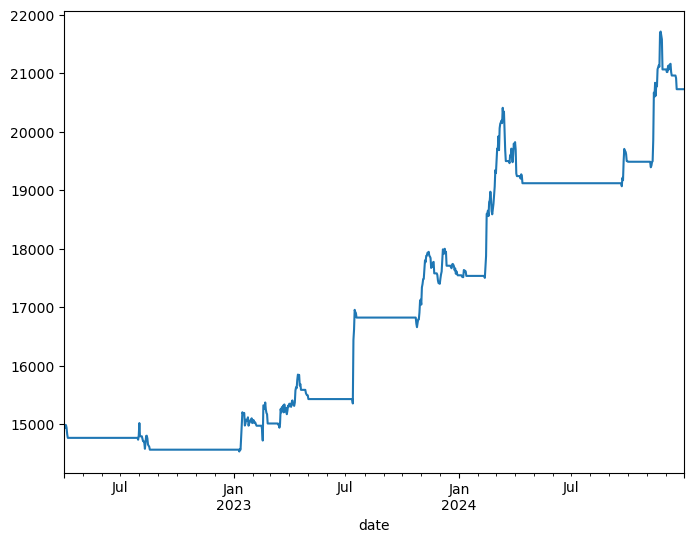

In [619]:
df_expanded['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

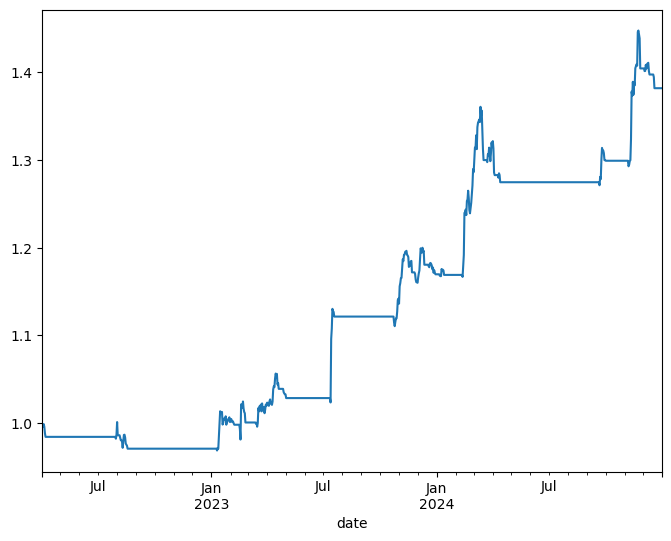

In [621]:
df_expanded['equity_curve'].plot(figsize=(8,6))

## Backtesting the Above Strategy for Different Target Volatilities

In [626]:
fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe
expanded_df_dict = {}
expanded_results_dict = {}

for tv in [0.75, 0.85, 0.95, 1.0, 1.1, 1.2]:

    df_expanded_tv = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
        sleeve_config=sleeve_config
    )
    
    # cut warmup
    df_expanded_tv = df_expanded_tv[df_expanded_tv.index >= pd.Timestamp(start_date_test)]
    
    # add asset-level + portfolio_daily_pct_returns, etc.
    df_expanded_tv = perf.calculate_asset_level_returns(df_expanded_tv, end_date_test, ticker_list)

    expanded_df_dict[tv] = df_expanded_tv

    ## Performance Metrics
    expanded_tickers_perf_metrics_tv = perf.calculate_risk_and_performance_metrics(
        df_expanded_tv,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # TC already baked into P&L
        transaction_cost_est=transaction_cost_est_compare,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    expanded_results_dict[tv] = expanded_tickers_perf_metrics_tv
    print(tv, expanded_tickers_perf_metrics_tv)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
SKL-USD
IMX-USD
LRC-USD
STX-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
0.75 {'annualized_return': 0.12452278331463362, 'annualized_sharpe_ratio': 0.8012646110744924, 'calmar_ratio': 1.8941906107268953, 'annualized_std_dev': 0.16385716935858027, 'max_drawdown': -0.06573930976611062, 'max_drawdown_duration': Timedelta('244 days 00:00:00'), 'hit_rate': 0.12922465208747516, 't_statistic': 2.2240441054835918, 'p_value': 0.026367048262279917, 'trade_count': 120.0}
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD

## Backtesting the Expanded Ticker List Without Any Sleeve Caps

In [630]:
fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol
expanded_df_dict_no_sleeve_caps = {}
expanded_results_dict_no_sleeve_caps = {}

for tv in [0.60, 0.75, 0.85, 0.95, 1.0, 1.1, 1.2]:

    df_expanded_tv_no_sleeve_caps = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test
    )
    
    # cut warmup
    df_expanded_tv_no_sleeve_caps = df_expanded_tv_no_sleeve_caps[df_expanded_tv_no_sleeve_caps.index >= pd.Timestamp(start_date_test)]
    
    # add asset-level + portfolio_daily_pct_returns, etc.
    df_expanded_tv_no_sleeve_caps = perf.calculate_asset_level_returns(df_expanded_tv_no_sleeve_caps, end_date_test, ticker_list)

    expanded_df_dict_no_sleeve_caps[tv] = df_expanded_tv_no_sleeve_caps

    ## Performance Metrics
    expanded_tickers_perf_metrics_tv = perf.calculate_risk_and_performance_metrics(
        df_expanded_tv_no_sleeve_caps,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # TC already baked into P&L
        transaction_cost_est=transaction_cost_est_compare,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    expanded_results_dict_no_sleeve_caps[tv] = expanded_tickers_perf_metrics_tv
    print(tv, expanded_tickers_perf_metrics_tv)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
SKL-USD
IMX-USD
LRC-USD
STX-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
0.6 {'annualized_return': 0.26120524267553535, 'annualized_sharpe_ratio': 1.1126972147536744, 'calmar_ratio': 2.203392411286883, 'annualized_std_dev': 0.4048698478199312, 'max_drawdown': -0.11854685590161376, 'max_drawdown_duration': Timedelta('284 days 00:00:00'), 'hit_rate': 0.13320079522862824, 't_statistic': 2.300468844146103, 'p_value': 0.02162574172792891, 'trade_count': 177.0}
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
SKL-

In [ ]:
import pandas as pd
import numpy as np

# ---- Config ----

core_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

crypto_portfolio_ticker_dict = {
    'core_L1_run1': core_ticker_list,
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves in the combined live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# set target vol + TC assumption for this comparison
annualized_target_volatility = 0.75
transaction_cost_est_compare = 0.001   # pick anything from your TC grid


# ---- Helper: run one sleeve (same as before, but TC passed in) ----

def run_sleeve_backtest(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Run backtest for a single sleeve with given initial capital and TC.
    """

    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- 1) Combined sleeve portfolio ----

sleeve_dfs_is = {}
for sleeve_name, weight in sleeve_weights_live.items():
    tickers = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Combined: running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=tickers,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        transaction_cost_est=transaction_cost_est_compare,
    )
    sleeve_dfs_is[sleeve_name] = df_sleeve

# Capital-consistent combination
value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs_is.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

df_pnl   = df_value.shift(1) * df_rets   # PnL_i,t
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

combined_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 2) Core-only prod portfolio at same target vol & TC ----

core_initial_capital = total_initial_capital   # all capital in core sleeve

print(f"\nCore-only: running core_L1_run1 with capital {core_initial_capital:,.2f}")
df_core_only = run_sleeve_backtest(
    sleeve_name="core_L1_run1",
    ticker_list=core_ticker_list,
    sleeve_initial_capital=core_initial_capital,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    transaction_cost_est=transaction_cost_est_compare,
)

core_metrics = perf.calculate_risk_and_performance_metrics(
    df_core_only,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 3) Put metrics into a comparison DataFrame ----

def select_keys(d):
    return {
        "annualized_return": d["annualized_return"],
        "annualized_std_dev": d["annualized_std_dev"],
        "annualized_sharpe_ratio": d["annualized_sharpe_ratio"],
        "max_drawdown": d["max_drawdown"],
        "calmar_ratio": d["calmar_ratio"],
        "trade_count": d["trade_count"],
    }

comparison_df = pd.DataFrame.from_dict(
    {
        "combined_sleeves": select_keys(combined_metrics),
        "core_only":        select_keys(core_metrics),
    },
    orient="index",
)

print("\n=== Combined sleeves vs Core-only (vol target 0.75, TC = "
      f"{transaction_cost_est_compare}) ===")
display(comparison_df)


In [559]:
gross_by_sleeve = defaultdict(float)

In [561]:
gross_by_sleeve

defaultdict(float, {})

In [545]:
cfg_v2['universe']['sleeves']#.get('BTC-USD')

{'L1_Core': {'weight': 0.45,
  'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
 'L1_Alt': {'weight': 0.2,
  'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
 'L2': {'weight': 0.25,
  'tickers': ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD']},
 'AI': {'weight': 0.1,
  'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}

In [547]:
# Build sleeve maps if provided
if cfg_v2['universe']['sleeves'] is not None:
    ticker_to_sleeve = {}
    sleeve_weights = {}

    for sleeve_name, s in cfg_v2['universe']['sleeves'].items():
        w = float(s["weight"])
        sleeve_weights[sleeve_name] = w
        for t in s["tickers"]:
            ticker_to_sleeve[t] = sleeve_name
else:
    ticker_to_sleeve = {}
    sleeve_weights = {}


In [553]:
ticker_to_sleeve

{'BTC-USD': 'L1_Core',
 'ETH-USD': 'L1_Core',
 'SOL-USD': 'L1_Core',
 'ADA-USD': 'L1_Core',
 'AVAX-USD': 'L1_Core',
 'ICP-USD': 'L1_Alt',
 'CRO-USD': 'L1_Alt',
 'XTZ-USD': 'L1_Alt',
 'FIL-USD': 'L1_Alt',
 'SKL-USD': 'L2',
 'IMX-USD': 'L2',
 'LRC-USD': 'L2',
 'STX-USD': 'L2',
 'LINK-USD': 'AI',
 'FET-USD': 'AI',
 'GRT-USD': 'AI',
 'OXT-USD': 'AI',
 'KRL-USD': 'AI'}

In [563]:
sleeve_weights

{'L1_Core': 0.45, 'L1_Alt': 0.2, 'L2': 0.25, 'AI': 0.1}

In [299]:
df_sleeve_rets.head()

core_L1_run1   L1_run2  L1_alt_run1   L2_run1   AI_run1  \
date                                                                  
2022-04-01      0.000000  0.000000     0.000000  0.000000  0.000000   
2022-04-02     -0.005886 -0.002146     0.000000 -0.003039  0.000000   
2022-04-03     -0.003868  0.004092     0.000000 -0.017926 -0.001674   
2022-04-04      0.011847  0.004603    -0.005787 -0.006794 -0.002039   
2022-04-05      0.010064 -0.002329    -0.015382  0.000000 -0.009659   

            DeFi_run1  DeFi_run2  
date                              
2022-04-01   0.000000   0.000000  
2022-04-02  -0.004624  -0.005773  
2022-04-03   0.001870  -0.004063  
2022-04-04   0.005407   0.004913  
2022-04-05  -0.012087  -0.016136

In [175]:
w0

array([0.25, 0.25, 0.25, 0.25])

In [208]:
weights = {
    "core_L1_run1": 0.7,
    "L1_run2":      0.15,
    "DeFi_run1":    0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.30945027645284573,
 'annualized_std_dev': 0.2968274811229828,
 'annualized_sharpe_ratio': 1.5170343389147283,
 'max_drawdown': -0.09927038423046336}

In [210]:
weights = {
    "core_L1_run1": 0.7,
    "L1_run2":      0.15,
    "L1_run3":      0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.30893629579311677,
 'annualized_std_dev': 0.3178817806251011,
 'annualized_sharpe_ratio': 1.4790573805053062,
 'max_drawdown': -0.1000292210046987}

In [212]:
weights = {
    "core_L1_run1": 0.7,
    "DeFi_run1":    0.15,
    "DeFi_run2":    0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.3655923800672096,
 'annualized_std_dev': 0.36728671447509376,
 'annualized_sharpe_ratio': 1.5936514873049958,
 'max_drawdown': -0.11022123751770664}

In [214]:
weights = {
    "core_L1_run1": 0.8,
    "DeFi_run1":    0.1,
    "DeFi_run2":    0.1,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.3555961728278376,
 'annualized_std_dev': 0.350149222657439,
 'annualized_sharpe_ratio': 1.593093534095233,
 'max_drawdown': -0.11667979843647919}

In [ ]:
## Core L1 Portfolio Performance
{'annualized_return': 0.3317590416631553,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'calmar_ratio': 2.560309328537423,
 'annualized_std_dev': 0.4247262948243901,
 'max_drawdown': -0.12957771858475892,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13717693836978131,
 't_statistic': 2.798163113836065,
 'p_value': 0.005237657951494762,
 'trade_count': 139.0}

### Coin Level Stats

In [216]:
core_name = "core_L1_run1"
core_df = sleeves[core_name]
core_ret = core_df["portfolio_daily_pct_returns"]  # core portfolio return series

def compute_coin_level_stats(df_run, ticker_list, sleeve_name,
                             core_ret, ret_suffix=ASSET_RET_SUFFIX,
                             ann_days=ANN_DAYS, annual_rf=0.05):
    """
    df_run: backtest DF for a sleeve
    ticker_list: tickers in this run
    sleeve_name: name for this sleeve (for tracking)
    core_ret: Series of core portfolio daily returns
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    rows = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df_run.columns:
            continue
        r = df_run[col].dropna()
        if r.empty:
            continue

        mu = (r - daily_rf).mean()
        sig = (r - daily_rf).std()
        ann_ret = mu * ann_days
        ann_vol = sig * np.sqrt(ann_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
        hit_rate = (r > 0).mean()
        trade_count = (r != 0).sum()  # rough; you have more detailed trade info if needed

        aligned = pd.concat([r, core_ret], axis=1, join="inner").dropna()
        corr_to_core = aligned.iloc[:, 0].corr(aligned.iloc[:, 1]) if len(aligned) > 1 else np.nan

        rows.append({
            "ticker": t,
            "sleeve": sleeve_name,
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "hit_rate": hit_rate,
            "trade_count": trade_count,
            "corr_to_core": corr_to_core,
        })

    return pd.DataFrame(rows)


In [218]:
core_ret

date
2022-04-01    0.000000
2022-04-02   -0.005886
2022-04-03   -0.003868
2022-04-04    0.011847
2022-04-05    0.010064
2022-04-06   -0.015818
2022-04-07   -0.018094
2022-04-08    0.000000
2022-04-09    0.000000
2022-04-10    0.000000
2022-04-11    0.000000
2022-04-12    0.000000
2022-04-13    0.000000
2022-04-14    0.000000
2022-04-15    0.000000
2022-04-16    0.000000
2022-04-17    0.000000
2022-04-18    0.000000
2022-04-19    0.000000
2022-04-20    0.000000
2022-04-21    0.000000
2022-04-22    0.000000
2022-04-23    0.000000
2022-04-24    0.000000
2022-04-25    0.000000
2022-04-26    0.000000
2022-04-27    0.000000
2022-04-28    0.000000
2022-04-29    0.000000
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02    0.000000
2022-05-03    0.000000
2022-05-04    0.000000
2022-05-05    0.000000
2022-05-06    0.000000
2022-05-07    0.000000
2022-05-08    0.000000
2022-05-09    0.000000
2022-05-10    0.000000
2022-05-11    0.000000
2022-05-12    0.000000
2022-05-13    0.000000
2022-0

In [226]:
coin_stats_list = []

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["core_L1_run1"],
        ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
        sleeve_name="core_L1_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run2"],
        ticker_list=['DOGE-USD','LTC-USD','DOT-USD','ALGO-USD','XLM-USD'],
        sleeve_name="L1_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run3"],
        ticker_list=['ATOM-USD','ICP-USD','XTZ-USD','FIL-USD','CRO-USD'],
        sleeve_name="L1_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L2_run1"],
        ticker_list=['SKL-USD','LRC-USD','IMX-USD','STX-USD'],
        sleeve_name="L2_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run1"],
        ticker_list=['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD'],
        sleeve_name="DeFi_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run2"],
        ticker_list=['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD'],
        sleeve_name="DeFi_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run3"],
        ticker_list=['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD'],
        sleeve_name="DeFi_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run4"],
        ticker_list=['CRV-USD','BAL-USD','1INCH-USD','DIA-USD'],
        sleeve_name="DeFi_run4",
        core_ret=core_ret,
    )
)

coin_stats = pd.concat(coin_stats_list, ignore_index=True)


In [ ]:
defi_ticker_list = ['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD']
defi_ticker_list_2 = ['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD']
defi_ticker_list_3 = ['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD']
defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']

In [228]:
coin_stats_list

[     ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
 0   BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
 1   ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
 2   SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
 3   ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
 4  AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
 
    trade_count  corr_to_core  
 0          183      0.097973  
 1          118     -0.022439  
 2           31     -0.028608  
 3           84      0.015484  
 4           45      0.228602  ,
      ticker   sleeve  ann_return   ann_vol    sharpe  hit_rate  trade_count  \
 0  DOGE-USD  L1_run2    0.043131  0.109055  0.395501  0.034791           64   
 1   LTC-USD  L1_run2   -0.057027  0.078460 -0.726829  0.029821           66   
 2   DOT-USD  L1_run2    0.033476  0.108719  0.307914  0.027833           56   
 3  ALGO-USD  L1_run2   -0.024889  0.044459 -0.559831

In [230]:
coin_stats

ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
0     BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
1     ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
2     SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
3     ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
4    AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
5    DOGE-USD       L1_run2    0.043131  0.109055  0.395501  0.034791   
6     LTC-USD       L1_run2   -0.057027  0.078460 -0.726829  0.029821   
7     DOT-USD       L1_run2    0.033476  0.108719  0.307914  0.027833   
8    ALGO-USD       L1_run2   -0.024889  0.044459 -0.559831  0.022863   
9     XLM-USD       L1_run2   -0.060710  0.016261 -3.733544  0.011928   
10   ATOM-USD       L1_run3   -0.050115  0.068228 -0.734522  0.019881   
11    ICP-USD       L1_run3    0.103505  0.096205  1.075885  0.049702   
12    XTZ-USD       L1_run3    0.011581  0.077401  0.149630  0.040755   
13    FIL-USD       L1_run3   -0.056740  0.015553 -3.648271  0.002982   
14    CRO-USD       L1_run3    0.053450  0.192635  0.277467  0.022863   
15    SKL-USD       L2_run1   -0.027705  0.072636 -0.381430  0.043738   
16    LRC-USD       L2_run1    0.025141  0.092369  0.272177  0.027833   
17    IMX-USD       L2_run1    0.046925  0.075094  0.624887  0.048708   
18    STX-USD       L2_run1   -0.033837  0.070806 -0.477876  0.017893   
19   SHIB-USD     DeFi_run1    0.059026  0.130602  0.451952  0.026839   
20   LINK-USD     DeFi_run1   -0.005373  0.085517 -0.062832  0.019881   
21    UNI-USD     DeFi_run1   -0.038753  0.061279 -0.632392  0.029821   
22    FET-USD     DeFi_run1    0.093090  0.144604  0.643757  0.034791   
23   AAVE-USD     DeFi_run1   -0.052688  0.054985 -0.958241  0.022863   
24   MANA-USD     DeFi_run2    0.010624  0.104335  0.101828  0.022863   
25    OXT-USD     DeFi_run2   -0.071340  0.077658 -0.918651  0.018887   
26    KRL-USD     DeFi_run2    0.269065  0.568665  0.473152  0.008946   
27    AMP-USD     DeFi_run2    0.035151  0.124404  0.282556  0.007952   
28    REQ-USD     DeFi_run2   -0.047717  0.019525 -2.443860  0.002982   
29    GRT-USD     DeFi_run3    0.010733  0.076040  0.141153  0.028827   
30   COMP-USD     DeFi_run3   -0.063475  0.036748 -1.727302  0.020875   
31    MKR-USD     DeFi_run3   -0.004140  0.131603 -0.031458  0.032803   
32    SNX-USD     DeFi_run3   -0.065947  0.073307 -0.899593  0.024851   
33  SUSHI-USD     DeFi_run3    0.072349  0.112572  0.642689  0.029821   
34    CRV-USD     DeFi_run4   -0.089249  0.049232 -1.812829  0.017893   
35    BAL-USD     DeFi_run4   -0.066639  0.054167 -1.230257  0.022863   
36  1INCH-USD     DeFi_run4   -0.048348  0.090607 -0.533601  0.040755   
37    DIA-USD     DeFi_run4   -0.003153  0.093819 -0.033605  0.024851   

    trade_count  corr_to_core  
0           183      0.097973  
1           118     -0.022439  
2            31     -0.028608  
3            84      0.015484  
4            45      0.228602  
5            64      0.074638  
6            66     -0.031467  
7            56     -0.042381  
8            48      0.014481  
9            21     -0.013959  
10           42     -0.002762  
11           87      0.007957  
12           71      0.064994  
13           14      0.041141  
14           40      0.091755  
15           80     -0.051409  
16           53     -0.047460  
17          103     -0.001294  
18           41     -0.033464  
19           53     -0.023275  
20           41     -0.067611  
21           57     -0.025559  
22           73      0.005187  
23           48      0.047438  
24           47     -0.014144  
25           37     -0.049509  
26           19     -0.026737  
27           17      0.053850  
28            8     -0.018667  
29           61      0.060205  
30           50     -0.042929  
31           78     -0.039467  
32           50     -0.097987  
33           57     -0.038877  
34           39     -0.004235  
35     

### Picking Coins to Trade Alongside Core Portfolio of L1 Coins

In [233]:
core_tickers = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

coin_stats["is_core"] = coin_stats["ticker"].isin(core_tickers)

LAMBDA = 0.5  # penalty for correlation to core
coin_stats["score"] = coin_stats["sharpe"] - LAMBDA * coin_stats["corr_to_core"]

# Non-core candidates with basic quality filters
alt_candidates = coin_stats[
    (~coin_stats["is_core"]) &
    (coin_stats["sharpe"] > 0) &
    (coin_stats["trade_count"] >= 30)
].copy()

alt_candidates = alt_candidates.sort_values("score", ascending=False)

K = 8  # eg: start with top 8 alts
alt_universe_static = alt_candidates["ticker"].unique().tolist()[:K]

print("Static alt universe:", alt_universe_static)


Static alt universe: ['ICP-USD', 'SUSHI-USD', 'FET-USD', 'IMX-USD', 'SHIB-USD', 'DOGE-USD', 'DOT-USD', 'LRC-USD']


In [235]:
core_tickers + alt_universe_static

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'SUSHI-USD',
 'FET-USD',
 'IMX-USD',
 'SHIB-USD',
 'DOGE-USD',
 'DOT-USD',
 'LRC-USD']

In [237]:
coin_stats

ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
0     BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
1     ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
2     SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
3     ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
4    AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
5    DOGE-USD       L1_run2    0.043131  0.109055  0.395501  0.034791   
6     LTC-USD       L1_run2   -0.057027  0.078460 -0.726829  0.029821   
7     DOT-USD       L1_run2    0.033476  0.108719  0.307914  0.027833   
8    ALGO-USD       L1_run2   -0.024889  0.044459 -0.559831  0.022863   
9     XLM-USD       L1_run2   -0.060710  0.016261 -3.733544  0.011928   
10   ATOM-USD       L1_run3   -0.050115  0.068228 -0.734522  0.019881   
11    ICP-USD       L1_run3    0.103505  0.096205  1.075885  0.049702   
12    XTZ-USD       L1_run3    0.011581  0.077401  0.149630  0.040755   
13    FIL-USD       L1_run3   -0.056740  0.015553 -3.648271  0.002982   
14    CRO-USD       L1_run3    0.053450  0.192635  0.277467  0.022863   
15    SKL-USD       L2_run1   -0.027705  0.072636 -0.381430  0.043738   
16    LRC-USD       L2_run1    0.025141  0.092369  0.272177  0.027833   
17    IMX-USD       L2_run1    0.046925  0.075094  0.624887  0.048708   
18    STX-USD       L2_run1   -0.033837  0.070806 -0.477876  0.017893   
19   SHIB-USD     DeFi_run1    0.059026  0.130602  0.451952  0.026839   
20   LINK-USD     DeFi_run1   -0.005373  0.085517 -0.062832  0.019881   
21    UNI-USD     DeFi_run1   -0.038753  0.061279 -0.632392  0.029821   
22    FET-USD     DeFi_run1    0.093090  0.144604  0.643757  0.034791   
23   AAVE-USD     DeFi_run1   -0.052688  0.054985 -0.958241  0.022863   
24   MANA-USD     DeFi_run2    0.010624  0.104335  0.101828  0.022863   
25    OXT-USD     DeFi_run2   -0.071340  0.077658 -0.918651  0.018887   
26    KRL-USD     DeFi_run2    0.269065  0.568665  0.473152  0.008946   
27    AMP-USD     DeFi_run2    0.035151  0.124404  0.282556  0.007952   
28    REQ-USD     DeFi_run2   -0.047717  0.019525 -2.443860  0.002982   
29    GRT-USD     DeFi_run3    0.010733  0.076040  0.141153  0.028827   
30   COMP-USD     DeFi_run3   -0.063475  0.036748 -1.727302  0.020875   
31    MKR-USD     DeFi_run3   -0.004140  0.131603 -0.031458  0.032803   
32    SNX-USD     DeFi_run3   -0.065947  0.073307 -0.899593  0.024851   
33  SUSHI-USD     DeFi_run3    0.072349  0.112572  0.642689  0.029821   
34    CRV-USD     DeFi_run4   -0.089249  0.049232 -1.812829  0.017893   
35    BAL-USD     DeFi_run4   -0.066639  0.054167 -1.230257  0.022863   
36  1INCH-USD     DeFi_run4   -0.048348  0.090607 -0.533601  0.040755   
37    DIA-USD     DeFi_run4   -0.003153  0.093819 -0.033605  0.024851   

    trade_count  corr_to_core  is_core     score  
0           183      0.097973     True  0.422889  
1           118     -0.022439     True  0.299916  
2            31     -0.028608     True  0.129211  
3            84      0.015484     True -0.558889  
4            45      0.228602     True  0.384858  
5            64      0.074638    False  0.358181  
6            66     -0.031467    False -0.711095  
7            56     -0.042381    False  0.329104  
8            48      0.014481    False -0.567071  
9            21     -0.013959    False -3.726565  
10           42     -0.002762    False -0.733141  
11           87      0.007957    False  1.071907  
12           71      0.064994    False  0.117134  
13           14      0.041141    False -3.668842  
14           40      0.091755    False  0.231590  
15           80     -0.051409    False -0.355725  
16           53     -0.047460    False  0.295907  
17          103     -0.001294    False  0.625535  
18           41     -0.033464    False -0.461144  
19           53     -0.023275    False  0.463590  
20           41     -0.067611    False -0.029027  
21           57     -0.025559    Fals

In [239]:
alt_candidates

ticker     sleeve  ann_return   ann_vol    sharpe  hit_rate  \
11    ICP-USD    L1_run3    0.103505  0.096205  1.075885  0.049702   
33  SUSHI-USD  DeFi_run3    0.072349  0.112572  0.642689  0.029821   
22    FET-USD  DeFi_run1    0.093090  0.144604  0.643757  0.034791   
17    IMX-USD    L2_run1    0.046925  0.075094  0.624887  0.048708   
19   SHIB-USD  DeFi_run1    0.059026  0.130602  0.451952  0.026839   
5    DOGE-USD    L1_run2    0.043131  0.109055  0.395501  0.034791   
7     DOT-USD    L1_run2    0.033476  0.108719  0.307914  0.027833   
16    LRC-USD    L2_run1    0.025141  0.092369  0.272177  0.027833   
14    CRO-USD    L1_run3    0.053450  0.192635  0.277467  0.022863   
12    XTZ-USD    L1_run3    0.011581  0.077401  0.149630  0.040755   
29    GRT-USD  DeFi_run3    0.010733  0.076040  0.141153  0.028827   
24   MANA-USD  DeFi_run2    0.010624  0.104335  0.101828  0.022863   

    trade_count  corr_to_core  is_core     score  
11           87      0.007957    False  1.071907  
33           57     -0.038877    False  0.662128  
22           73      0.005187    False  0.641164  
17          103     -0.001294    False  0.625535  
19           53     -0.023275    False  0.463590  
5            64      0.074638    False  0.358181  
7            56     -0.042381    False  0.329104  
16           53     -0.047460    False  0.295907  
14           40      0.091755    False  0.231590  
12           71      0.064994    False  0.117134  
29           61      0.060205    False  0.111050  
24           47     -0.014144    False  0.108900

In [241]:
sleeve_ret.head()

core_L1_run1  L1_run2   L1_run3  L1_large   L2_run1  DeFi_run1  \
date                                                                         
2022-04-01      0.000000      0.0  0.000000  0.000000  0.000000   0.000000   
2022-04-02     -0.005886      0.0  0.000000  0.000000 -0.003039  -0.005616   
2022-04-03     -0.003868      0.0  0.000000  0.000000 -0.017926   0.002273   
2022-04-04      0.011847      0.0 -0.005787 -0.002632 -0.006794   0.008315   
2022-04-05      0.010064      0.0 -0.015382 -0.006973  0.000000  -0.011246   

            DeFi_run2  DeFi_run3  DeFi_run4  
date                                         
2022-04-01        0.0   0.000000   0.000000  
2022-04-02        0.0  -0.004738  -0.005995  
2022-04-03        0.0   0.004181  -0.006820  
2022-04-04        0.0   0.018773   0.015622  
2022-04-05        0.0  -0.011704  -0.020282

In [245]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe = df_final_prod_config_backtested_expanded_alt_universe[df_final_prod_config_backtested_expanded_alt_universe.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
SUSHI-USD
FET-USD
IMX-USD
SHIB-USD
DOGE-USD
DOT-USD
LRC-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3262102505850011,
 'annualized_sharpe_ratio': 1.3759989042658405,
 'calmar_ratio': 3.0331489535281735,
 'annualized_std_dev': 0.42231170882134317,
 'max_drawdown': -0.10754837813209,
 'max_drawdown_duration': Timedelta('287 days 00:00:00'),
 'hit_rate': 0.12823061630218688,
 't_statistic': 2.7308948821050745,
 'p_value': 0.0064268133733742525,
 'trade_count': 174.0}

<Axes: xlabel='date'>

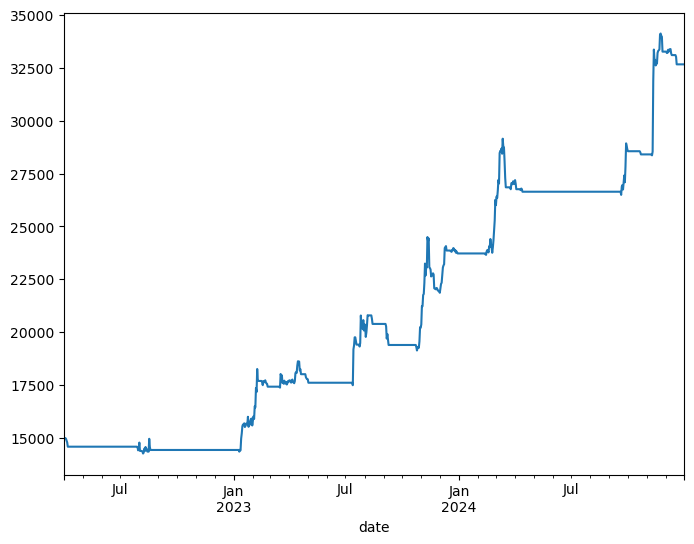

In [247]:
df_final_prod_config_backtested_expanded_alt_universe['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

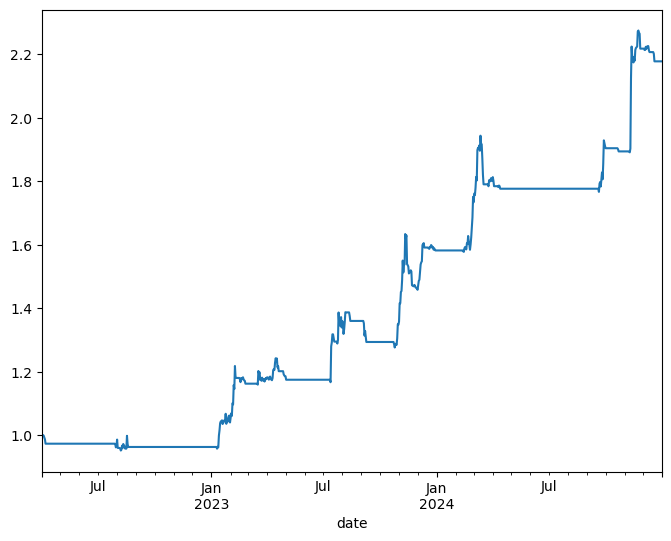

In [249]:
df_final_prod_config_backtested_expanded_alt_universe['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

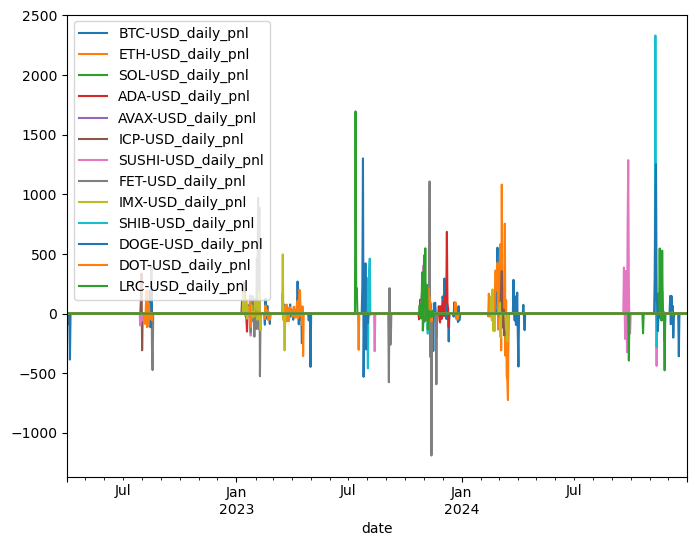

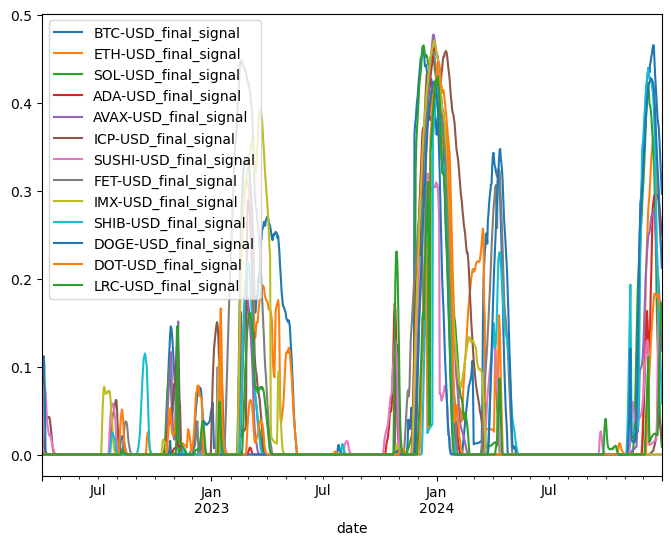

In [251]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[final_signal_cols].plot(figsize=(8,6))

In [253]:
## Higher Vol Target (0.90)
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=0.90,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = df_final_prod_config_backtested_expanded_alt_universe_higher_vol[df_final_prod_config_backtested_expanded_alt_universe_higher_vol.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe_higher_vol = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe_higher_vol

Generating Moving Average Ribbon Signal!!


KeyboardInterrupt: 

<Axes: xlabel='date'>

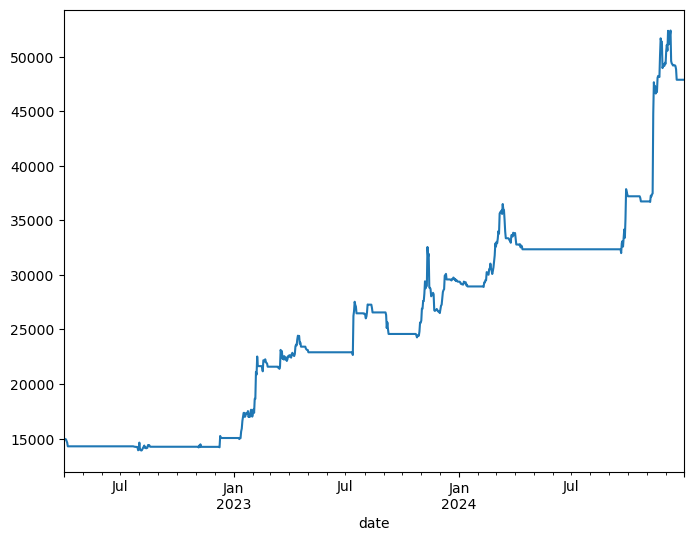

In [310]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

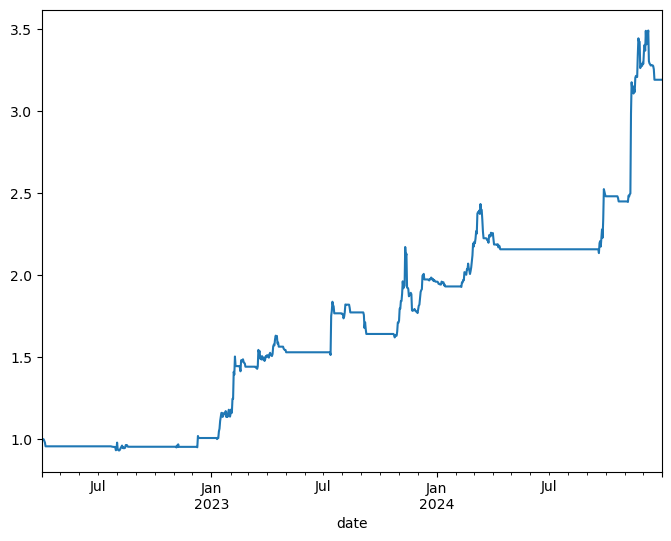

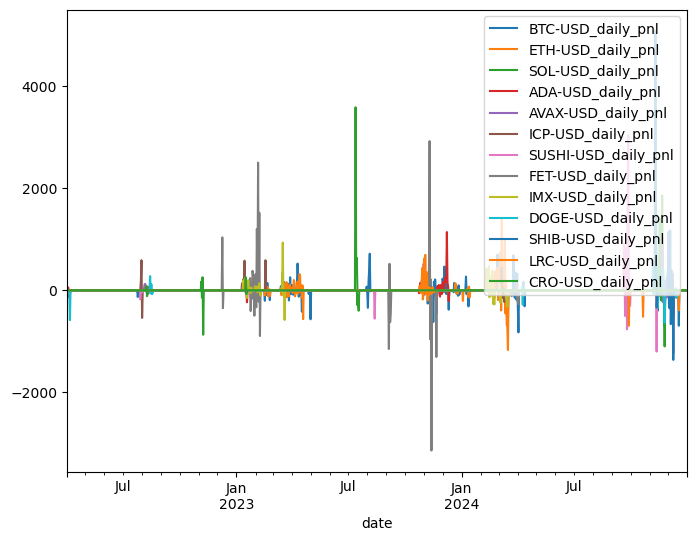

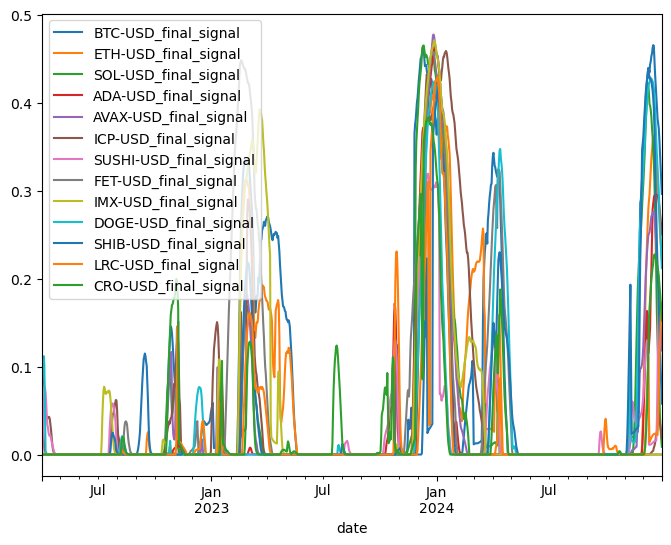

In [312]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['equity_curve'].plot(figsize=(8,6))

daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[final_signal_cols].plot(figsize=(8,6))

### Rolling Sharpe & Performance Driven Alt Ticker Selection

In [335]:
sleeves.keys()

dict_keys(['core_L1_run1', 'L1_run2', 'L1_run3', 'L1_large', 'L2_run1', 'DeFi_run1', 'DeFi_run2', 'DeFi_run3', 'DeFi_run4'])

In [365]:
# Start from one sleeve and outer-join others
df_all = None
for name, df in sleeves.items():
    print(name)
    if name == 'L1_large':
        continue
    else:
        asset_cols = [c for c in df.columns if c.endswith(ASSET_RET_SUFFIX) and c != 'portfolio_daily_pct_returns']
        sub = df[asset_cols]
        if df_all is None:
            df_all = sub.copy()
        else:
            if ('ADA-USD_daily_pct_returns' in df_all.columns) & ('ADA-USD_daily_pct_returns' in sub.columns):
                sub = sub.drop(['ADA-USD_daily_pct_returns'], axis=1)
            df_all = df_all.join(sub, how="outer")
        
df_all = df_all.sort_index()
all_tickers = sorted({c.replace(ASSET_RET_SUFFIX, "") for c in df_all.columns})


core_L1_run1
L1_run2
L1_run3
L1_large
L2_run1
DeFi_run1
DeFi_run2
DeFi_run3
DeFi_run4


In [367]:
all_tickers

['1INCH-USD',
 'AAVE-USD',
 'ADA-USD',
 'ALGO-USD',
 'AMP-USD',
 'ATOM-USD',
 'AVAX-USD',
 'BAL-USD',
 'BTC-USD',
 'COMP-USD',
 'CRO-USD',
 'CRV-USD',
 'DIA-USD',
 'DOGE-USD',
 'DOT-USD',
 'ETH-USD',
 'FET-USD',
 'FIL-USD',
 'GRT-USD',
 'ICP-USD',
 'IMX-USD',
 'KRL-USD',
 'LINK-USD',
 'LRC-USD',
 'MANA-USD',
 'MKR-USD',
 'OXT-USD',
 'REQ-USD',
 'SHIB-USD',
 'SKL-USD',
 'SNX-USD',
 'SOL-USD',
 'STX-USD',
 'SUSHI-USD',
 'UNI-USD',
 'XLM-USD',
 'XTZ-USD']

In [413]:
def compute_rolling_coin_sharpe(df, ticker_list,
                                window_days=180,
                                ret_suffix=ASSET_RET_SUFFIX,
                                ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Returns a MultiIndex Series: index=(date, ticker), value=rolling Sharpe.
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    frames = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df.columns:
            continue
        r = df[col].dropna()
        if r.empty:
            continue
        
        excess_returns = r - daily_rf
        roll_mu = excess_returns.rolling(window_days).mean()
        roll_sig = excess_returns.rolling(window_days).std()
        roll_sharpe = (roll_mu / roll_sig) * np.sqrt(ann_days)

        s = roll_sharpe.to_frame("rolling_sharpe")
        s["ticker"] = t
        frames.append(s)

    out = pd.concat(frames)
    out = out.reset_index().set_index(["date", "ticker"]).sort_index()
    out.index.names = ["date", "ticker"]
    out = out.replace([np.inf, -np.inf], np.nan)
    return out["rolling_sharpe"]

rolling_sharpe = compute_rolling_coin_sharpe(df_all, all_tickers, window_days=180)


In [415]:
rolling_sharpe

date        ticker   
2022-04-01  1INCH-USD           NaN
            AAVE-USD            NaN
            ADA-USD             NaN
            ALGO-USD            NaN
            AMP-USD             NaN
            ATOM-USD            NaN
            AVAX-USD            NaN
            BAL-USD             NaN
            BTC-USD             NaN
            COMP-USD            NaN
            CRO-USD             NaN
            CRV-USD             NaN
            DIA-USD             NaN
            DOGE-USD            NaN
            DOT-USD             NaN
            ETH-USD             NaN
            FET-USD             NaN
            FIL-USD             NaN
            GRT-USD             NaN
            ICP-USD             NaN
            IMX-USD             NaN
            KRL-USD             NaN
            LINK-USD            NaN
            LRC-USD             NaN
            MANA-USD            NaN
            MKR-USD             NaN
            OXT-USD             NaN
      

In [417]:
def build_alt_universe_by_month(rolling_sharpe,
                                core_tickers,
                                sharpe_threshold=0.0,
                                max_alts=8):
    """
    rolling_sharpe: Series indexed by (date, ticker)
    """
    alt_universe_by_month = {}

    dates = rolling_sharpe.index.get_level_values("date")
    month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()

    for me in month_ends:
        try:
            rs_me = rolling_sharpe.xs(me, level="date")
        except KeyError:
            continue

        rs_df = rs_me.reset_index()
        rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

        # Filter by Sharpe threshold
        rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]

        rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)
        selected = rs_df["ticker"].head(max_alts).tolist()
        alt_universe_by_month[me.date()] = selected

    return alt_universe_by_month

alt_universe_by_month = build_alt_universe_by_month(
    rolling_sharpe,
    core_tickers=core_tickers,
    sharpe_threshold=0.0,
    max_alts=8,
)

list(alt_universe_by_month.items())[:5]  # peek at first few months


[(datetime.date(2022, 4, 30), []),
 (datetime.date(2022, 5, 31), []),
 (datetime.date(2022, 6, 30), []),
 (datetime.date(2022, 7, 31), []),
 (datetime.date(2022, 8, 31), [])]

In [453]:
alt_universe_by_month

{datetime.date(2022, 4, 30): [],
 datetime.date(2022, 5, 31): [],
 datetime.date(2022, 6, 30): [],
 datetime.date(2022, 7, 31): [],
 datetime.date(2022, 8, 31): [],
 datetime.date(2022, 9, 30): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 10, 31): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 11, 30): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 12, 31): ['LINK-USD', 'ATOM-USD', 'FET-USD'],
 datetime.date(2023, 1, 31): ['ICP-USD',
  'AMP-USD',
  'IMX-USD',
  'LINK-USD',
  'GRT-USD',
  'SHIB-USD',
  'ATOM-USD',
  'FET-USD'],
 datetime.date(2023, 2, 28): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD',
  'ATOM-USD'],
 datetime.date(2023, 3, 31): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD'],
 datetime.date(2023, 4, 30): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD'],
 datetime.date(2023, 5, 31): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD',
  'AAVE-USD'],
 date

In [419]:
dates = rolling_sharpe.index.get_level_values("date")
month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()
for me in month_ends:
    try:
        rs_me = rolling_sharpe.xs(me, level="date")
    except KeyError:
        continue

In [437]:
rs_df = rs_me.reset_index()
rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

In [445]:
sharpe_threshold=0.0
max_alts = 8
# Filter by Sharpe threshold
rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]
rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)

selected = rs_df["ticker"].head(max_alts).tolist()
alt_universe_by_month[me.date()] = selected

In [447]:
selected

['DOGE-USD',
 'SUSHI-USD',
 'CRO-USD',
 'DIA-USD',
 'UNI-USD',
 'KRL-USD',
 'SHIB-USD',
 'IMX-USD']

In [441]:
rs_df

ticker  rolling_sharpe
13   DOGE-USD        2.977465
33  SUSHI-USD        2.041214
10    CRO-USD        1.679405
12    DIA-USD        1.645843
34    UNI-USD        1.484698
21    KRL-USD        1.298607
28   SHIB-USD        1.207750
20    IMX-USD        1.184499
24   MANA-USD        0.713795
23    LRC-USD        0.706450
19    ICP-USD        0.427036

In [429]:
rs_df

ticker  rolling_sharpe
0   1INCH-USD             NaN
1    AAVE-USD       -0.632456
3    ALGO-USD       -2.069471
4     AMP-USD             NaN
5    ATOM-USD       -2.362082
7     BAL-USD       -2.745101
9    COMP-USD             NaN
10    CRO-USD        1.679405
11    CRV-USD       -2.502975
12    DIA-USD        1.645843
13   DOGE-USD        2.977465
14    DOT-USD             NaN
16    FET-USD             NaN
17    FIL-USD             NaN
18    GRT-USD       -2.926906
19    ICP-USD        0.427036
20    IMX-USD        1.184499
21    KRL-USD        1.298607
22   LINK-USD             NaN
23    LRC-USD        0.706450
24   MANA-USD        0.713795
25    MKR-USD             NaN
26    OXT-USD       -2.735401
27    REQ-USD             NaN
28   SHIB-USD        1.207750
29    SKL-USD       -0.149659
30    SNX-USD       -3.224864
32    STX-USD             NaN
33  SUSHI-USD        2.041214
34    UNI-USD        1.484698
35    XLM-USD       -3.541842
36    XTZ-USD      -12.870073

In [421]:
month_ends

DatetimeIndex(['2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31',
               '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [425]:
me

Timestamp('2024-12-31 00:00:00')

In [423]:
rs_me

ticker
1INCH-USD          NaN
AAVE-USD     -0.632456
ADA-USD      -2.863694
ALGO-USD     -2.069471
AMP-USD            NaN
ATOM-USD     -2.362082
AVAX-USD     -0.655046
BAL-USD      -2.745101
BTC-USD       1.315394
COMP-USD           NaN
CRO-USD       1.679405
CRV-USD      -2.502975
DIA-USD       1.645843
DOGE-USD      2.977465
DOT-USD            NaN
ETH-USD      -4.876602
FET-USD            NaN
FIL-USD            NaN
GRT-USD      -2.926906
ICP-USD       0.427036
IMX-USD       1.184499
KRL-USD       1.298607
LINK-USD           NaN
LRC-USD       0.706450
MANA-USD      0.713795
MKR-USD            NaN
OXT-USD      -2.735401
REQ-USD            NaN
SHIB-USD      1.207750
SKL-USD      -0.149659
SNX-USD      -3.224864
SOL-USD       0.517342
STX-USD            NaN
SUSHI-USD     2.041214
UNI-USD       1.484698
XLM-USD      -3.541842
XTZ-USD     -12.870073
Name: rolling_sharpe, dtype: float64

## Sleeve Level Portfolio Optimization

In [ ]:
sleeves_for_opt = ["core_L1_run1", "L1_run2", "L1_run3", "DeFi_run1", "DeFi_run2"]

mu = sleeve_ret[sleeves_for_opt].mean() * ANN_DAYS        # annualized mean
cov = sleeve_ret[sleeves_for_opt].cov() * ANN_DAYS        # annualized cov

def sharpe_for_w(w, mu, cov):
    w = np.asarray(w)
    ann_ret = w @ mu.values
    ann_vol = np.sqrt(w @ cov.values @ w)
    return ann_ret / ann_vol

# simple constrained grid search over core weight & alt splits
best = None
for w_core in np.linspace(0.6, 0.9, 7):         # 0.60 ... 0.90
    remaining = 1 - w_core
    # split remaining evenly across selected alts for now
    k = len(sleeves_for_opt) - 1
    w_alt = remaining / k
    w = np.array([w_core] + [w_alt] * (k))
    s = sharpe_for_w(w, mu, cov)
    if (best is None) or (s > best[0]):
        best = (s, w)

best_sharpe, best_w = best
dict(zip(sleeves_for_opt, best_w)), best_sharpe


In [458]:
sleeve_ret['core_L1_run1'].head()

date
2022-04-01    0.000000
2022-04-02   -0.005886
2022-04-03   -0.003868
2022-04-04    0.011847
2022-04-05    0.010064
Freq: D, Name: core_L1_run1, dtype: float64

## Prod Config Performance Monitoring

In [487]:
end_date

datetime.date(2025, 12, 4)

In [489]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=False, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 6.067998716945204,
 'annualized_sharpe_ratio': 2.256188729740015,
 'calmar_ratio': 44.59609666170008,
 'annualized_std_dev': 0.7852139801815674,
 'max_drawdown': -0.13606569119661338,
 'max_drawdown_duration': Timedelta('120 days 00:00:00'),
 'hit_rate': 0.24107142857142858,
 't_statistic': 4.421345181919284,
 'p_value': 1.0599739788671335e-05,
 'trade_count': 279.0}

In [491]:
df_final_prod_config.tail(5)

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2025-11-30                      3613.269209                               0.0   
2025-12-01                      3424.085475                               0.0   
2025-12-02                      3729.763049                               0.0   
2025-12-03                      3961.273234                               0.0   
2025-12-04                      3884.670069                               0.0   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_30  \
date                                                                         
2025-11-30                           0.0                          0.447941   
2025-12-01                           0.0                          0.443691   
2025-12-02                           0.0                          0.462197   
2025-12-03                           0.0                          0.515199   
2025-12-04                           0.0                          0.513395   

            BTC-USD_close  BTC-USD_cooldown_counter  \
date                                                  
2025-11-30       90369.51                       0.0   
2025-12-01       86282.36                       0.0   
2025-12-02       91308.05                       0.0   
2025-12-03       93453.84                       0.0   
2025-12-04       93733.88                       0.0   

                                  BTC-USD_event  BTC-USD_final_signal  \
date                                                                    
2025-11-30  Entry Blocked by Chandelier (Short)             -0.039762   
2025-12-01  Entry Blocked by Chandelier (Short)             -0.053681   
2025-12-02                          No Position             -0.068969   
2025-12-03  Entry Blocked by Chandelier (Short)             -0.082951   
2025-12-04  Entry Blocked by Chandelier (Short)             -0.098262   

            BTC-USD_final_weighted_additive_signal  BTC-USD_highest_high_56  \
date                                                                          
2025-11-30                               -0.468756                126296.00   
2025-12-01                               -0.468136                126296.00   
2025-12-02                               -0.474353                125226.34   
2025-12-03                               -0.468826                124254.31   
2025-12-04                               -0.461063                123822.08   

            BTC-USD_lowest_low_56  BTC-USD_new_position_entry_exit_price  \
date                                                                       
2025-11-30               80524.65                               90829.68   
2025-12-01               80524.65                               90364.00   
2025-12-02               80524.65                               86282.35   
2025-12-03               80524.65                               91308.05   
2025-12-04               80524.65                               93452.02   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2025-11-30                            0.0                        0.0   
2025-12-01                            0.0                        0.0   
2025-12-02                            0.0                        0.0   
2025-12-03                            0.0                        0.0   
2025-12-04                            0.0                        0.0   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2025-11-30      90829.68                             0.0   
2025-12-01      90364.00                             0.0   
2025-12-02      86282.35                             0.0   
2025-12-03      91308.05                             0.0   
2025-12-04      93452.02                       

<Axes: xlabel='date'>

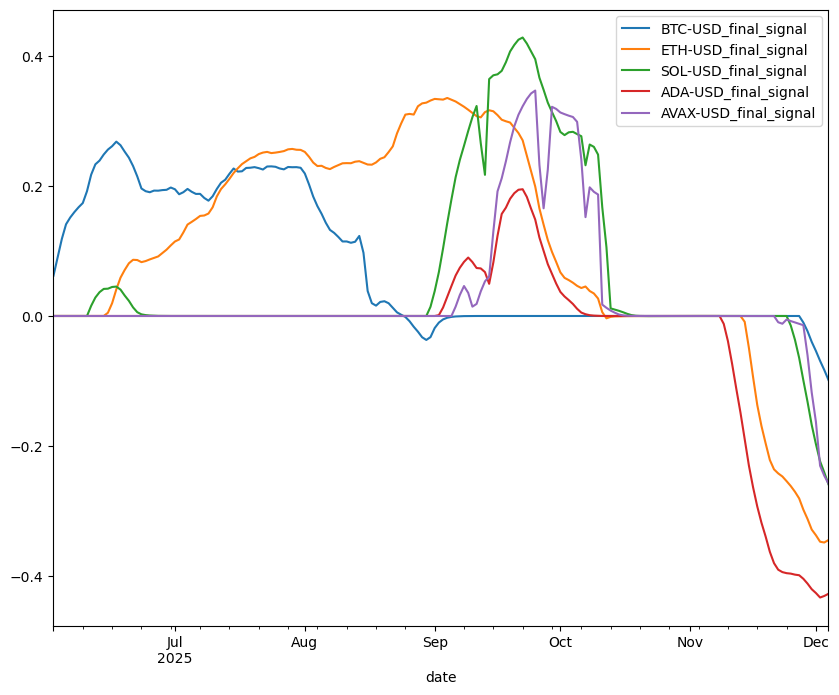

In [493]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][final_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

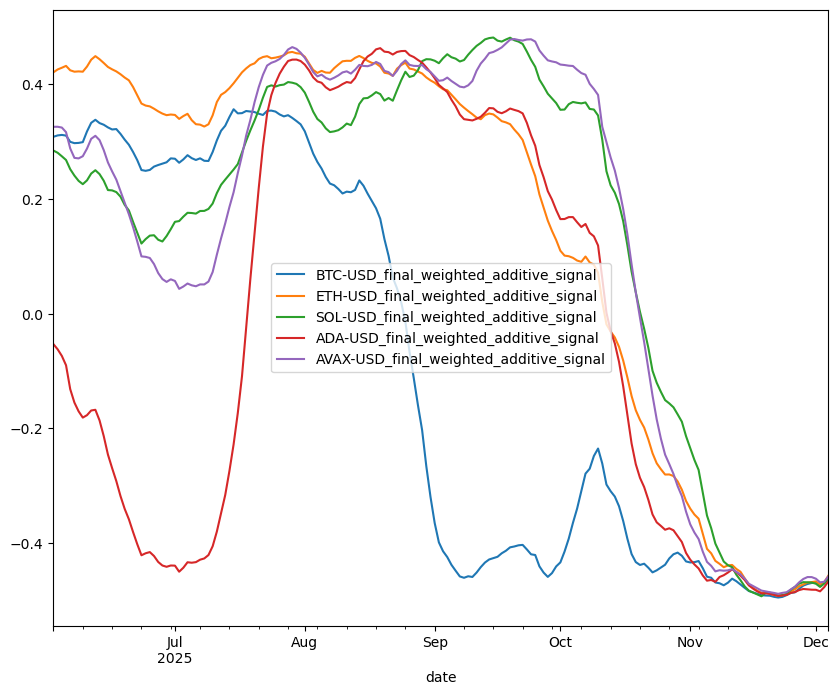

In [495]:
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][raw_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

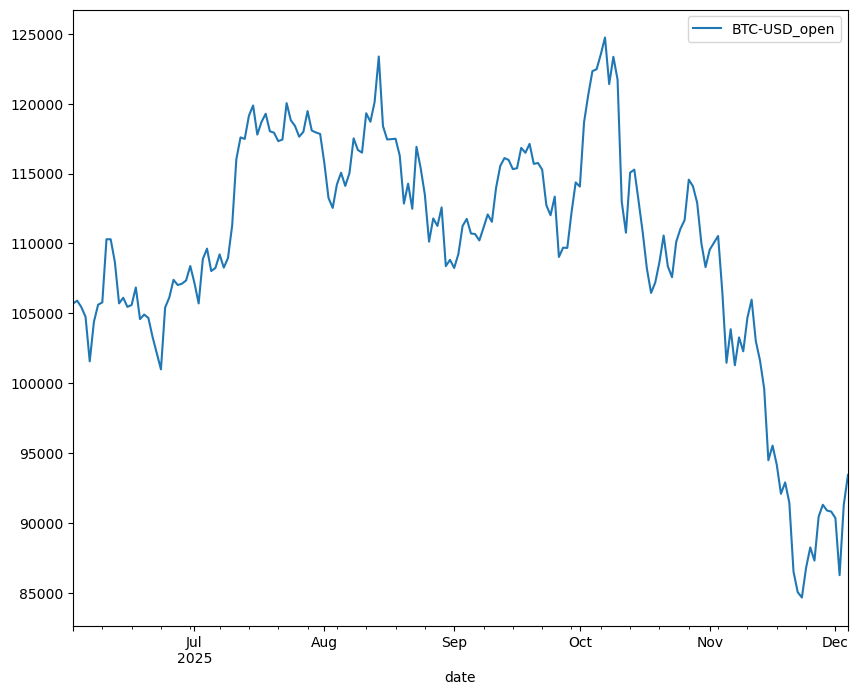

In [497]:
open_cols = [f'{ticker}_open' for ticker in ['BTC-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

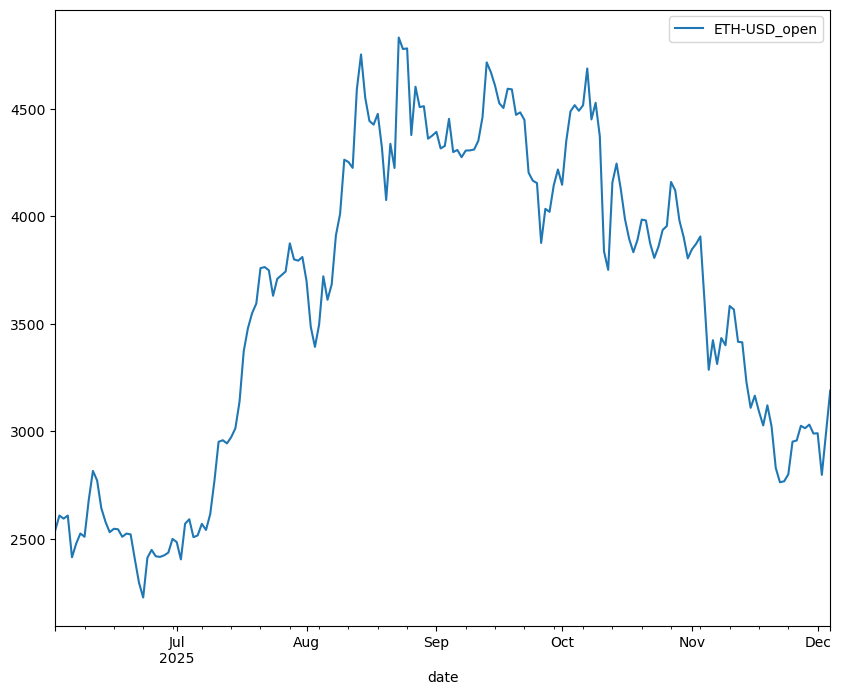

In [499]:
open_cols = [f'{ticker}_open' for ticker in ['ETH-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

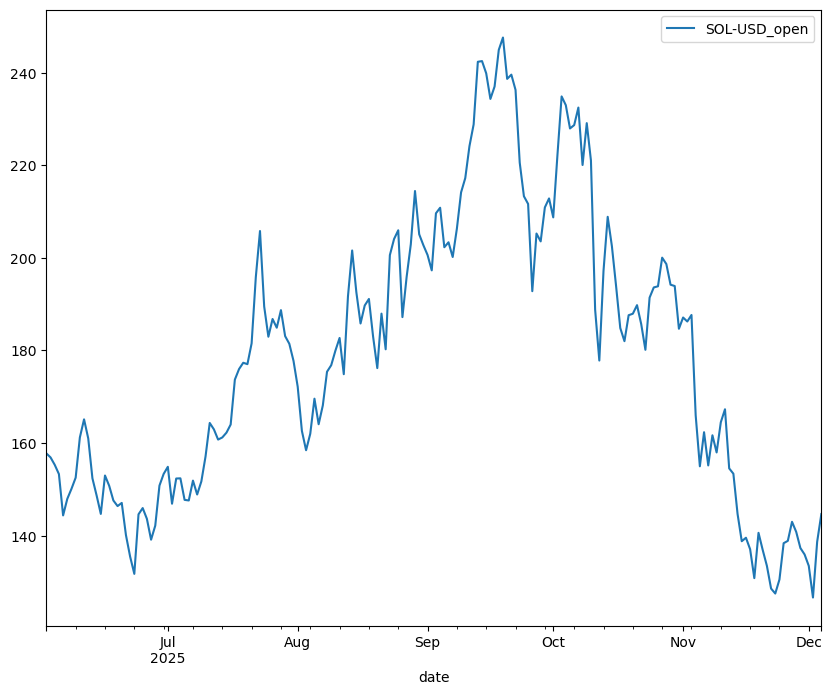

In [501]:
open_cols = [f'{ticker}_open' for ticker in ['SOL-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

In [503]:
open_cols = [f'{ticker}_open' for ticker in ['ADA-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

<Axes: xlabel='date'>

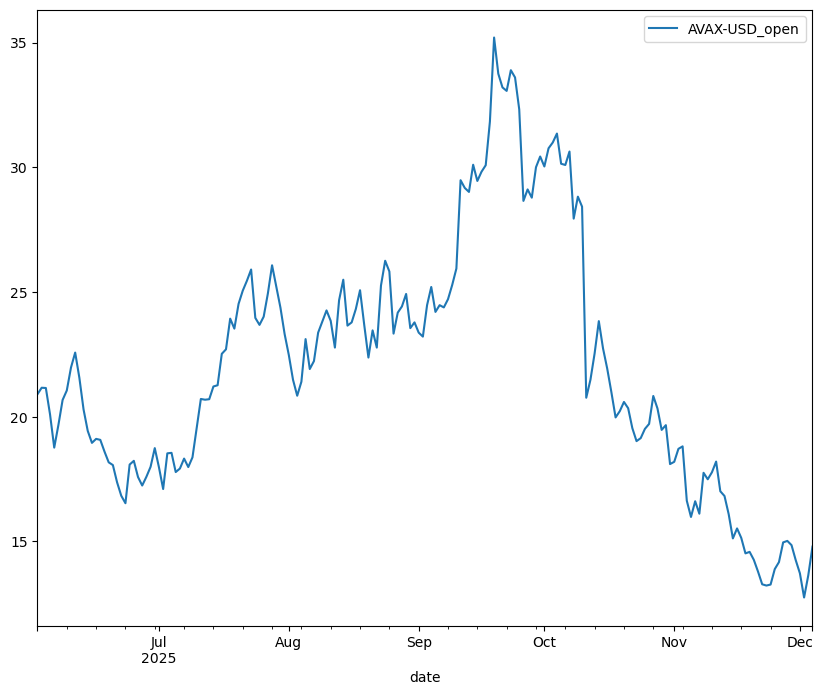

In [505]:
open_cols = [f'{ticker}_open' for ticker in ['AVAX-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))